Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
from IPython.display import Image, display

num_first_items = 1
def display_first_items(folder_path): 
    print('Letter:', folder_path[-1:])
    lst = os.listdir(folder_path)[:num_first_items]
    for file_name in lst: 
        full_file_name = os.path.join(folder_path, file_name)
        display(Image(filename=full_file_name))

for folder in train_folders:
    display_first_items(folder)
for folder in test_folders:
    display_first_items(folder)


Letter: A


Letter: B


Letter: C


Letter: D


Letter: E


Letter: F


Letter: G


Letter: H


Letter: I


Letter: J


Letter: A


Letter: B


Letter: C


Letter: D


Letter: E


Letter: F


Letter: G


Letter: H


Letter: I


Letter: J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      if image_data.mean() == 0.5:
        print('No data in image:', image_file)
        continue
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1600)

notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
notMNIST_large\J.pickle already present - Skipping pickling.
notMNIST_small\A.pickle already present - Skipping pickling.
notMNIST_small\B.pickle already present - Skipping pickling.
notMNIST_small\C.pickle already present - Skipping pickling.
notMNIST_small\D.pickle already present - Skipping pickling.
notMNIST_small\E.pickle already present - Skipping pickling.
notMNIST_small\F.pickle already present - Skipping pickling.
notMNIST_small\G.pickle 

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

notMNIST_large\A.pickle


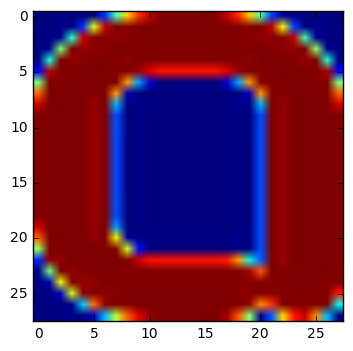

notMNIST_large\B.pickle


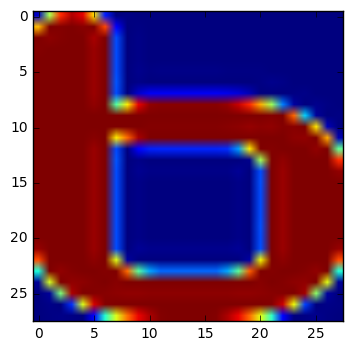

notMNIST_large\C.pickle


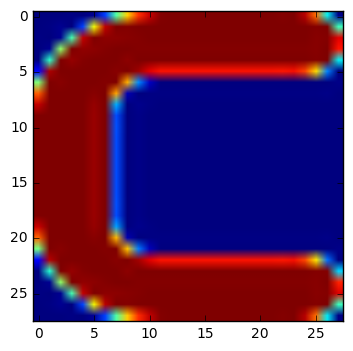

notMNIST_large\D.pickle


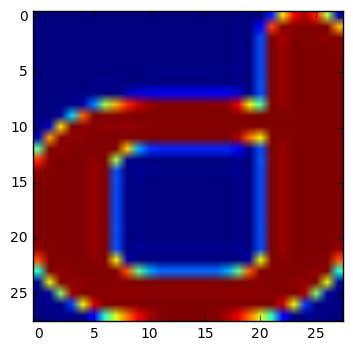

notMNIST_large\E.pickle


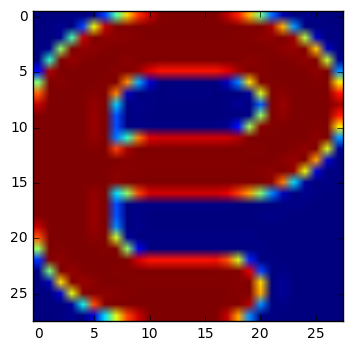

notMNIST_large\F.pickle


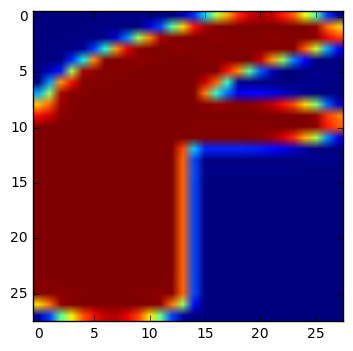

notMNIST_large\G.pickle


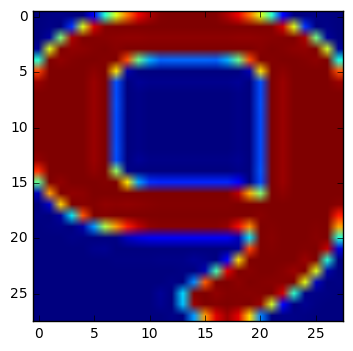

notMNIST_large\H.pickle


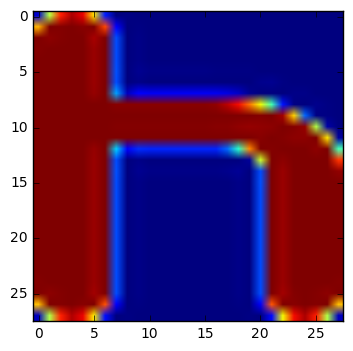

notMNIST_large\I.pickle


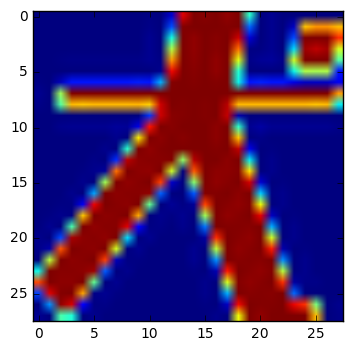

notMNIST_large\J.pickle


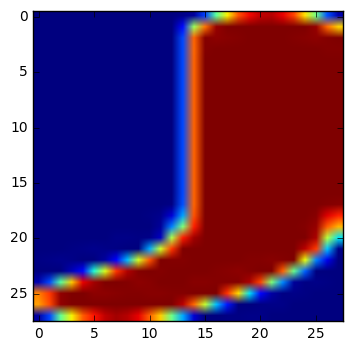

notMNIST_small\A.pickle


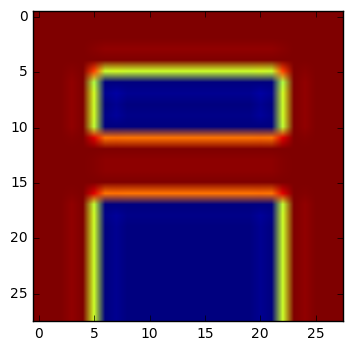

notMNIST_small\B.pickle


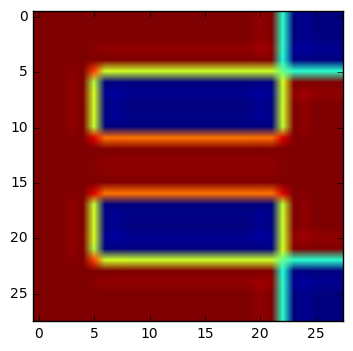

notMNIST_small\C.pickle


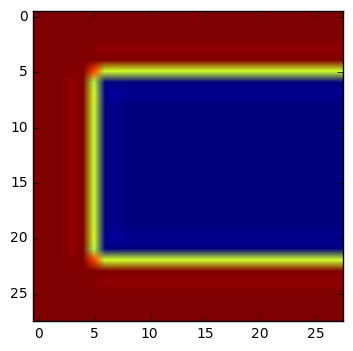

notMNIST_small\D.pickle


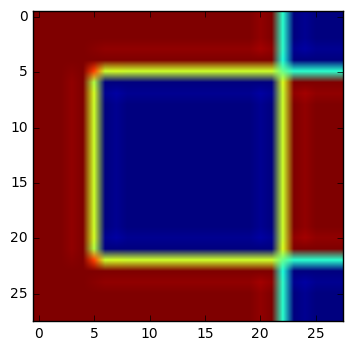

notMNIST_small\E.pickle


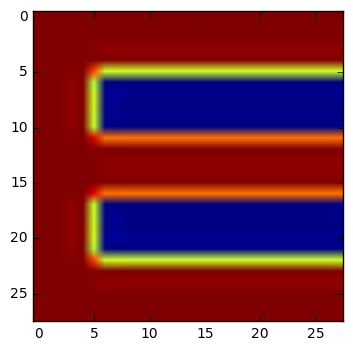

notMNIST_small\F.pickle


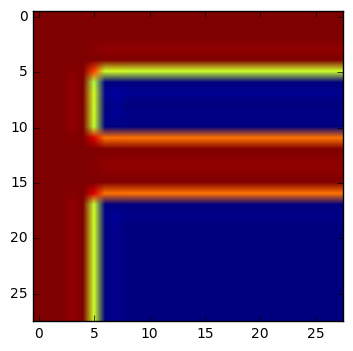

notMNIST_small\G.pickle


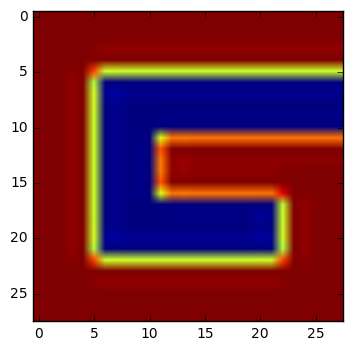

notMNIST_small\H.pickle


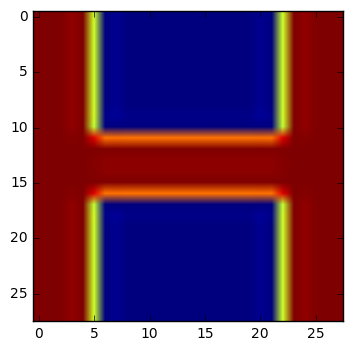

notMNIST_small\I.pickle


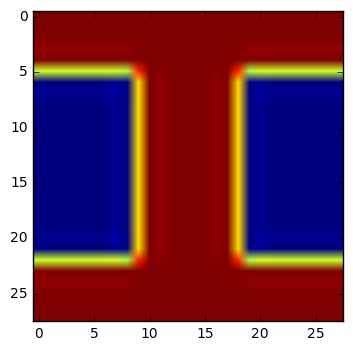

notMNIST_small\J.pickle


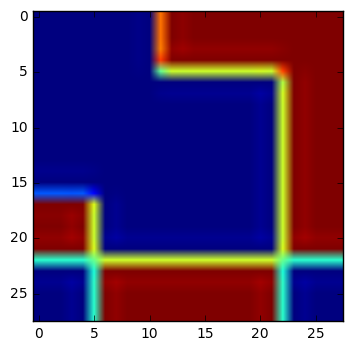

In [7]:
def show_pickle(file_path):
    print(file_path)
    with open(file_path, 'rb') as f:
        dataset = pickle.load(f)
        plt.imshow(dataset[1])
    plt.show()
        
for pickle_file in train_datasets:
    show_pickle(pickle_file)
for pickle_file in test_datasets:
    show_pickle(pickle_file)
    

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

In [8]:
def show_pickle_stats(file_path):
    with open(file_path, 'rb') as f:
        dataset = pickle.load(f)
    print(file_path, len(dataset))

for pickle_file in train_datasets:
    show_pickle_stats(pickle_file)
for pickle_file in test_datasets:
    show_pickle_stats(pickle_file)

notMNIST_large\A.pickle 52904
notMNIST_large\B.pickle 52895
notMNIST_large\C.pickle 52894
notMNIST_large\D.pickle 52906
notMNIST_large\E.pickle 52902
notMNIST_large\F.pickle 52906
notMNIST_large\G.pickle 52893
notMNIST_large\H.pickle 52899
notMNIST_large\I.pickle 47469
notMNIST_large\J.pickle 52894
notMNIST_small\A.pickle 1872
notMNIST_small\B.pickle 1873
notMNIST_small\C.pickle 1873
notMNIST_small\D.pickle 1873
notMNIST_small\E.pickle 1873
notMNIST_small\F.pickle 1872
notMNIST_small\G.pickle 1872
notMNIST_small\H.pickle 1872
notMNIST_small\I.pickle 1618
notMNIST_small\J.pickle 1872


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [10]:
map_dict = {'0': 'A', '1': 'B', '2': 'C', '3': 'D', '4': 'E', '5': 'F', '6': 'G', '7': 'H', '8': 'I', '9': 'J', }
def count_lables(label_list):
    counter_dict = {}
    for label in label_list:
        lbl = map_dict[str(label)]
        if lbl not in counter_dict:
            counter_dict[lbl] = 0
        counter_dict[lbl] += 1
    return counter_dict

In [11]:
print('train labels:', count_lables(train_labels))
print('valid labels:', count_lables(valid_labels))
print('test labels:', count_lables(test_labels))

train labels: {'G': 20000, 'J': 20000, 'D': 20000, 'E': 20000, 'B': 20000, 'F': 20000, 'C': 20000, 'H': 20000, 'I': 20000, 'A': 20000}
valid labels: {'G': 1000, 'J': 1000, 'D': 1000, 'E': 1000, 'B': 1000, 'F': 1000, 'C': 1000, 'H': 1000, 'I': 1000, 'A': 1000}
test labels: {'G': 1000, 'J': 1000, 'D': 1000, 'E': 1000, 'B': 1000, 'F': 1000, 'C': 1000, 'H': 1000, 'I': 1000, 'A': 1000}


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [12]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

In [14]:
print('train labels:', count_lables(train_labels))
print('valid labels:', count_lables(valid_labels))
print('test labels:', count_lables(test_labels))

train labels: {'A': 20000, 'J': 20000, 'B': 20000, 'E': 20000, 'D': 20000, 'G': 20000, 'C': 20000, 'H': 20000, 'I': 20000, 'F': 20000}
valid labels: {'F': 1000, 'J': 1000, 'H': 1000, 'E': 1000, 'B': 1000, 'D': 1000, 'G': 1000, 'C': 1000, 'I': 1000, 'A': 1000}
test labels: {'G': 1000, 'A': 1000, 'F': 1000, 'J': 1000, 'D': 1000, 'E': 1000, 'B': 1000, 'H': 1000, 'C': 1000, 'I': 1000}


F


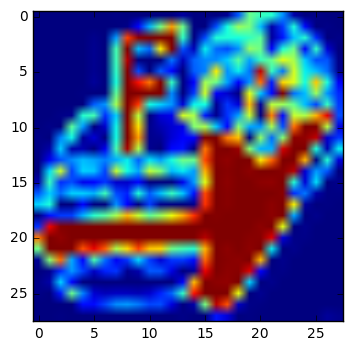

E


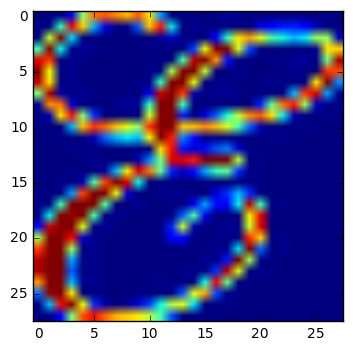

G


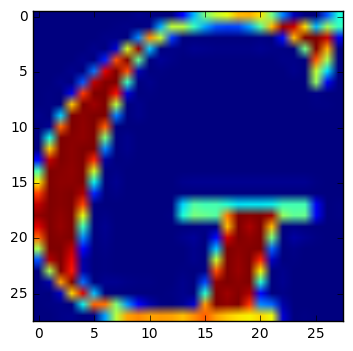

D


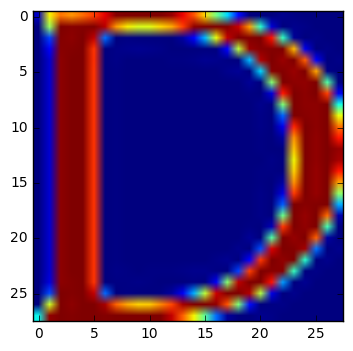

B


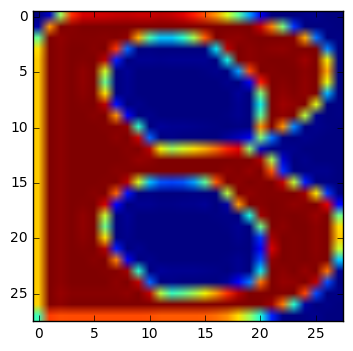

H


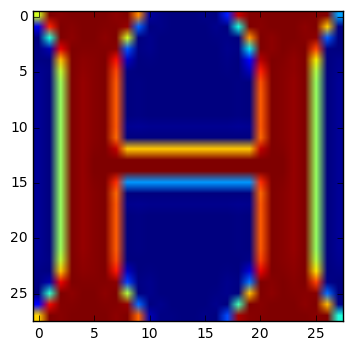

C


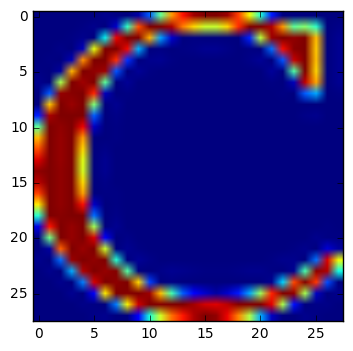

B


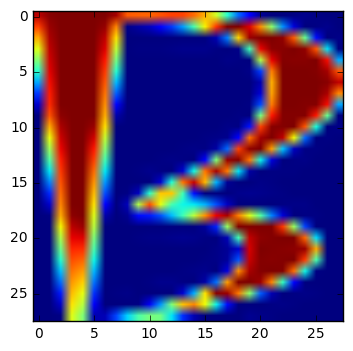

D


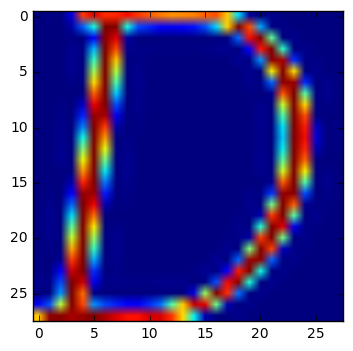

I


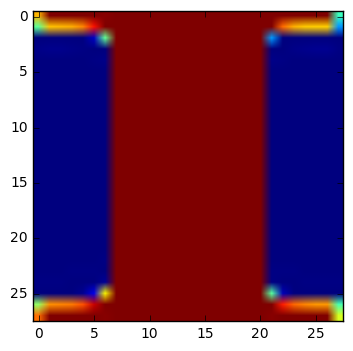

A


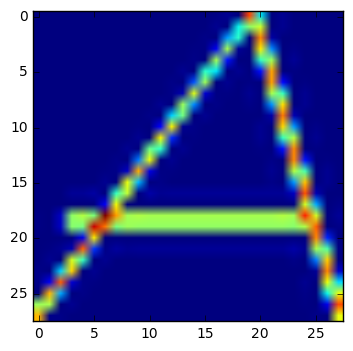

B


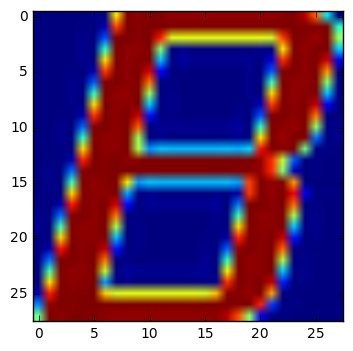

C


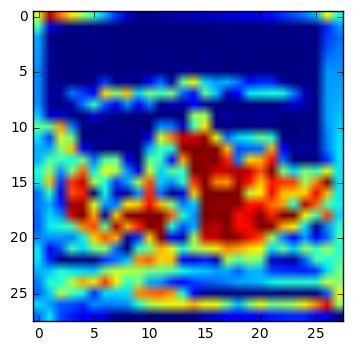

G


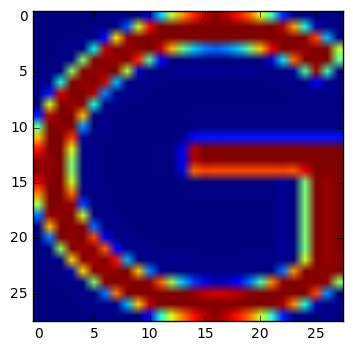

H


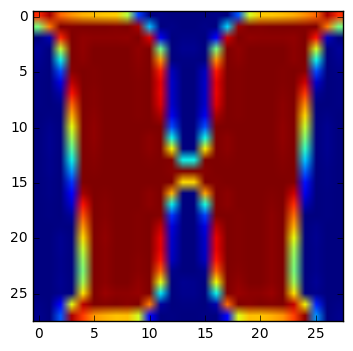

In [15]:
def show_data(dataset, labels, size=5):
    print('=============================================')
    for lbl, img_arr in zip(labels[:size], dataset[:size]):
        print(map_dict[str(lbl)])
        plt.imshow(img_arr)
        plt.show()

show_data(train_dataset, train_labels)
show_data(test_dataset, test_labels)
show_data(valid_dataset, valid_labels)

Finally, let's save the data for later reuse:

In [16]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [17]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

In [14]:
def count_equal_data(labelsA, datasetA, labelsB, datasetB):
    count = 0
    for idxA, lblA in enumerate(labelsA):
        for idxB, lblB in enumerate(labelsB):
            if lblA == lblB:
                figureA = datasetA[idxA]
                figureB = datasetB[idxB]
                if np.array_equal(figureA, figureB):
                    count += 1
    return count

# print('Overlapping train with validation datasets: ', count_equal_data(train_dataset, valid_dataset))
# print('Overlapping train with test datasets: ', count_equal_data(train_dataset, test_dataset))
print('Overlapping validation with test datasets: ', count_equal_data(valid_labels, valid_dataset, test_labels, test_dataset))
    

Overlapping validation with test datasets:  13172


3 58 1420 -158.518


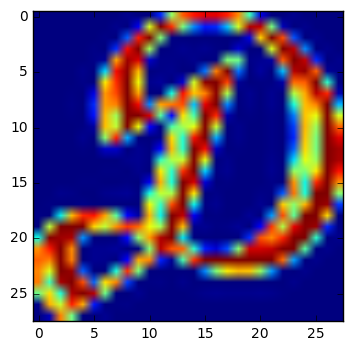

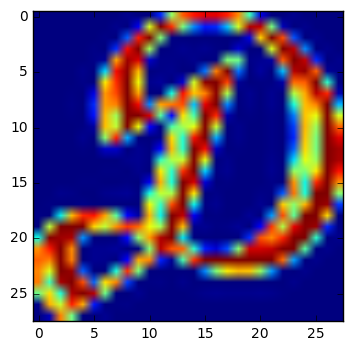

8 100 125 392.0


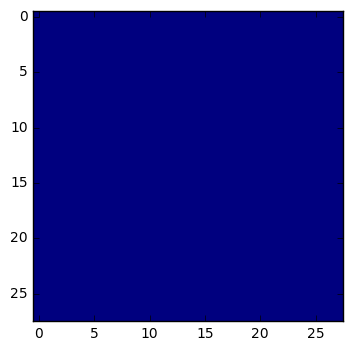

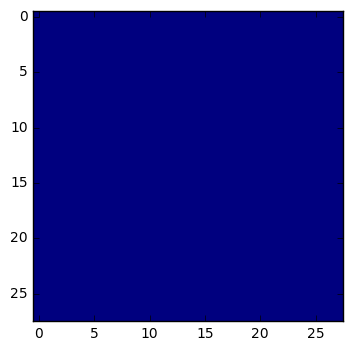

8 100 155 392.0


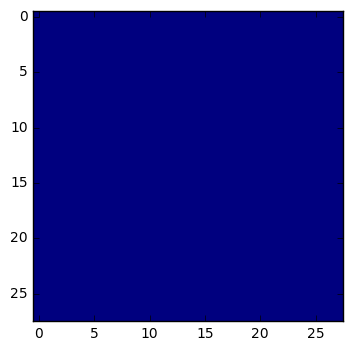

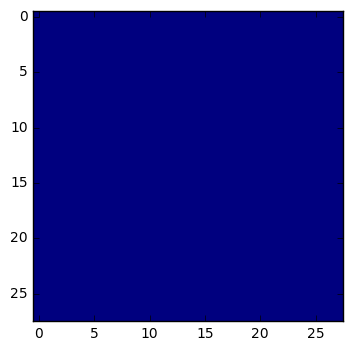

8 100 373 392.0


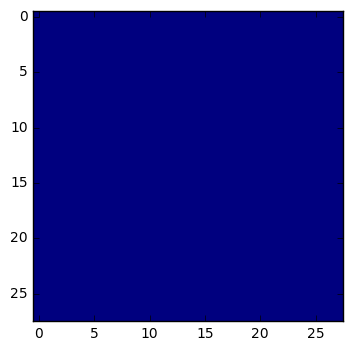

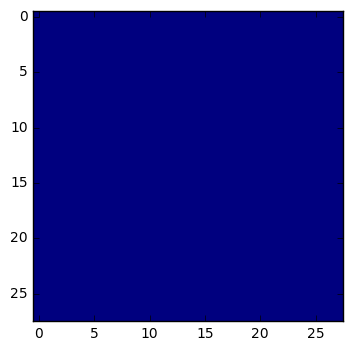

8 100 383 392.0


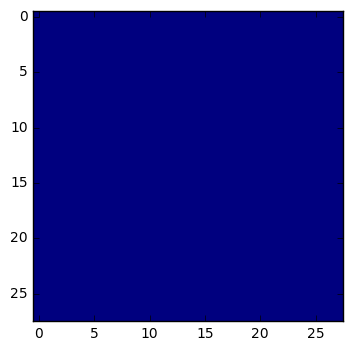

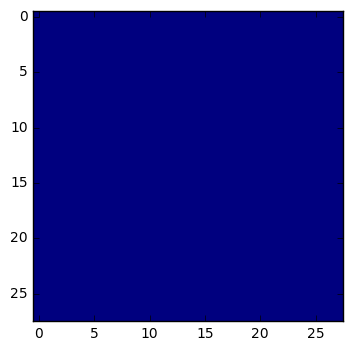

8 100 393 392.0


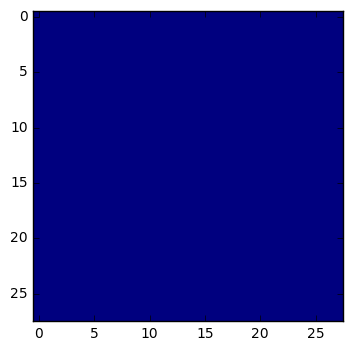

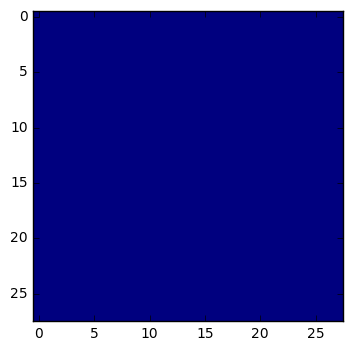

8 100 407 392.0


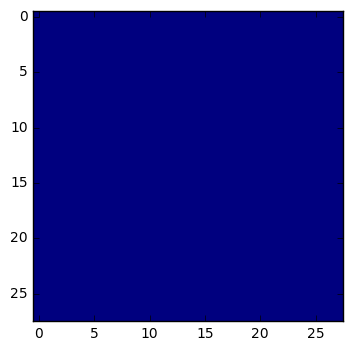

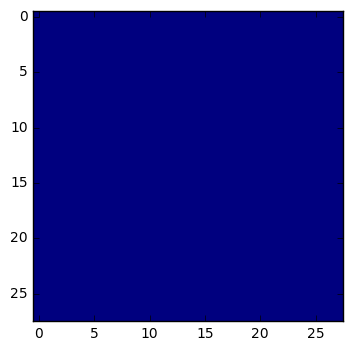

8 100 640 392.0


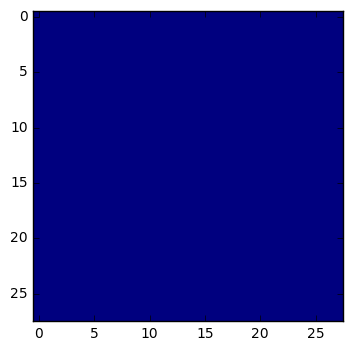

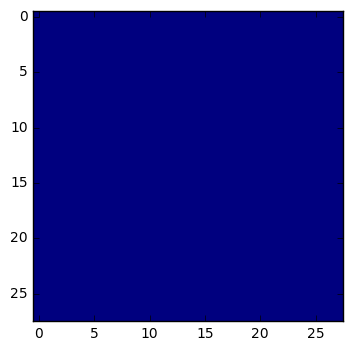

8 100 672 392.0


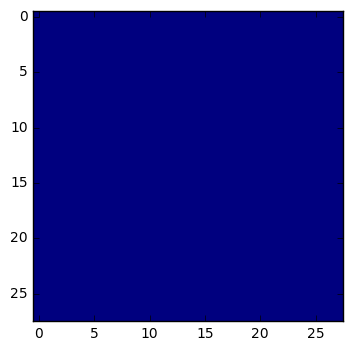

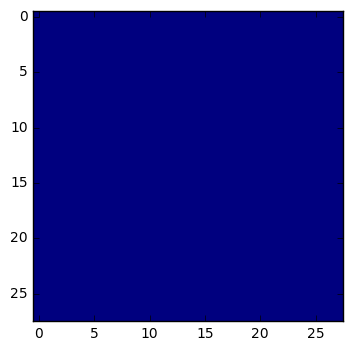

8 100 709 392.0


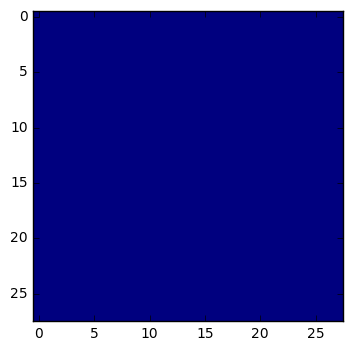

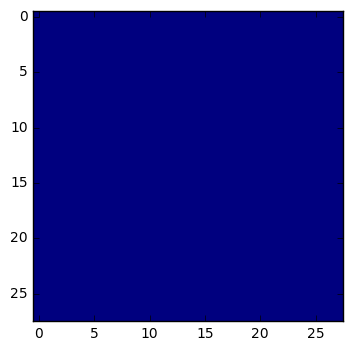

8 100 745 392.0


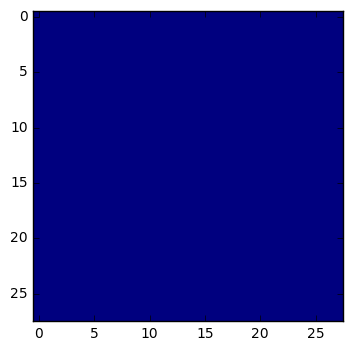

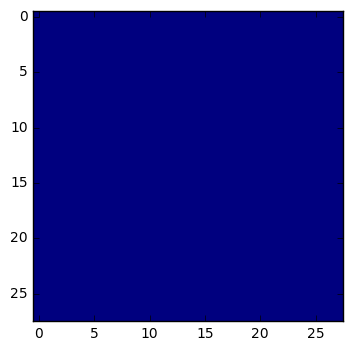

8 100 780 392.0


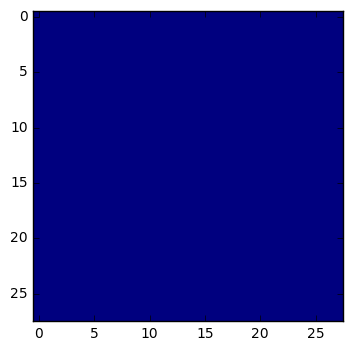

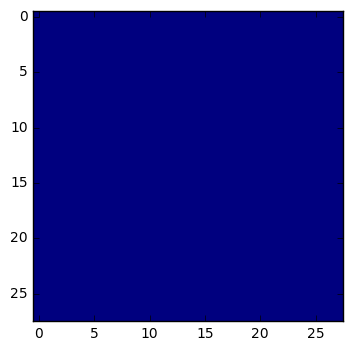

8 100 914 392.0


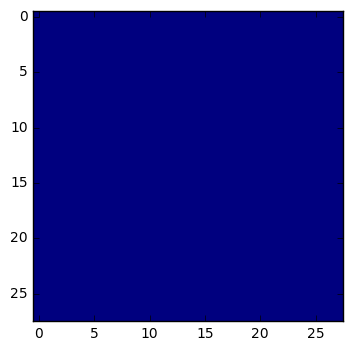

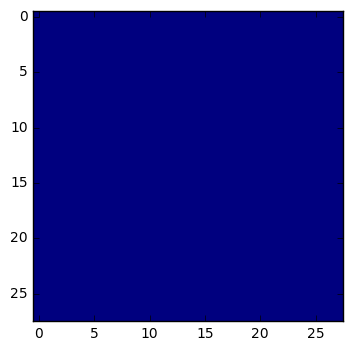

8 100 965 392.0


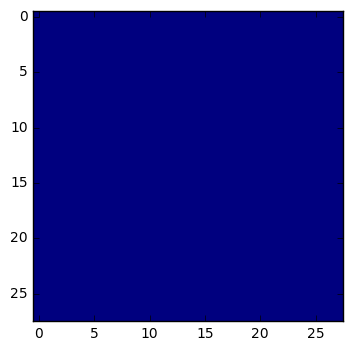

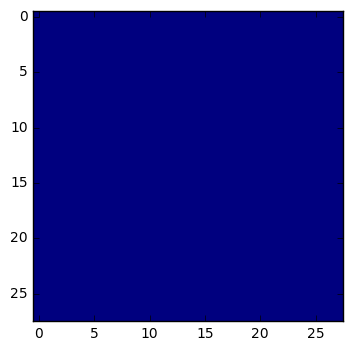

8 100 1048 392.0


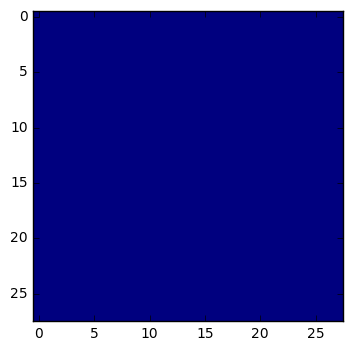

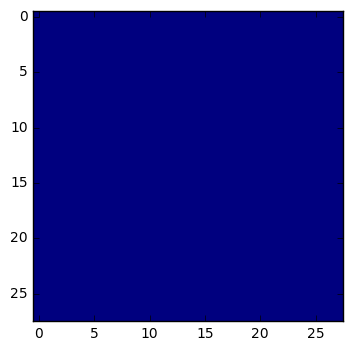

8 100 1127 392.0


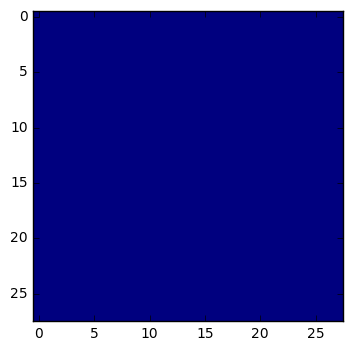

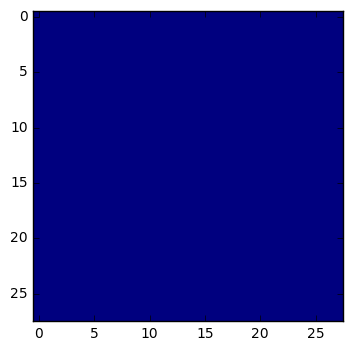

8 100 1182 392.0


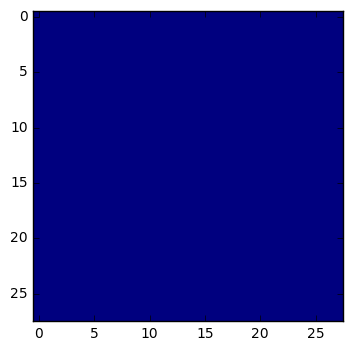

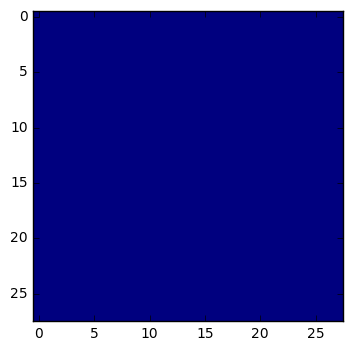

8 100 1209 392.0


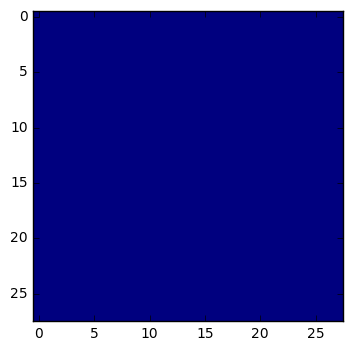

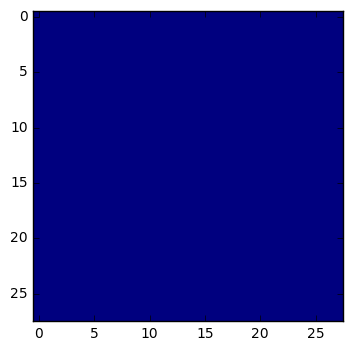

8 100 1251 392.0


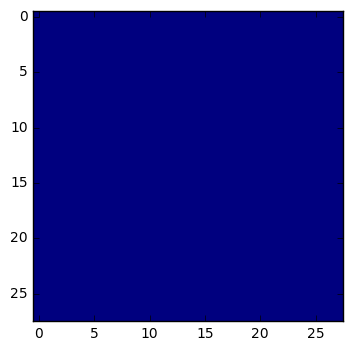

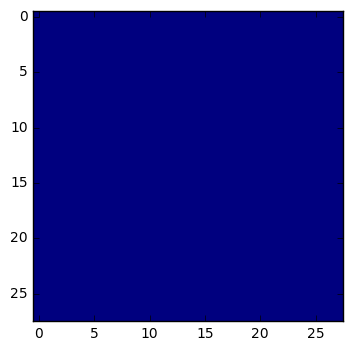

8 100 1348 392.0


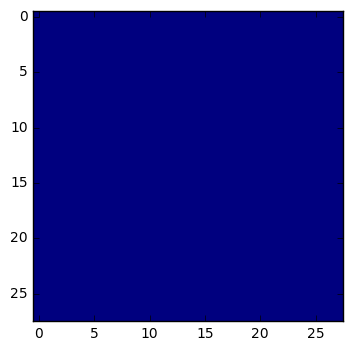

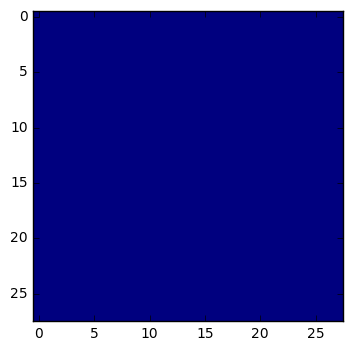

8 100 1387 392.0


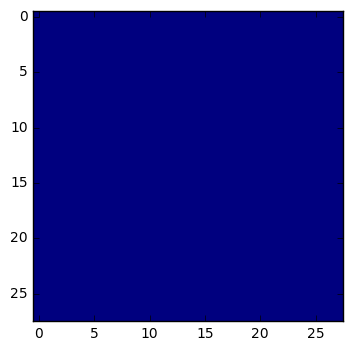

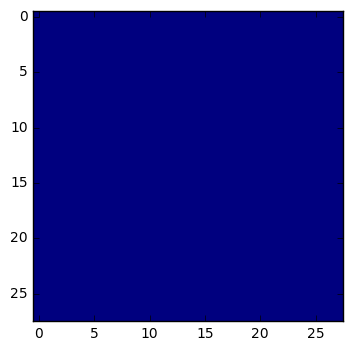

8 100 1390 392.0


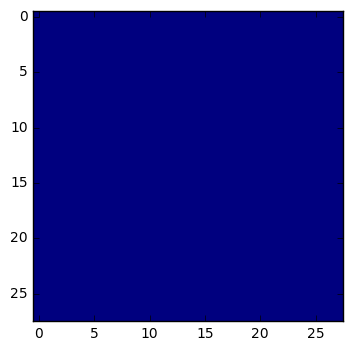

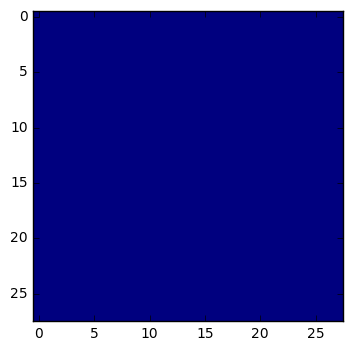

8 100 1437 392.0


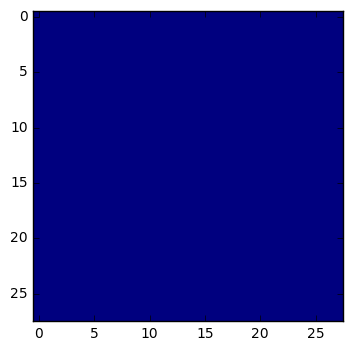

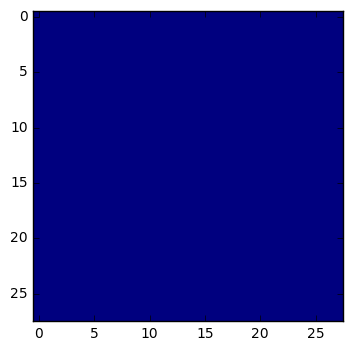

8 100 1513 392.0


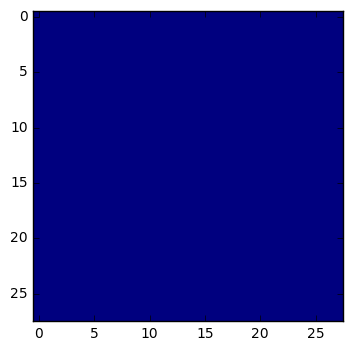

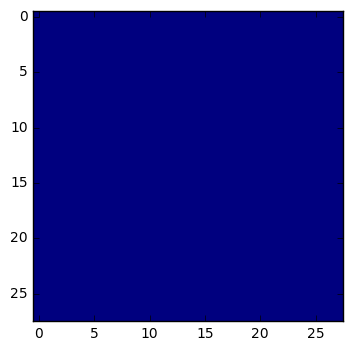

8 100 1547 392.0


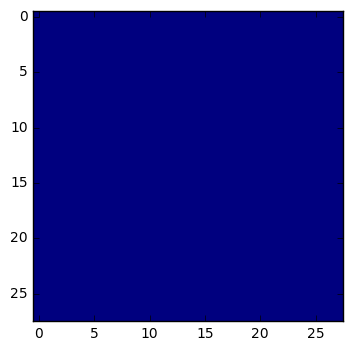

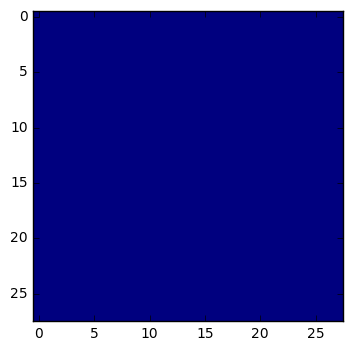

8 100 1585 392.0


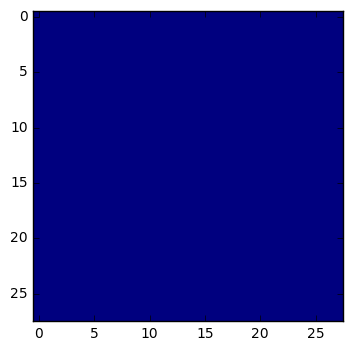

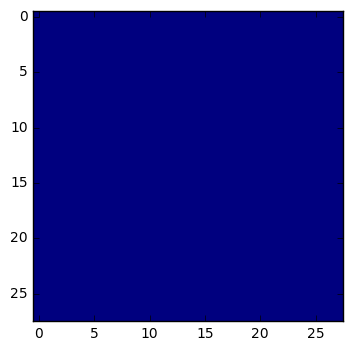

8 100 1693 392.0


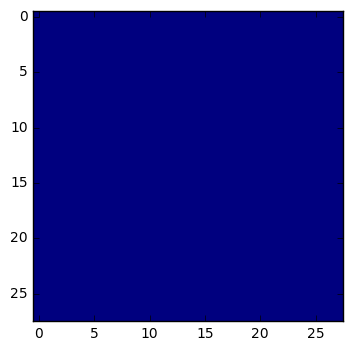

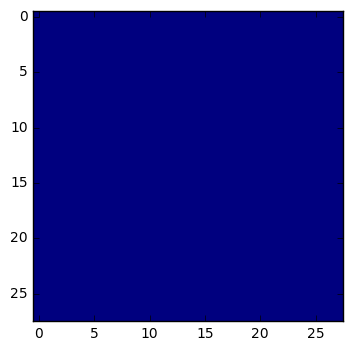

8 100 1791 392.0


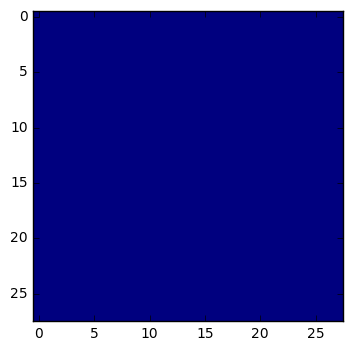

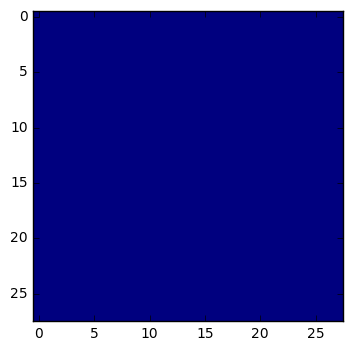

8 100 1867 392.0


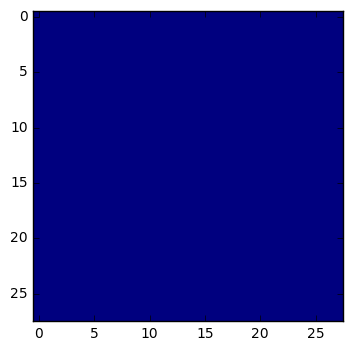

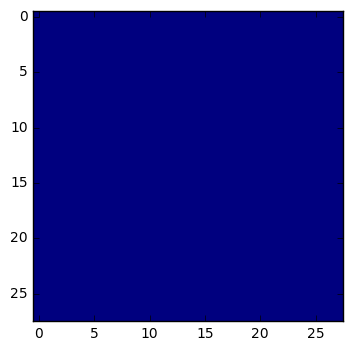

8 100 1941 392.0


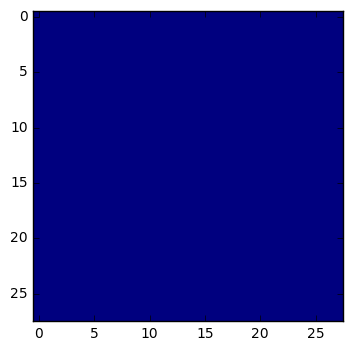

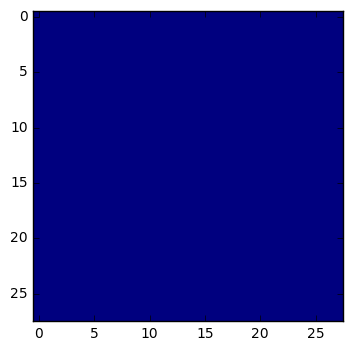

8 100 2003 392.0


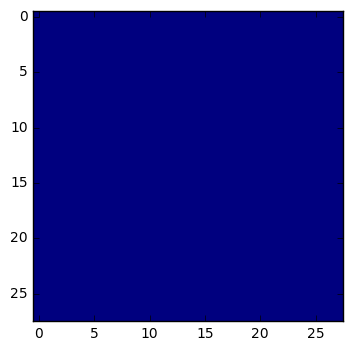

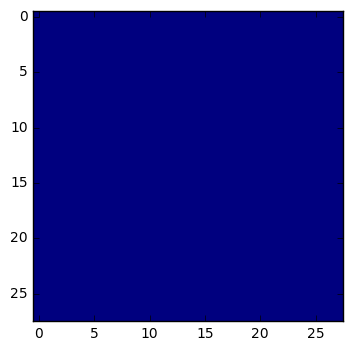

8 100 2042 392.0


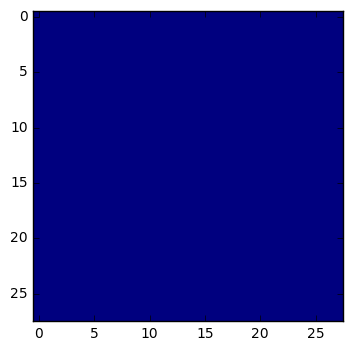

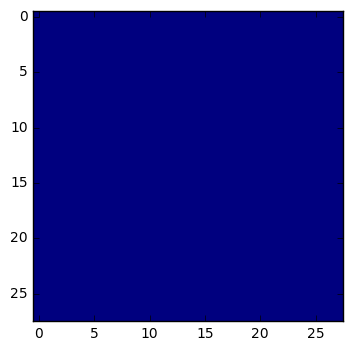

8 100 2090 392.0


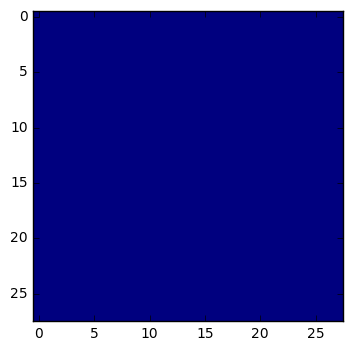

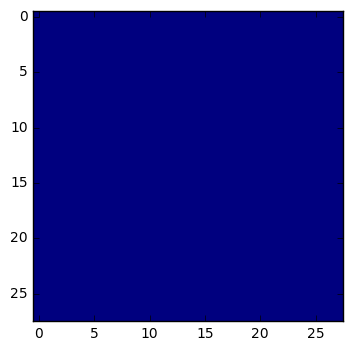

8 100 2118 392.0


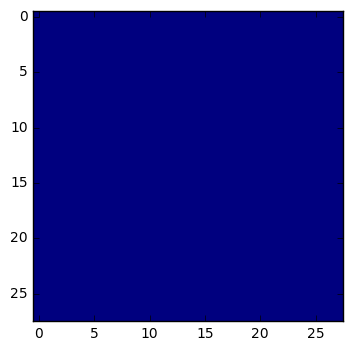

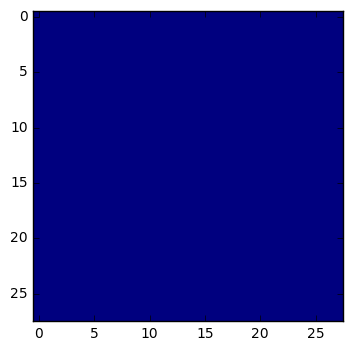

8 100 2168 392.0


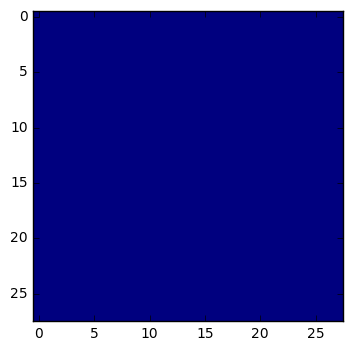

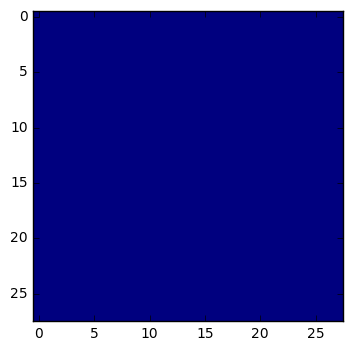

8 100 2248 392.0


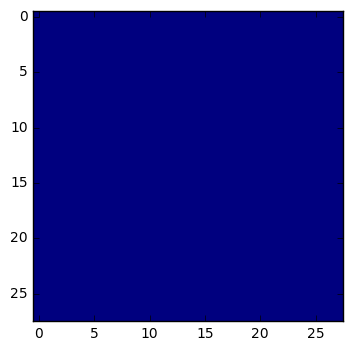

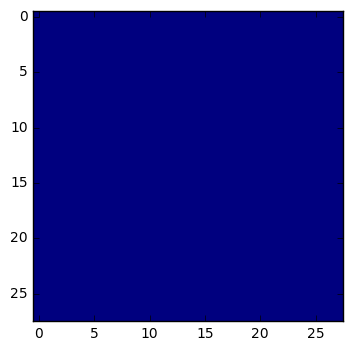

8 100 2312 392.0


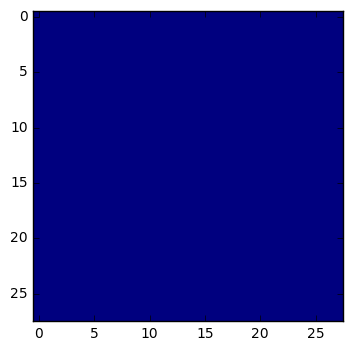

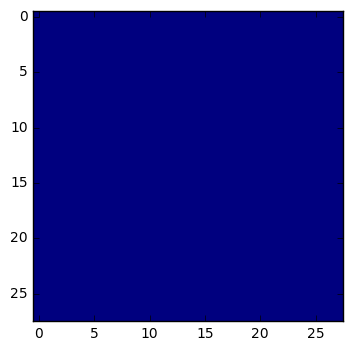

8 100 2449 392.0


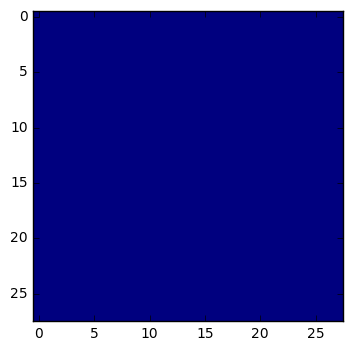

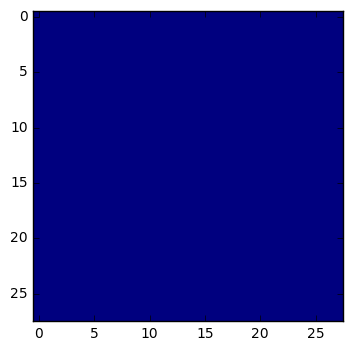

8 100 2753 392.0


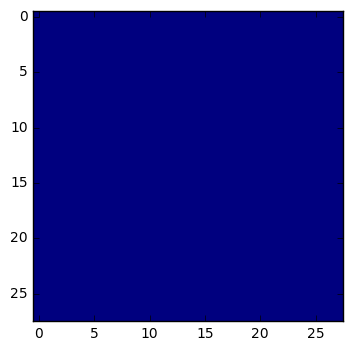

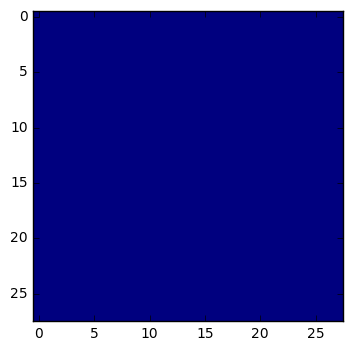

8 100 2777 392.0


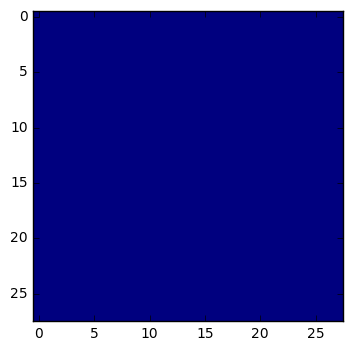

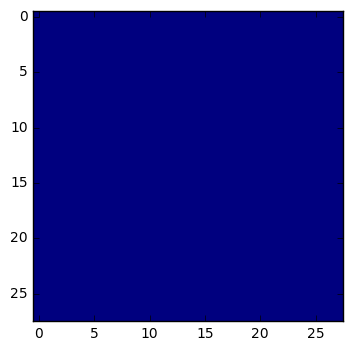

8 100 2808 392.0


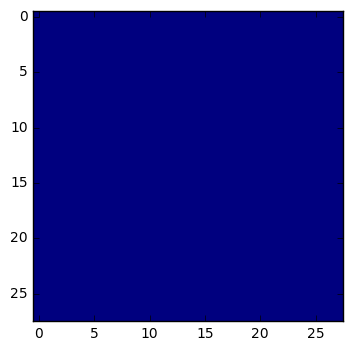

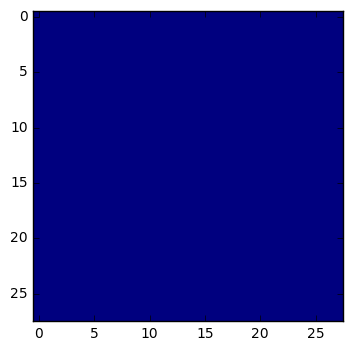

8 100 2830 392.0


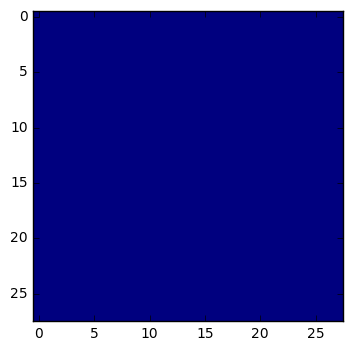

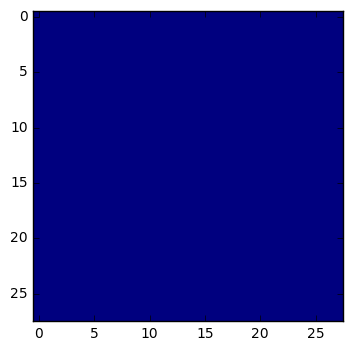

8 100 2884 392.0


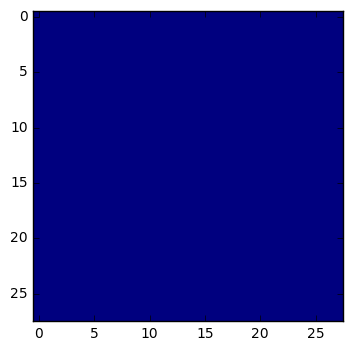

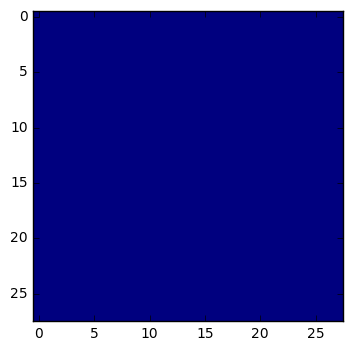

8 100 2922 392.0


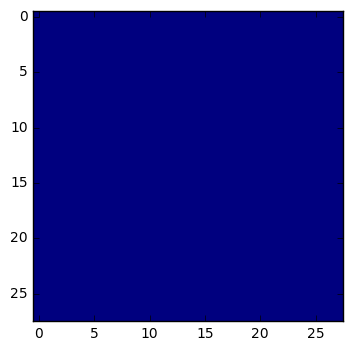

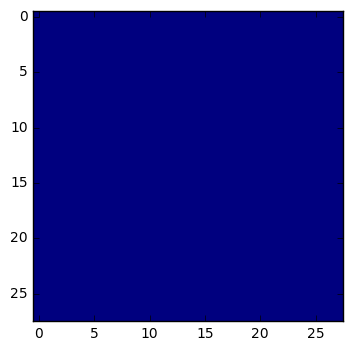

8 100 2949 392.0


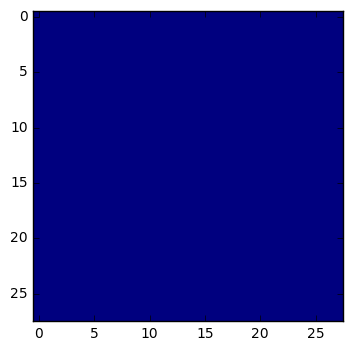

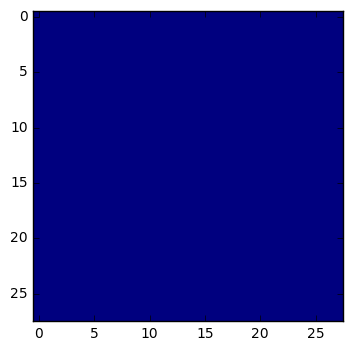

8 100 2960 392.0


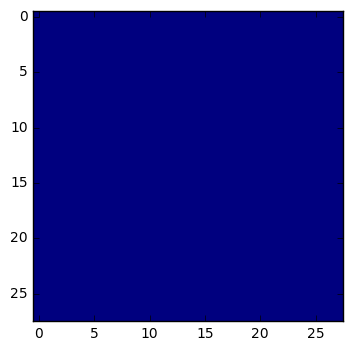

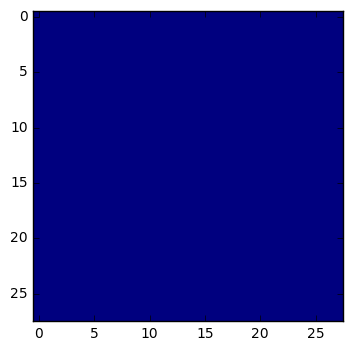

8 100 3039 392.0


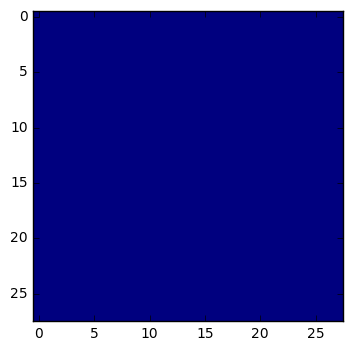

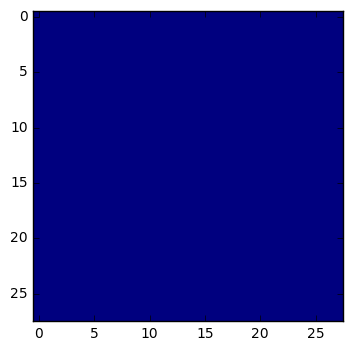

8 100 3086 392.0


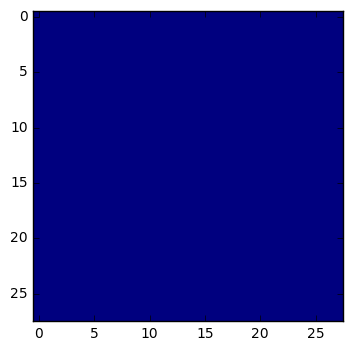

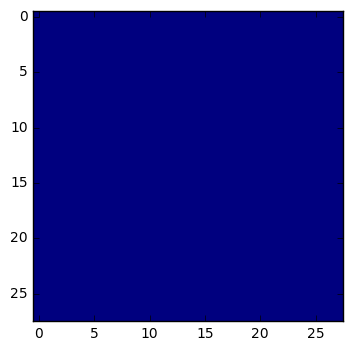

8 100 3128 392.0


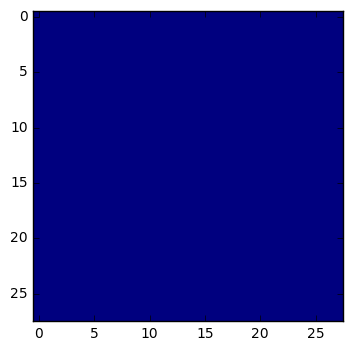

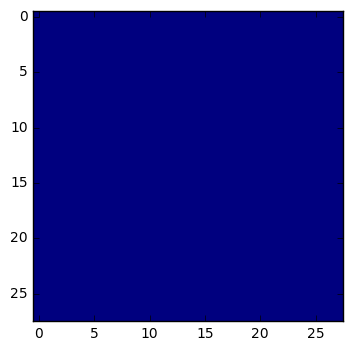

8 100 3160 392.0


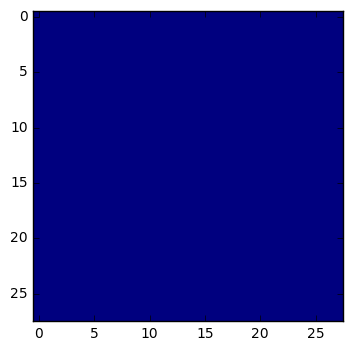

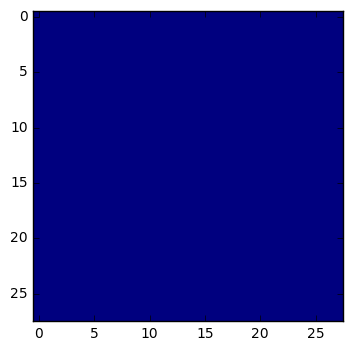

8 100 3163 392.0


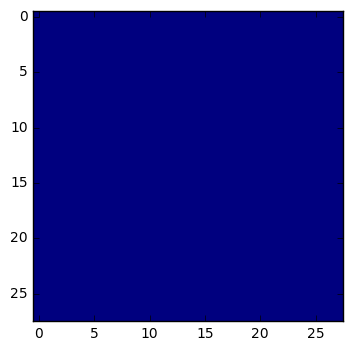

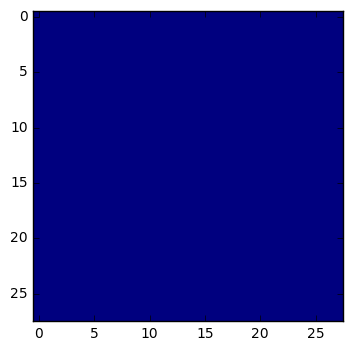

8 100 3250 392.0


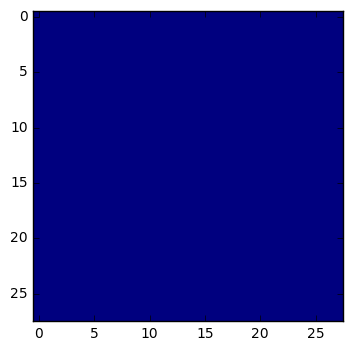

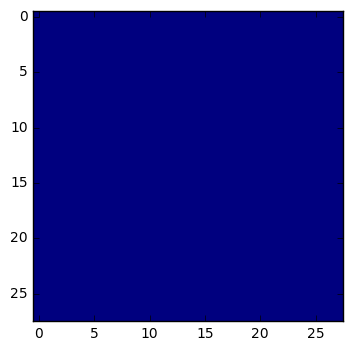

8 100 3258 392.0


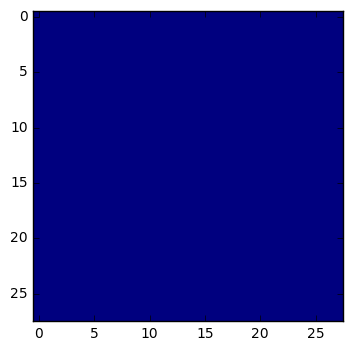

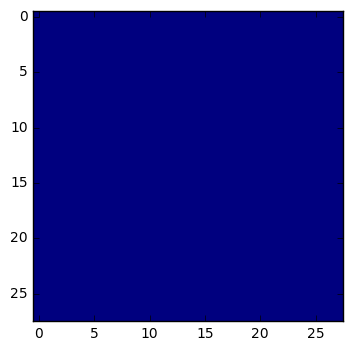

8 100 3299 392.0


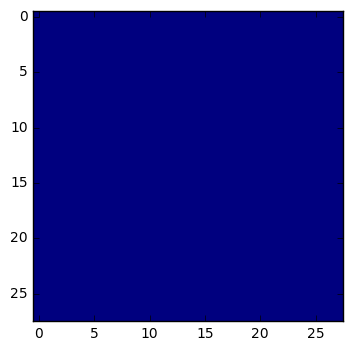

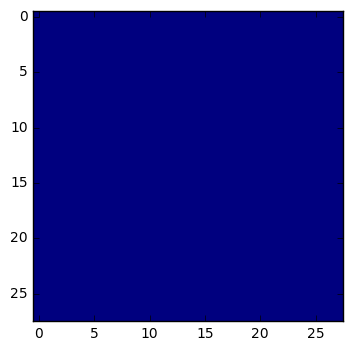

8 100 3335 392.0


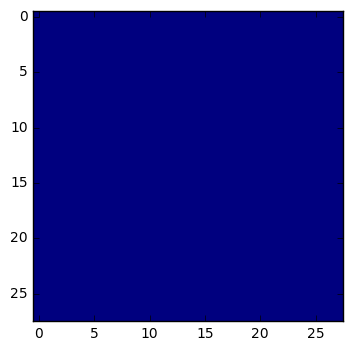

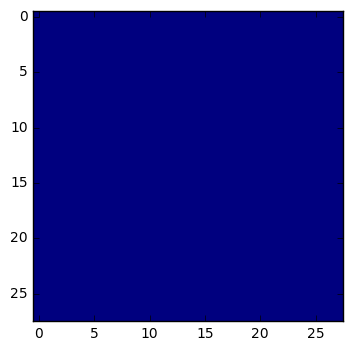

8 100 3407 392.0


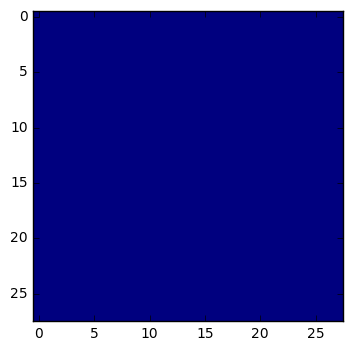

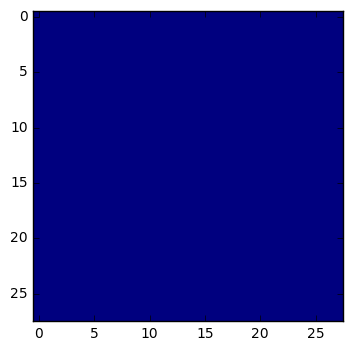

8 100 3474 392.0


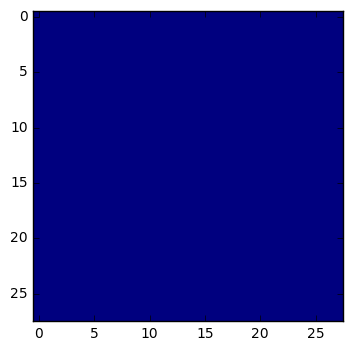

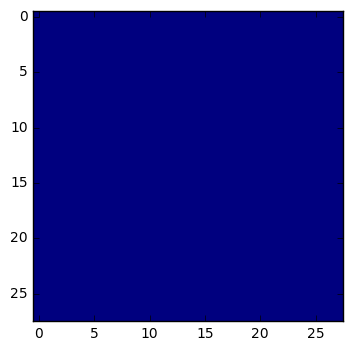

8 100 3548 392.0


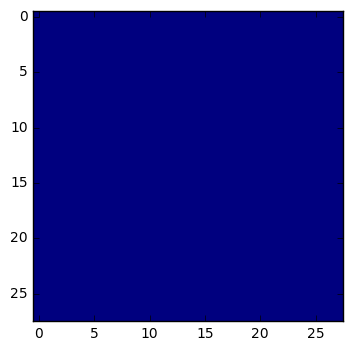

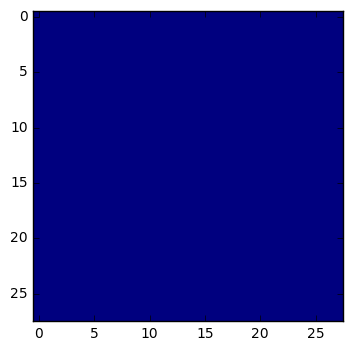

8 100 3626 392.0


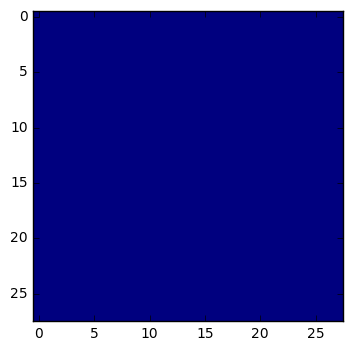

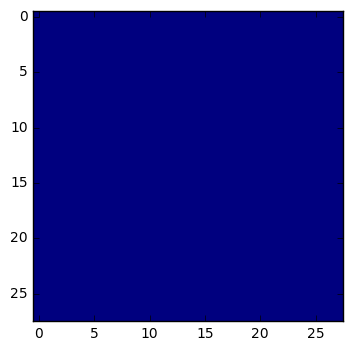

8 100 3685 392.0


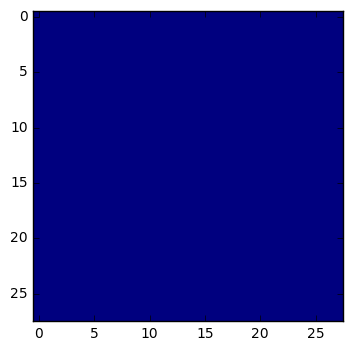

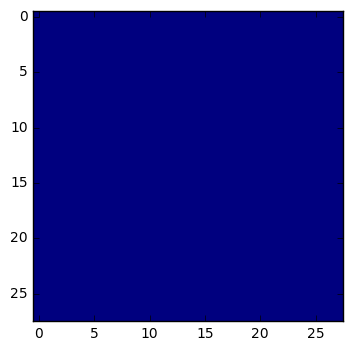

8 100 3740 392.0


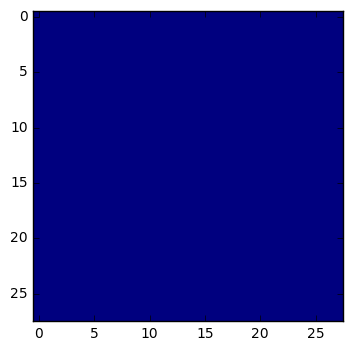

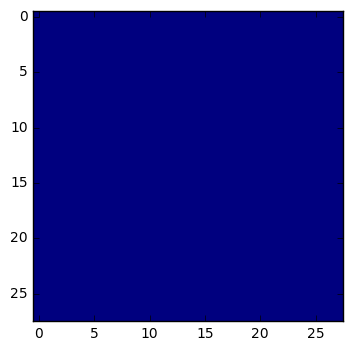

8 100 3819 392.0


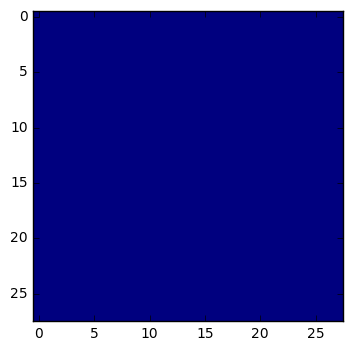

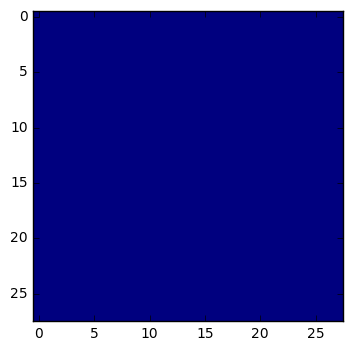

8 100 3832 392.0


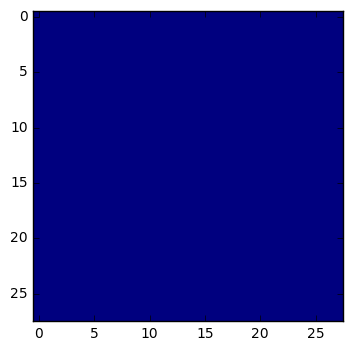

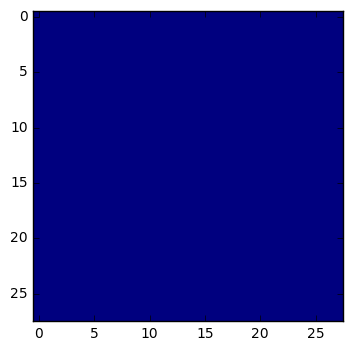

8 100 3840 392.0


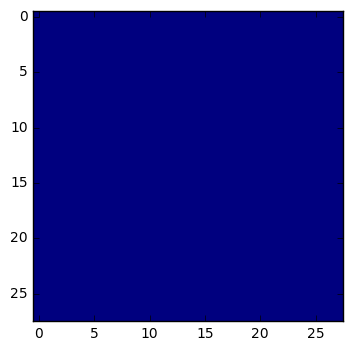

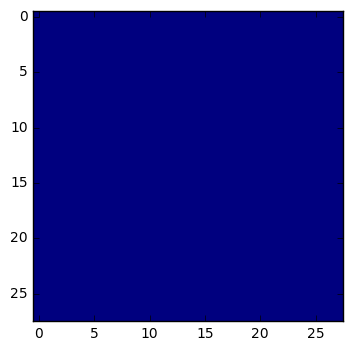

8 100 3902 392.0


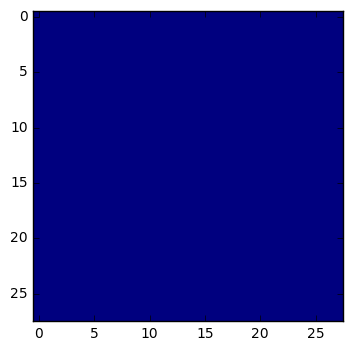

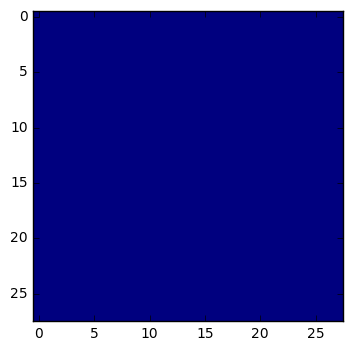

8 100 3954 392.0


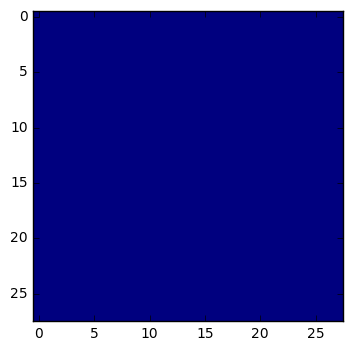

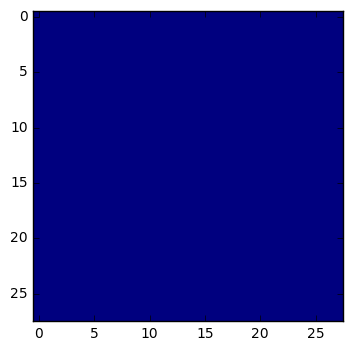

8 100 3984 392.0


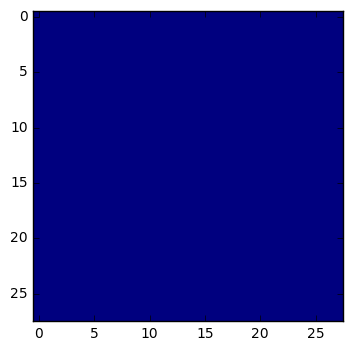

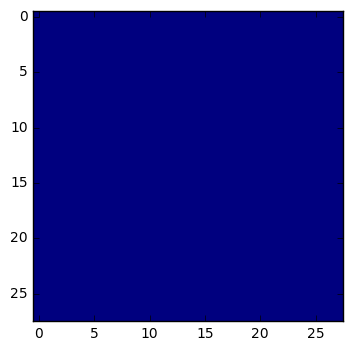

8 100 4244 392.0


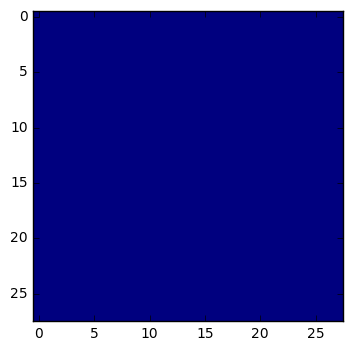

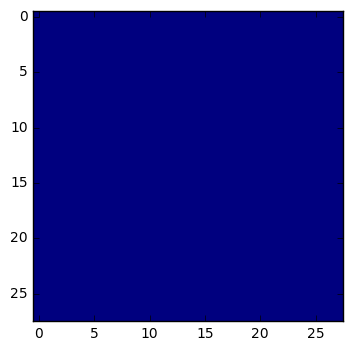

8 100 4298 392.0


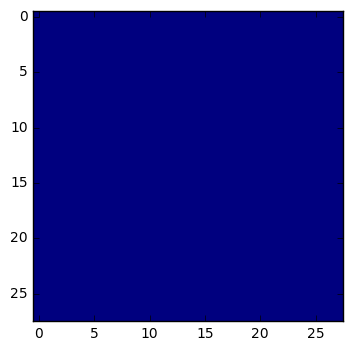

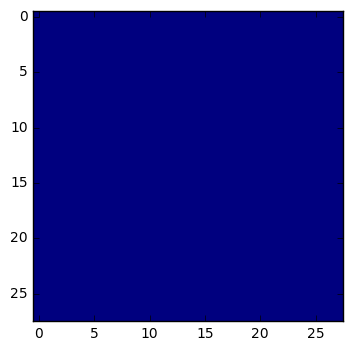

8 100 4331 392.0


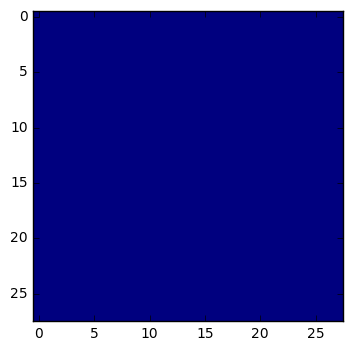

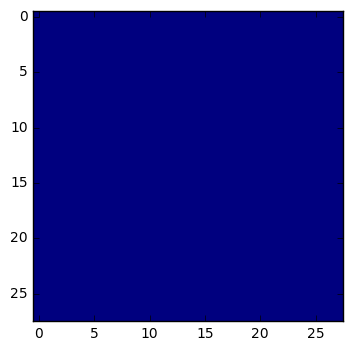

8 100 4526 392.0


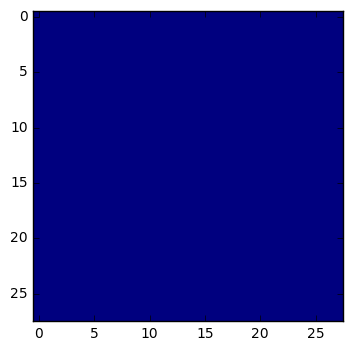

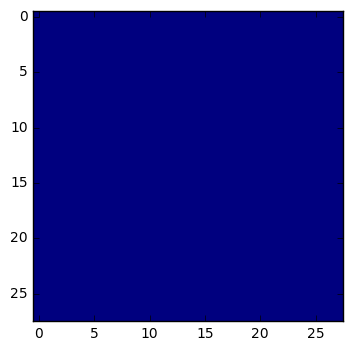

8 100 4558 392.0


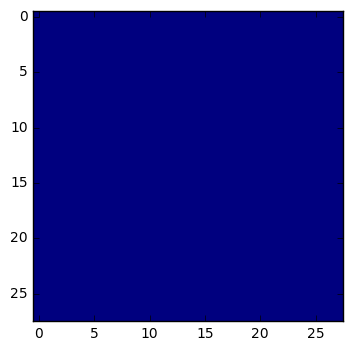

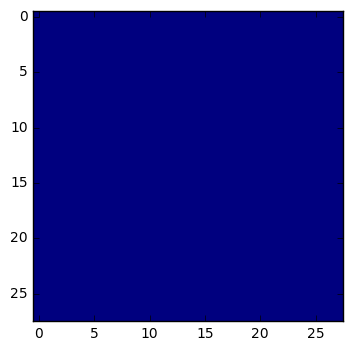

8 100 4717 392.0


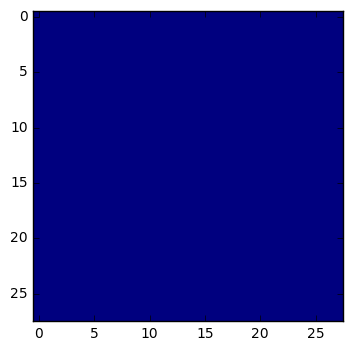

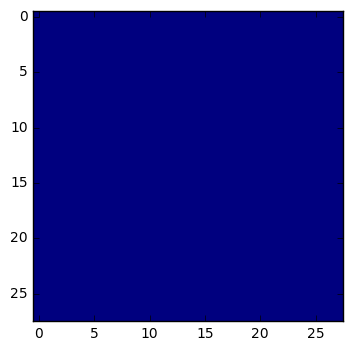

8 100 4720 392.0


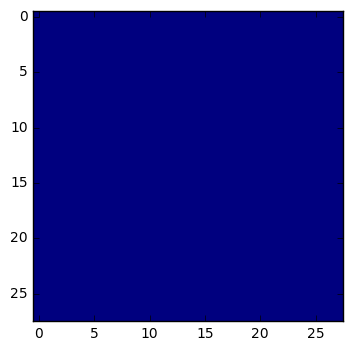

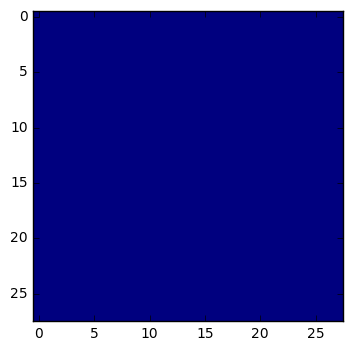

8 100 4735 392.0


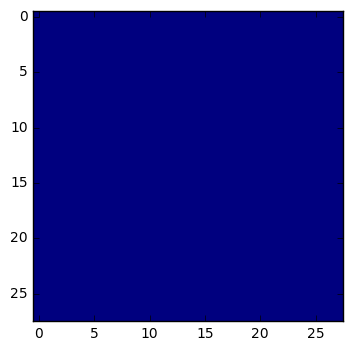

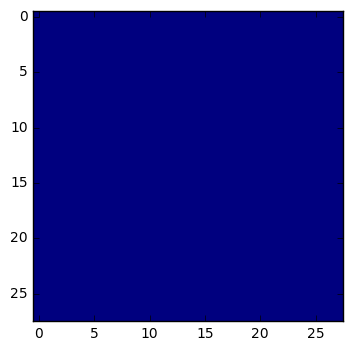

8 100 4789 392.0


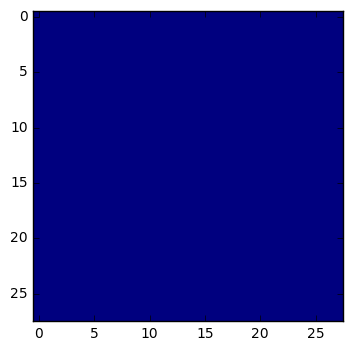

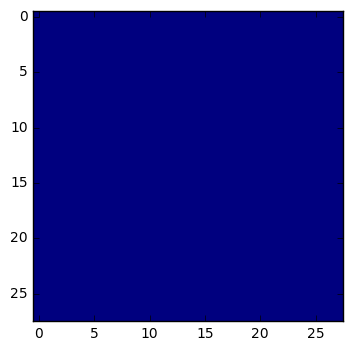

8 100 4879 392.0


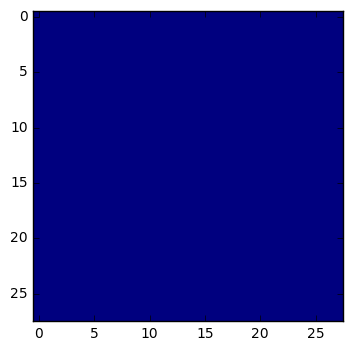

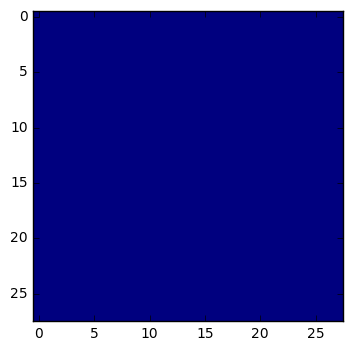

8 100 4942 392.0


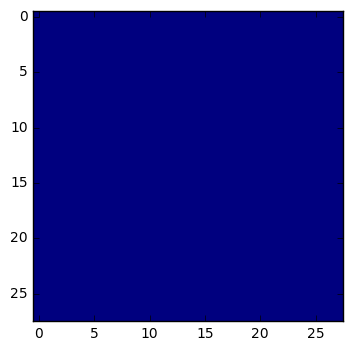

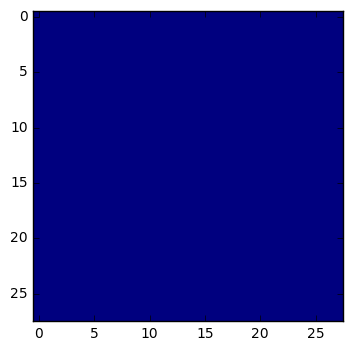

8 100 5041 392.0


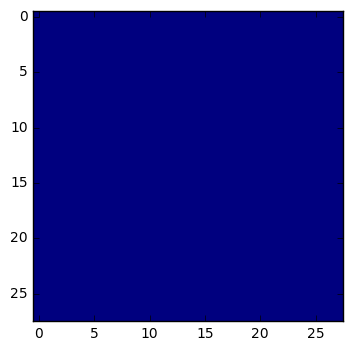

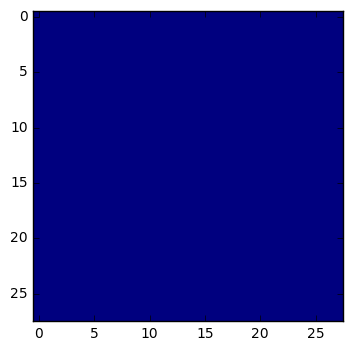

8 100 5157 392.0


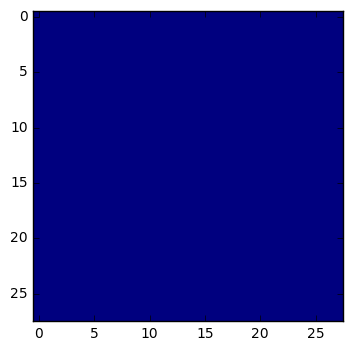

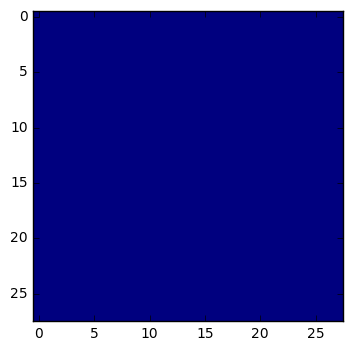

8 100 5167 392.0


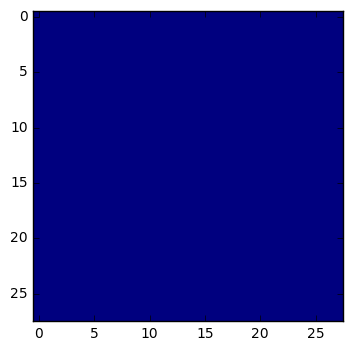

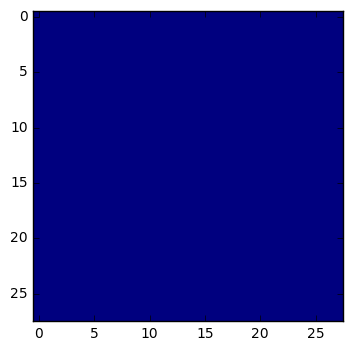

8 100 5173 392.0


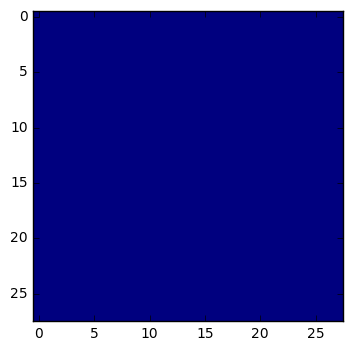

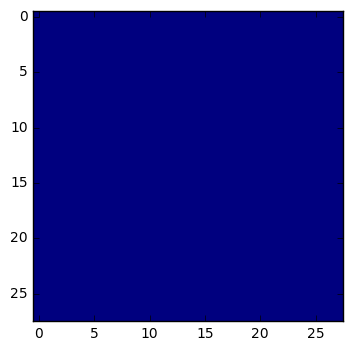

8 100 5398 392.0


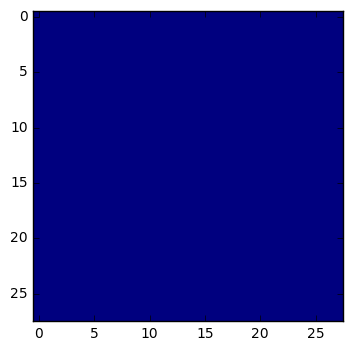

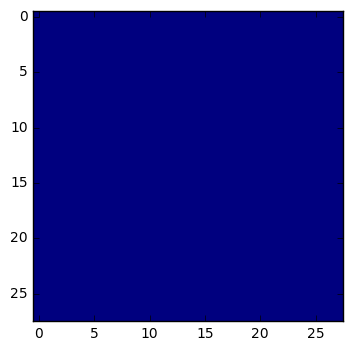

8 100 5548 392.0


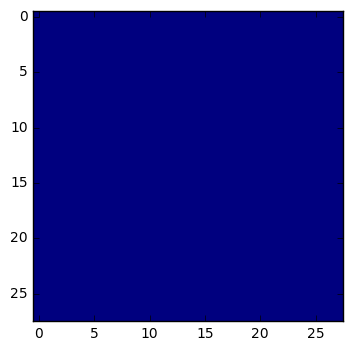

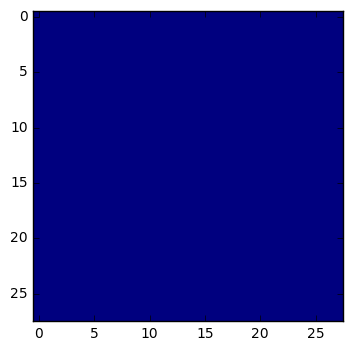

8 100 5580 392.0


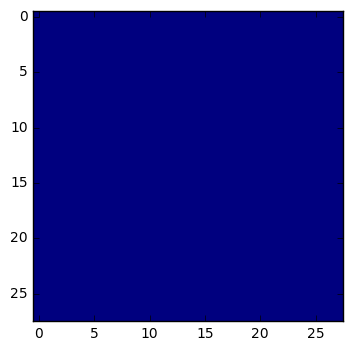

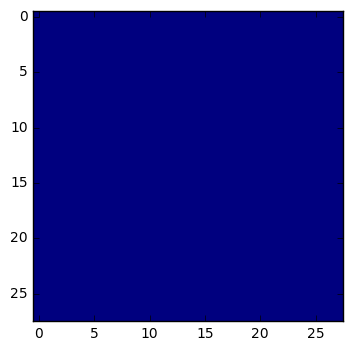

8 100 5604 392.0


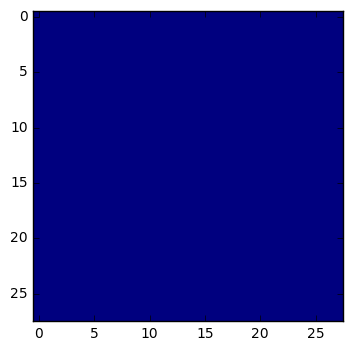

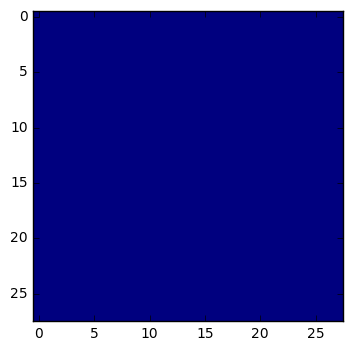

8 100 5618 392.0


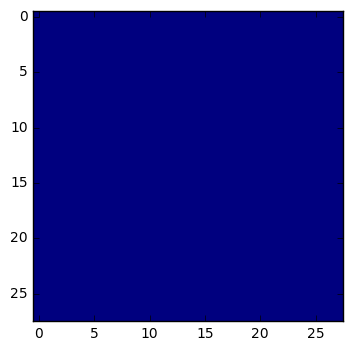

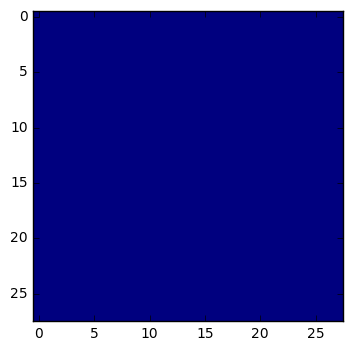

8 100 5787 392.0


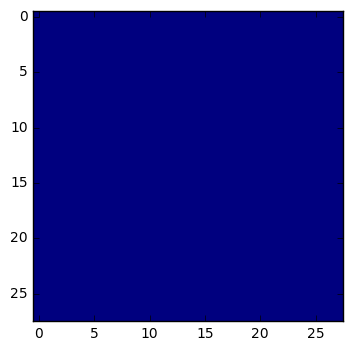

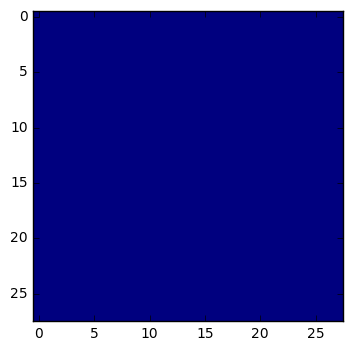

8 100 5803 392.0


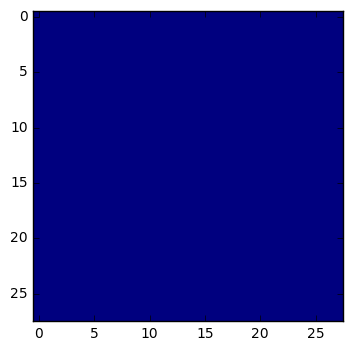

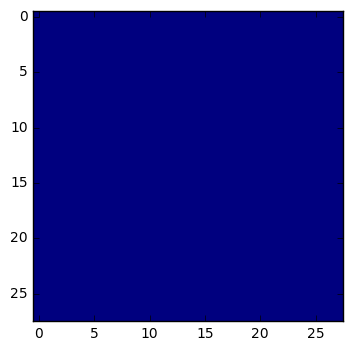

8 100 5837 392.0


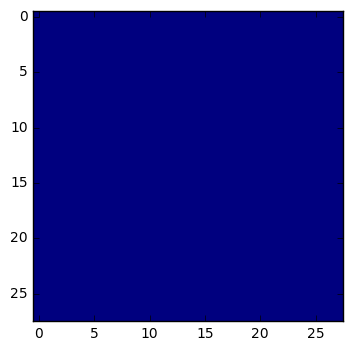

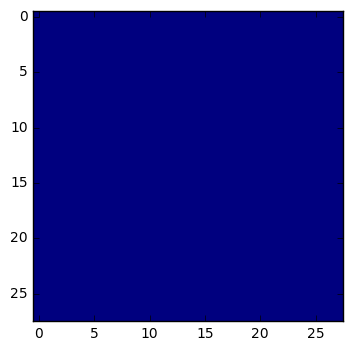

8 100 5882 392.0


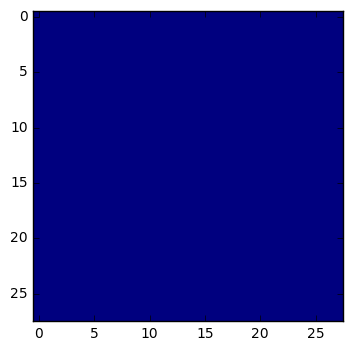

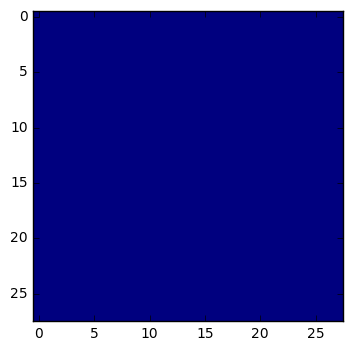

8 100 5940 392.0


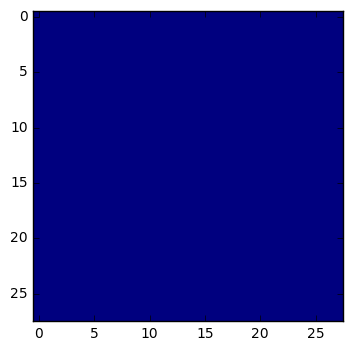

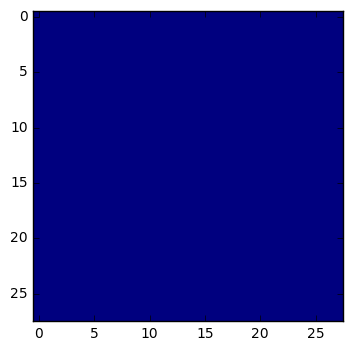

8 100 5992 392.0


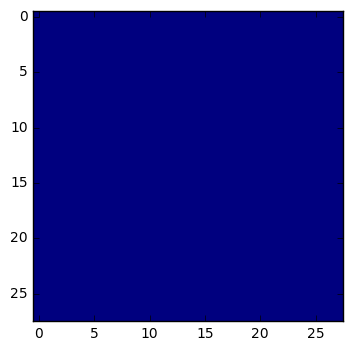

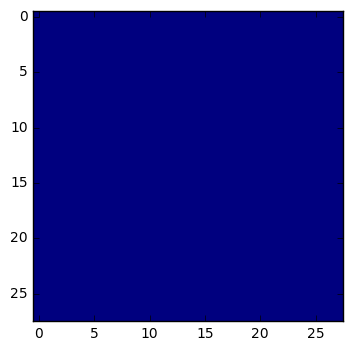

8 100 6046 392.0


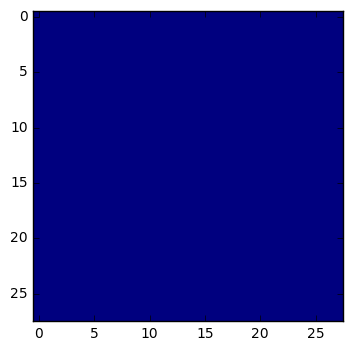

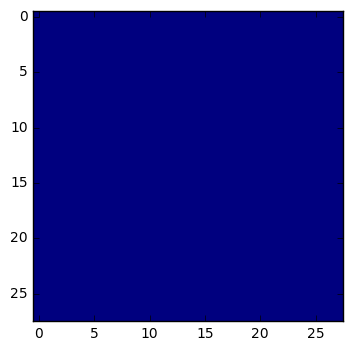

8 100 6098 392.0


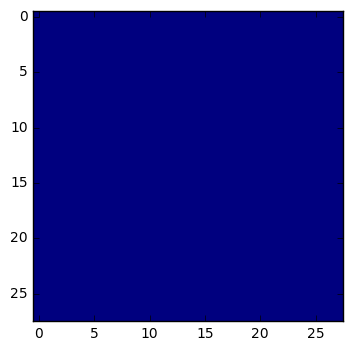

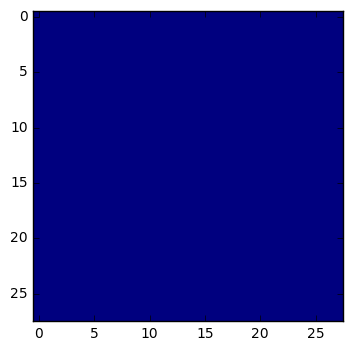

8 100 6140 392.0


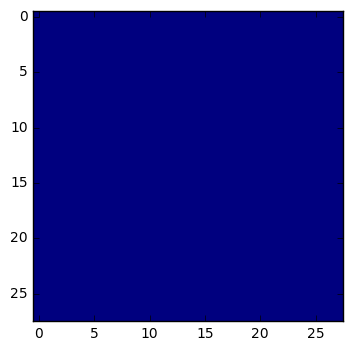

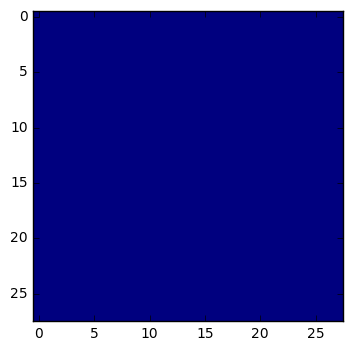

8 100 6211 392.0


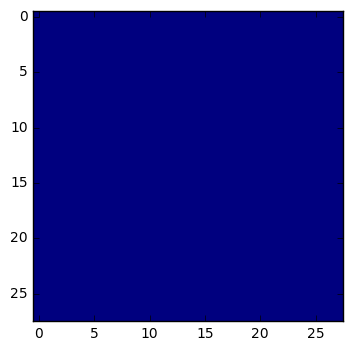

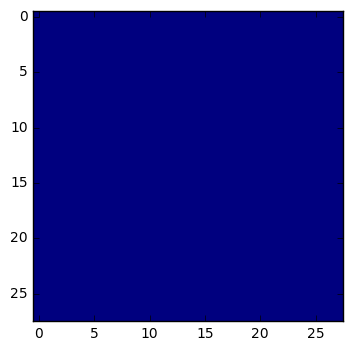

8 100 6443 392.0


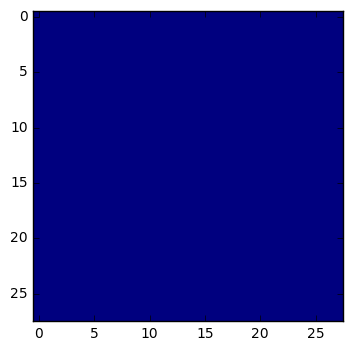

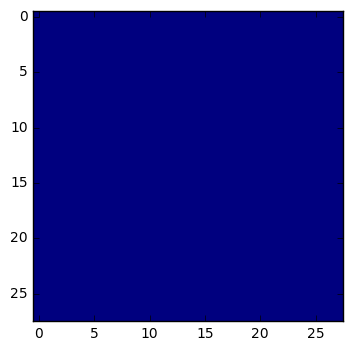

8 100 6488 392.0


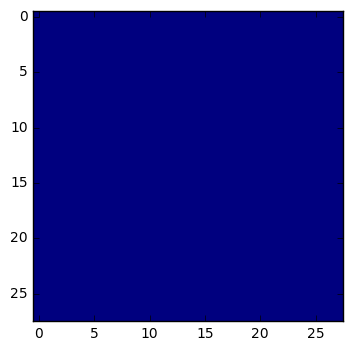

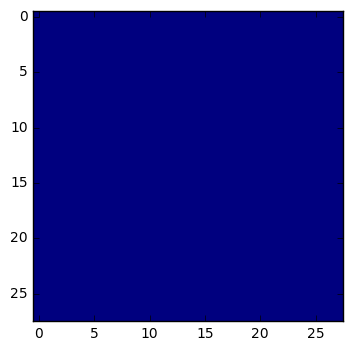

8 100 6507 392.0


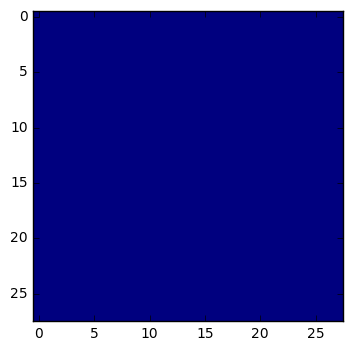

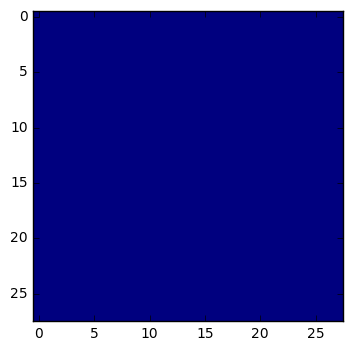

8 100 6580 392.0


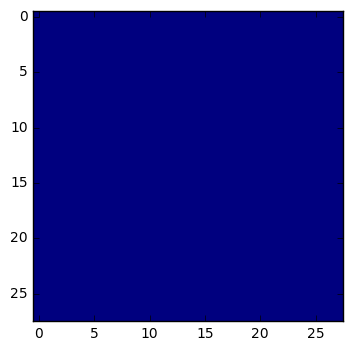

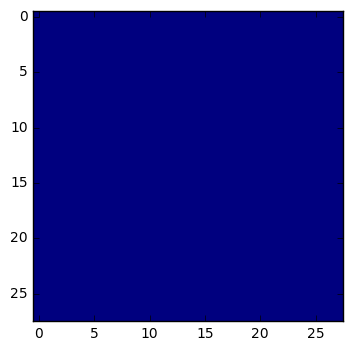

8 100 6597 392.0


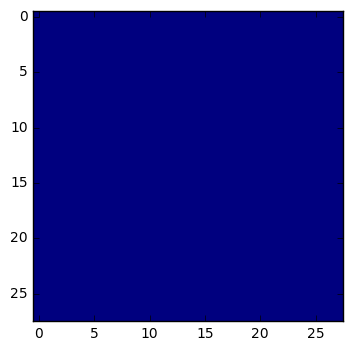

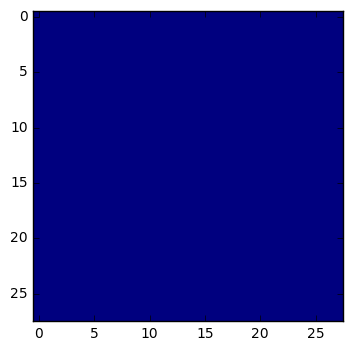

8 100 6723 392.0


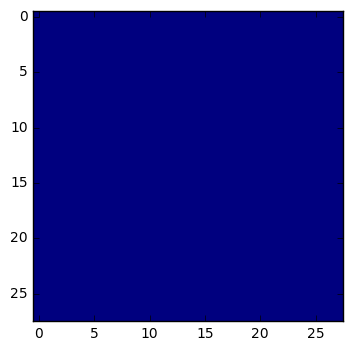

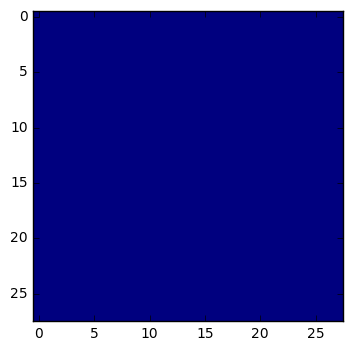

8 100 6741 392.0


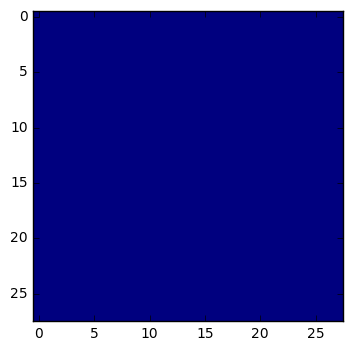

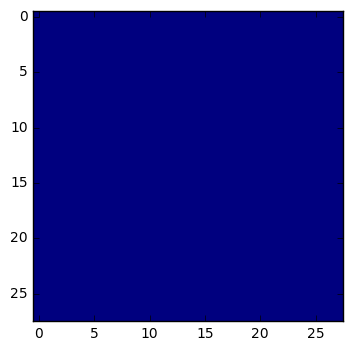

8 100 6829 392.0


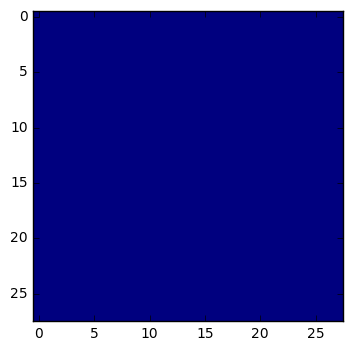

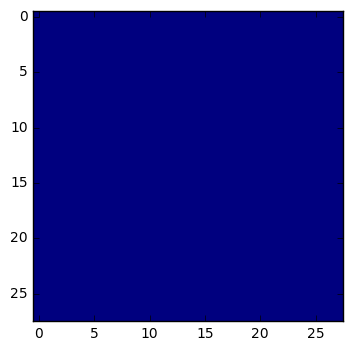

8 100 6845 392.0


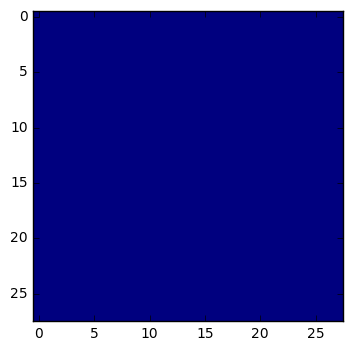

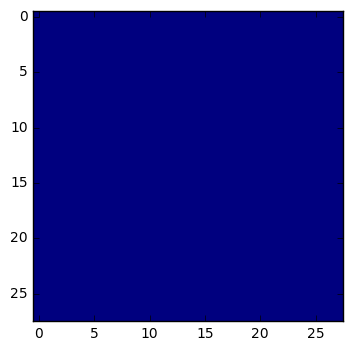

8 100 6860 392.0


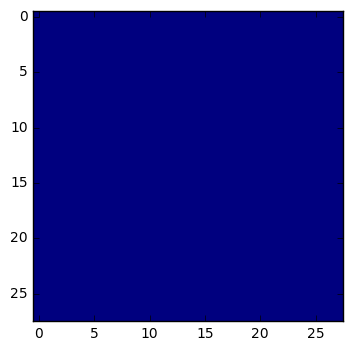

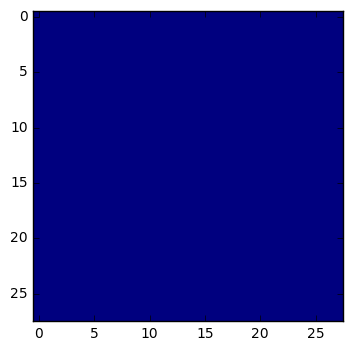

8 100 6916 392.0


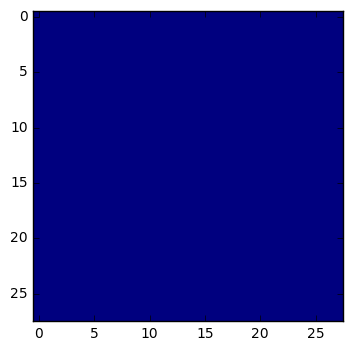

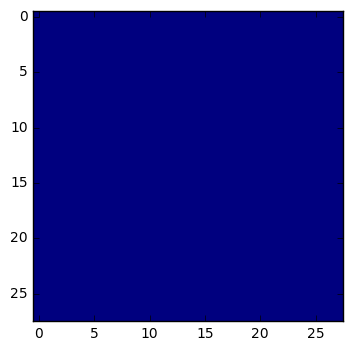

8 100 6921 392.0


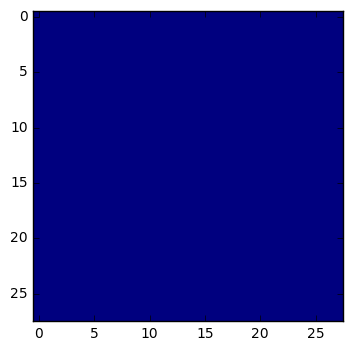

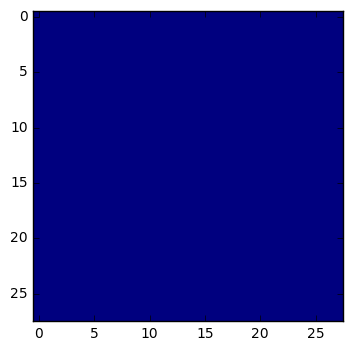

8 100 7054 392.0


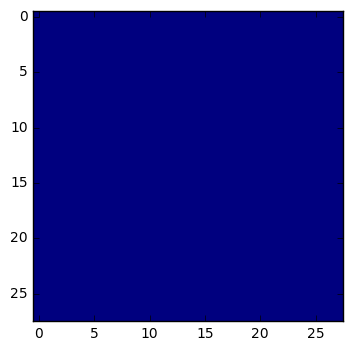

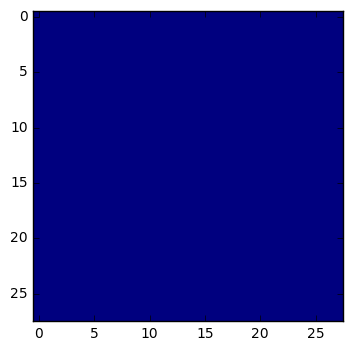

8 100 7147 392.0


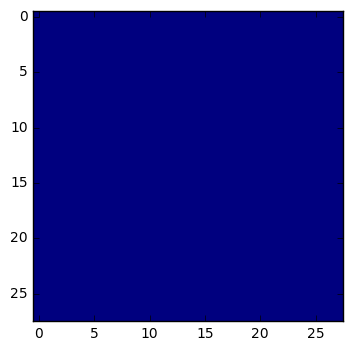

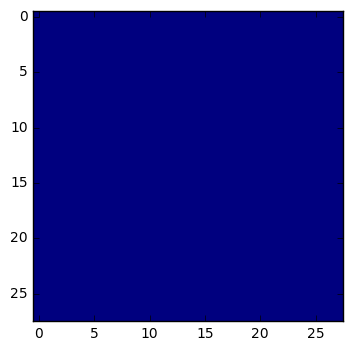

8 100 7185 392.0


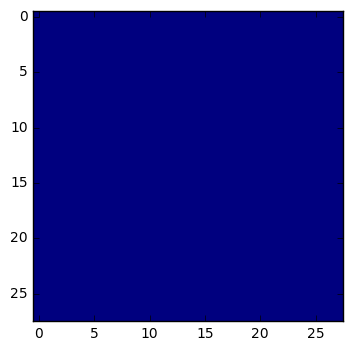

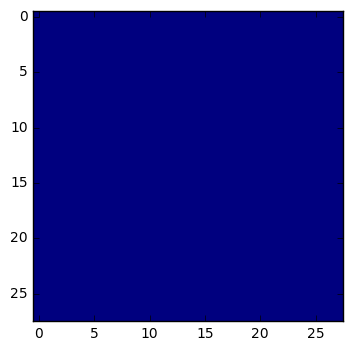

8 100 7188 392.0


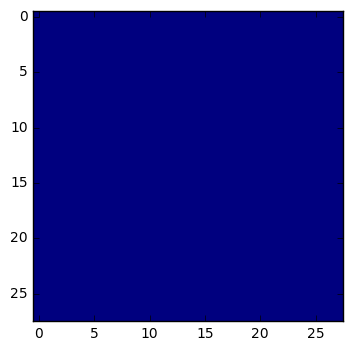

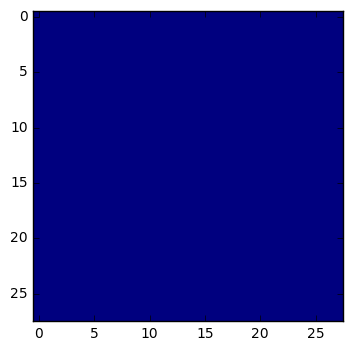

8 100 7229 392.0


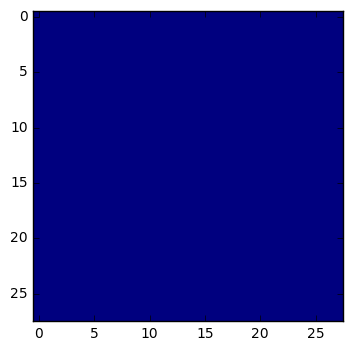

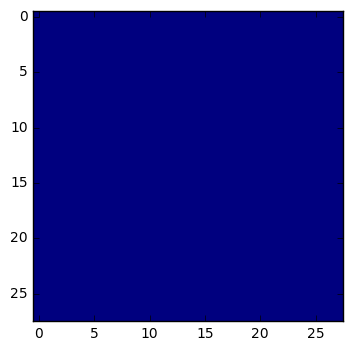

8 100 7252 392.0


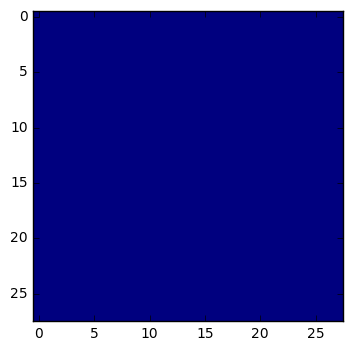

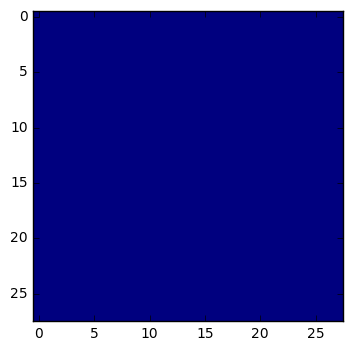

8 100 7402 392.0


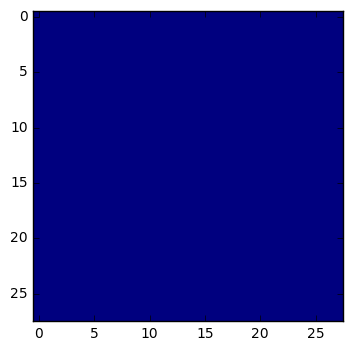

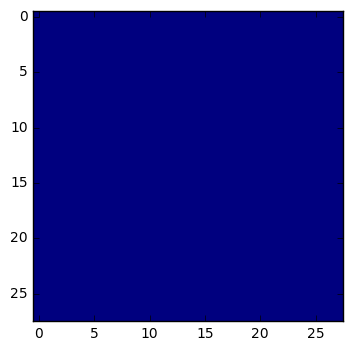

8 100 7631 392.0


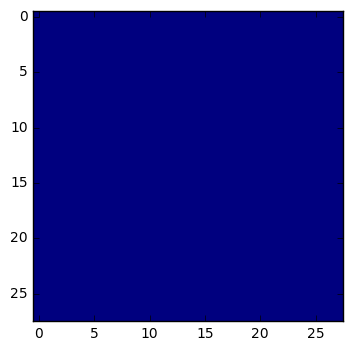

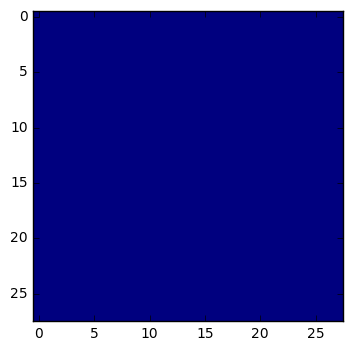

8 100 7678 392.0


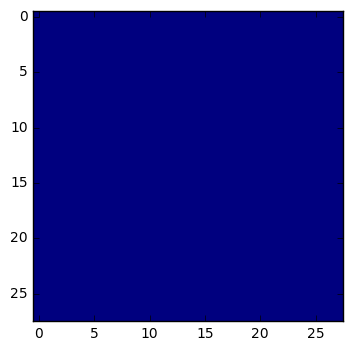

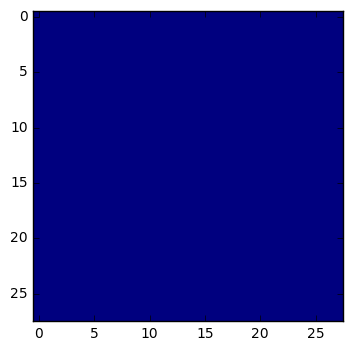

8 100 7929 392.0


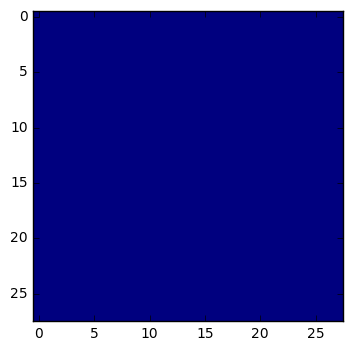

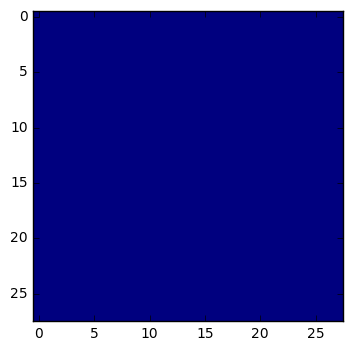

8 100 7972 392.0


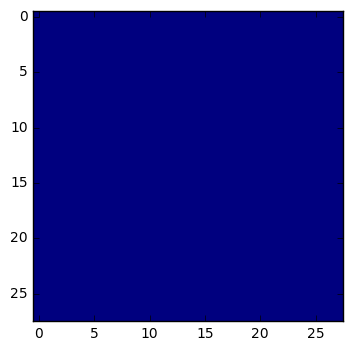

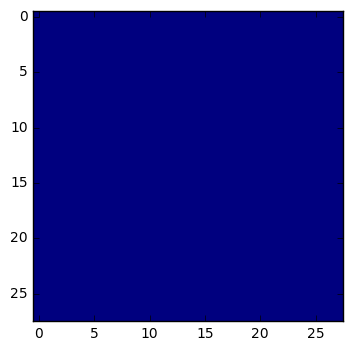

8 100 8050 392.0


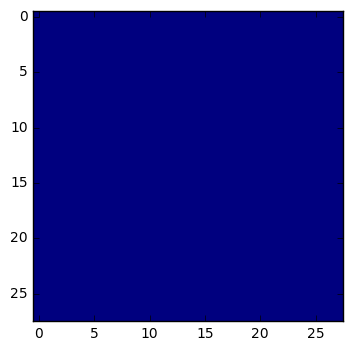

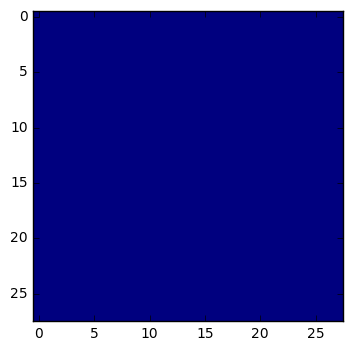

8 100 8089 392.0


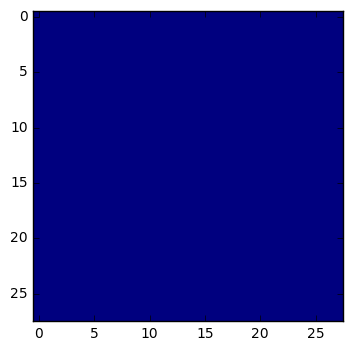

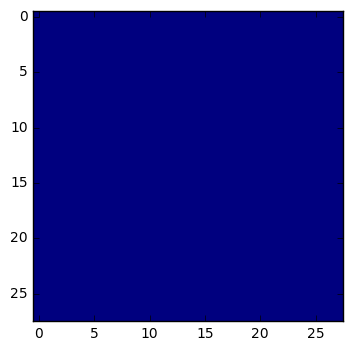

8 100 8198 392.0


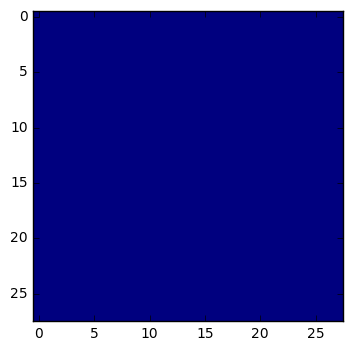

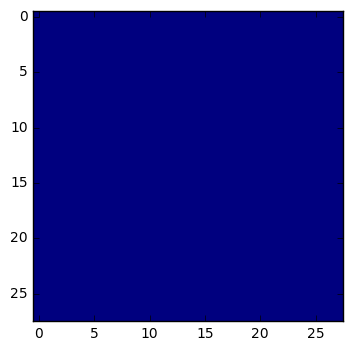

8 100 8404 392.0


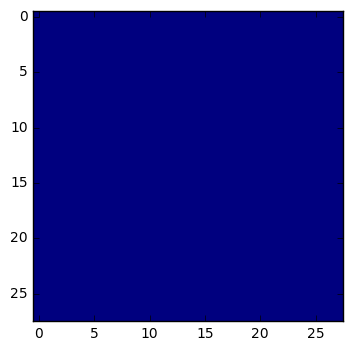

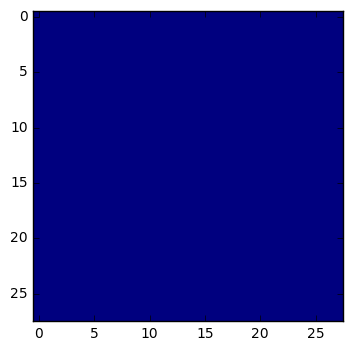

8 100 8531 392.0


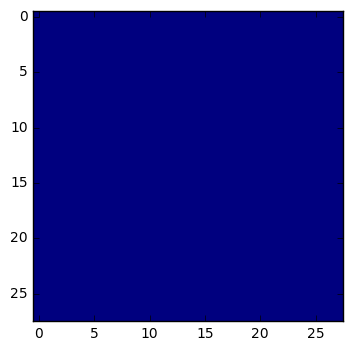

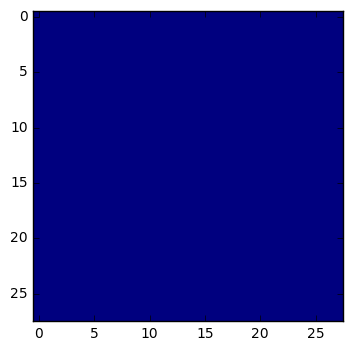

8 100 8681 392.0


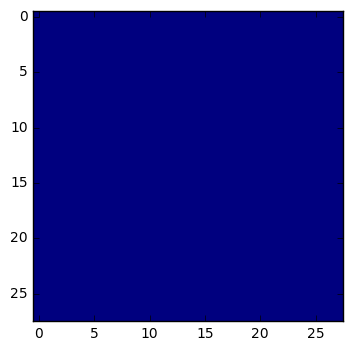

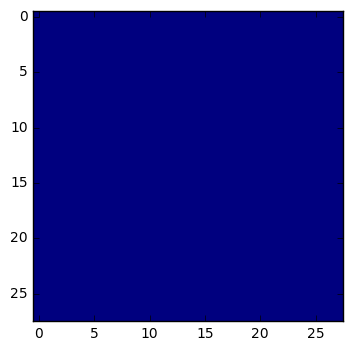

8 100 8827 392.0


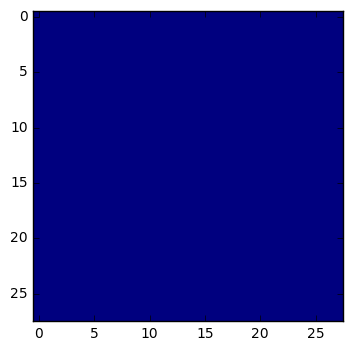

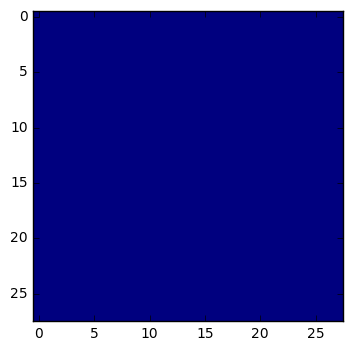

8 100 8894 392.0


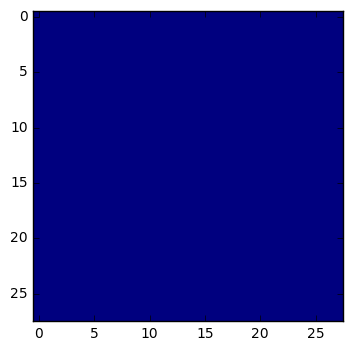

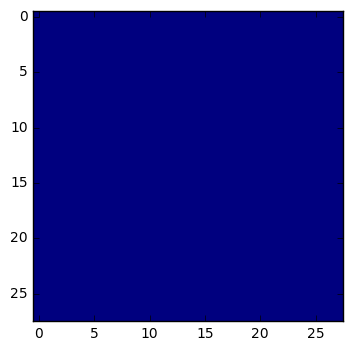

8 100 8957 392.0


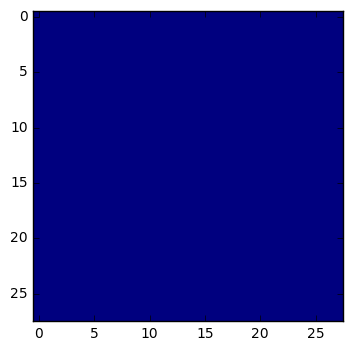

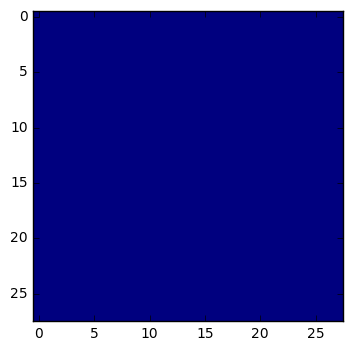

8 100 9035 392.0


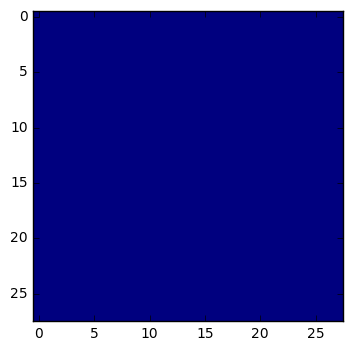

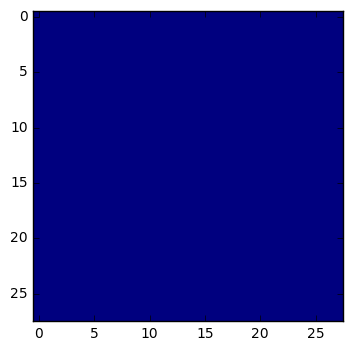

8 100 9250 392.0


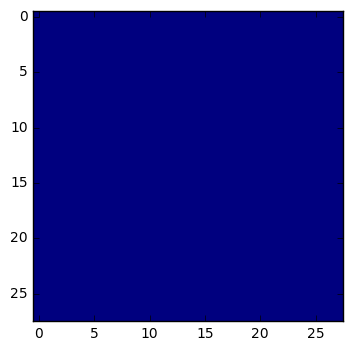

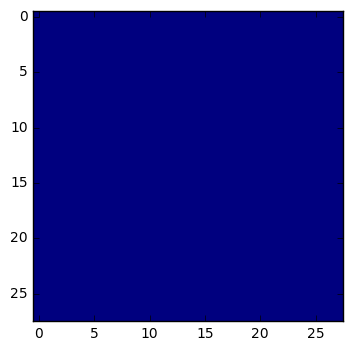

8 100 9308 392.0


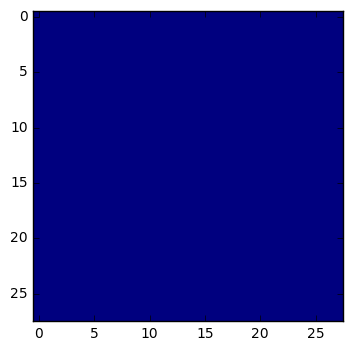

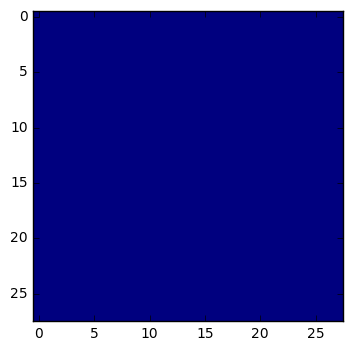

8 100 9418 392.0


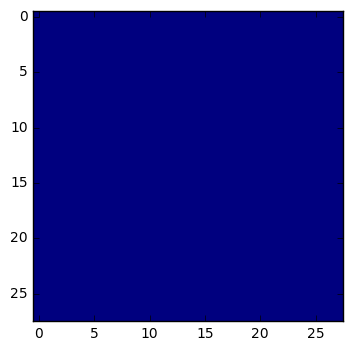

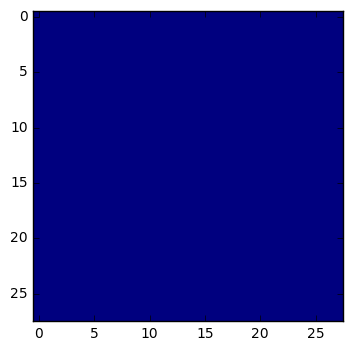

8 100 9442 392.0


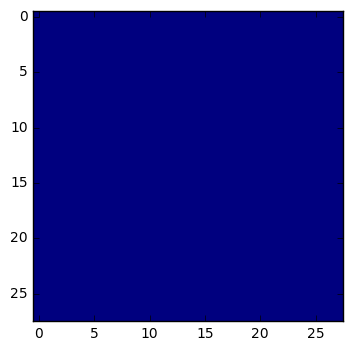

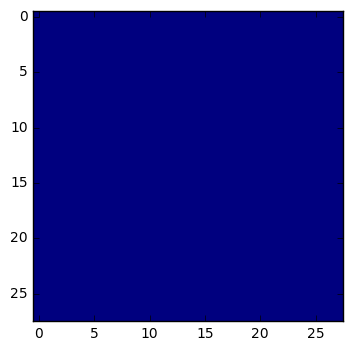

8 100 9444 392.0


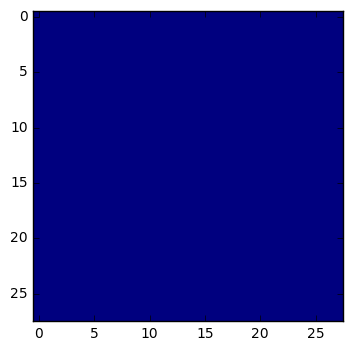

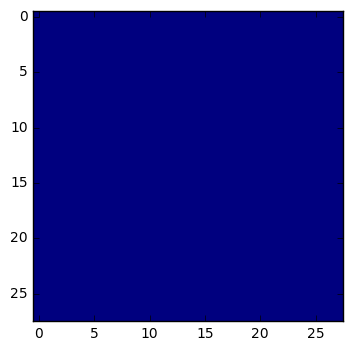

8 100 9479 392.0


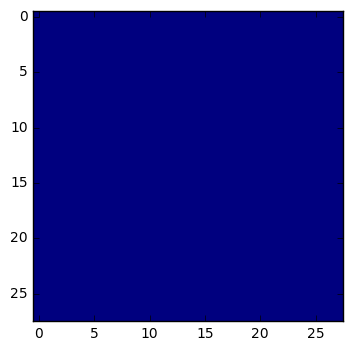

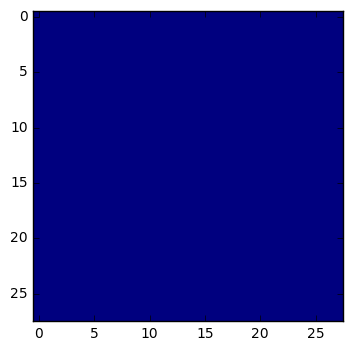

8 100 9522 392.0


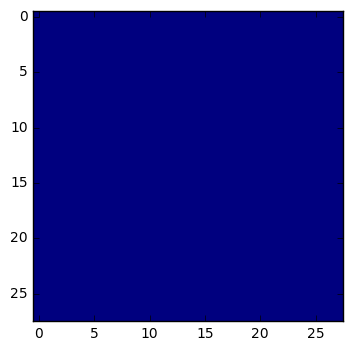

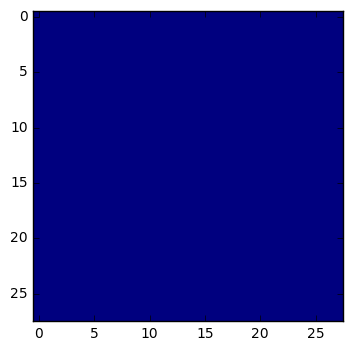

8 100 9596 392.0


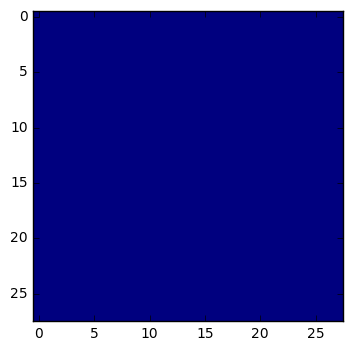

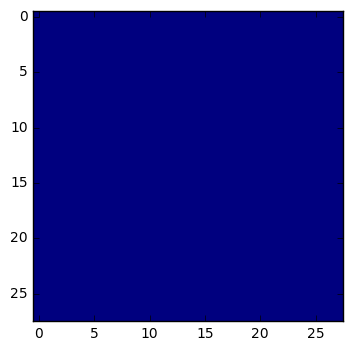

8 100 9693 392.0


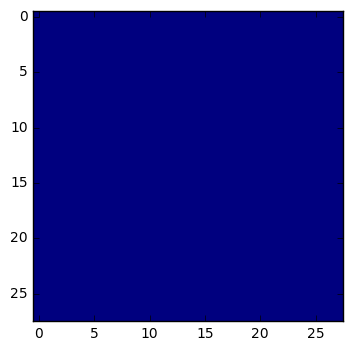

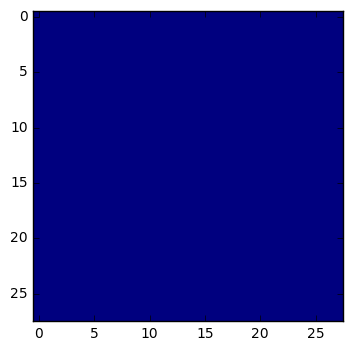

8 100 9712 392.0


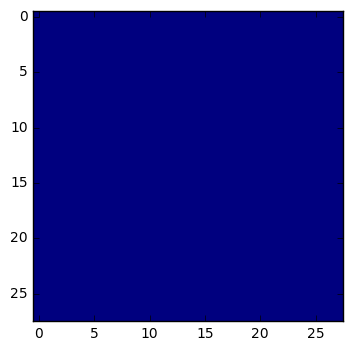

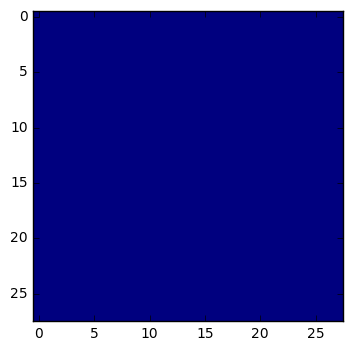

8 100 9775 392.0


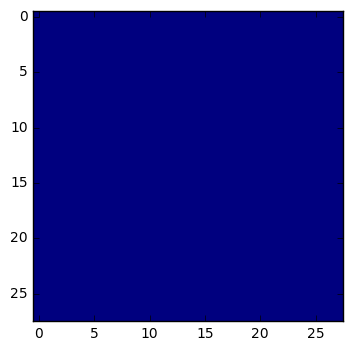

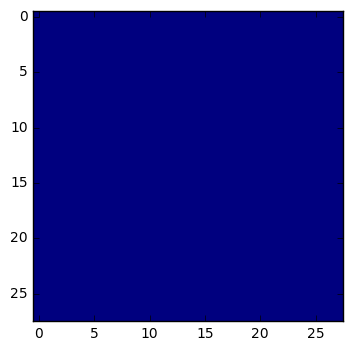

8 100 9850 392.0


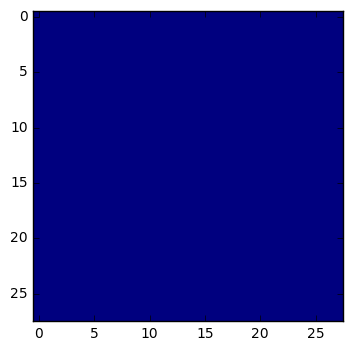

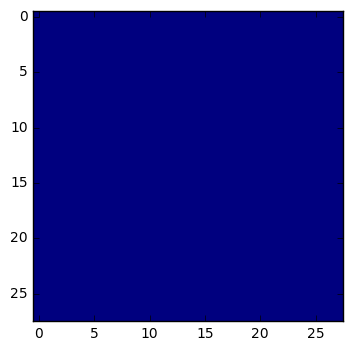

5 115 9619 -198.012


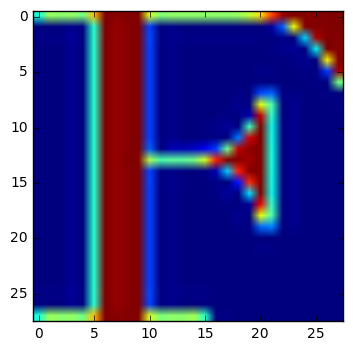

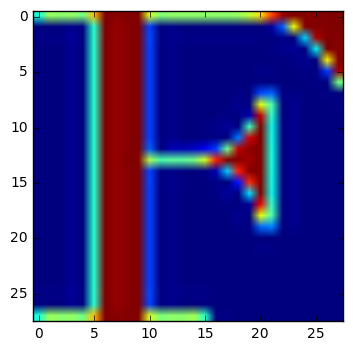

2 176 6850 -184.62


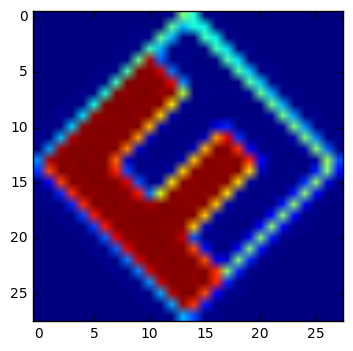

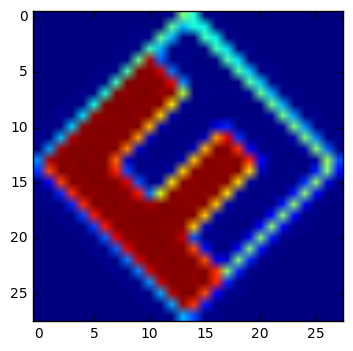

2 204 4725 109.616


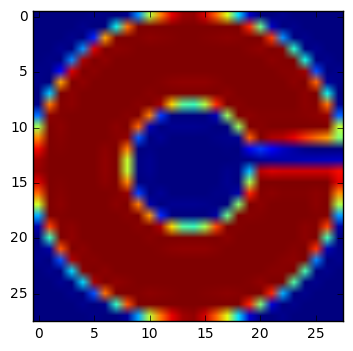

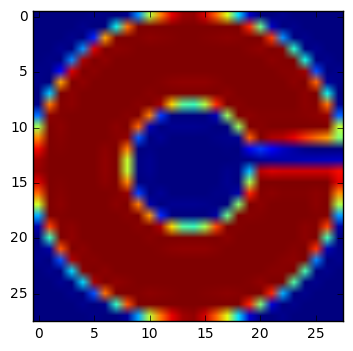

8 223 125 392.0


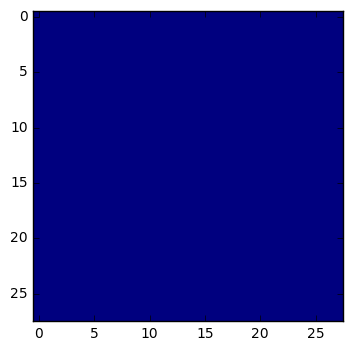

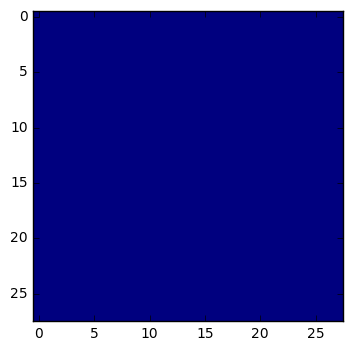

8 223 155 392.0


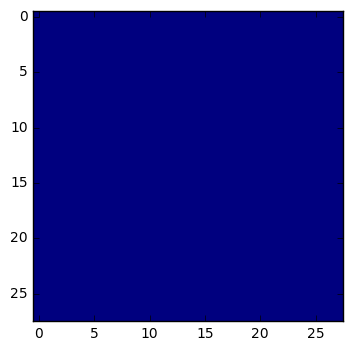

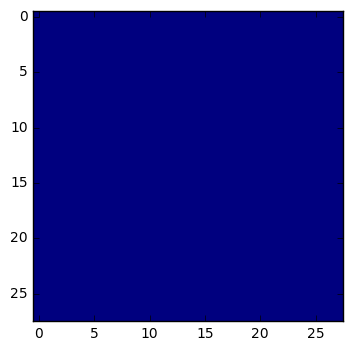

8 223 373 392.0


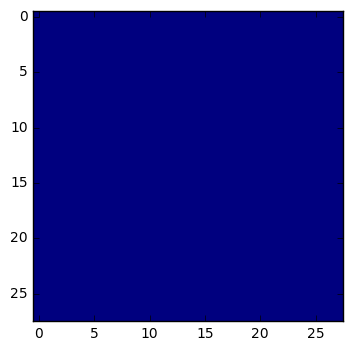

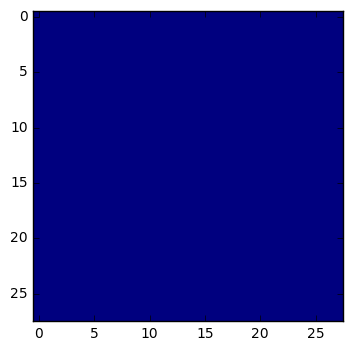

8 223 383 392.0


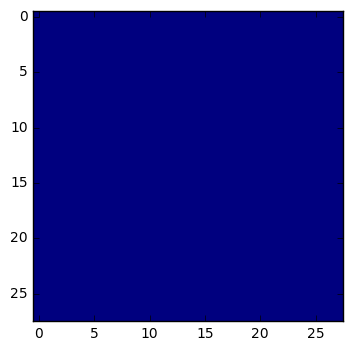

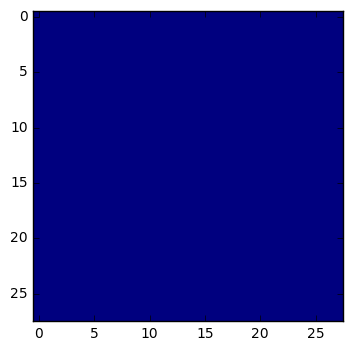

8 223 393 392.0


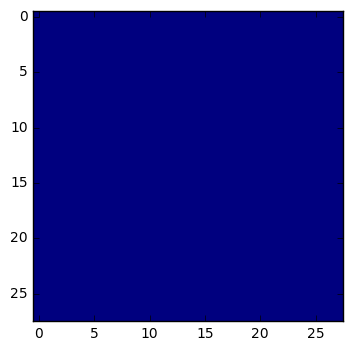

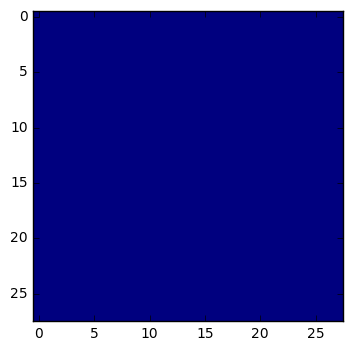

8 223 407 392.0


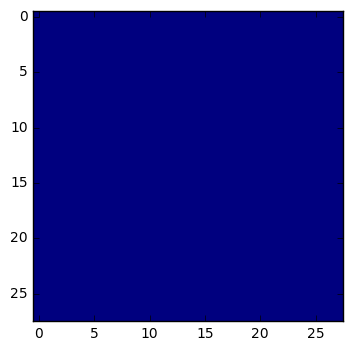

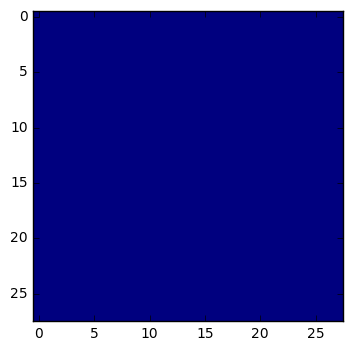

8 223 640 392.0


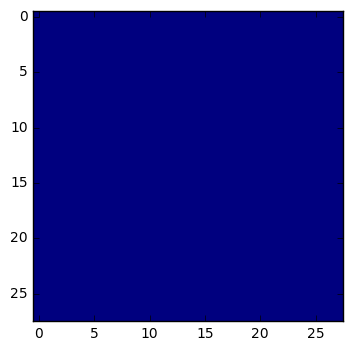

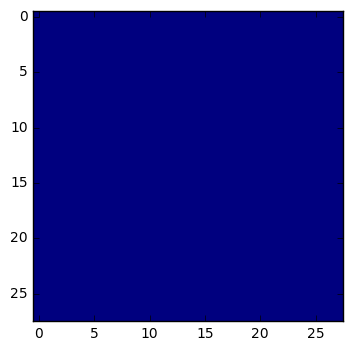

8 223 672 392.0


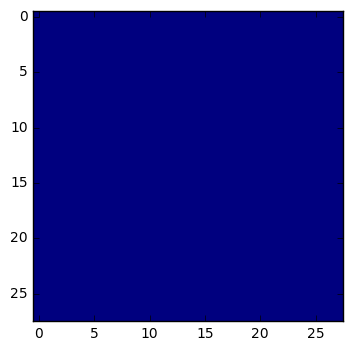

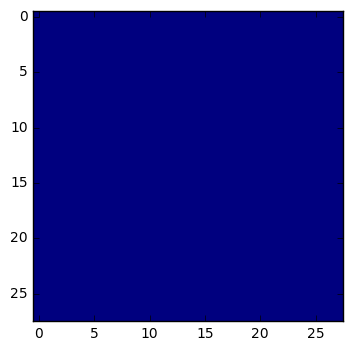

8 223 709 392.0


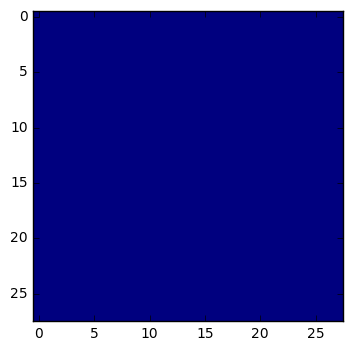

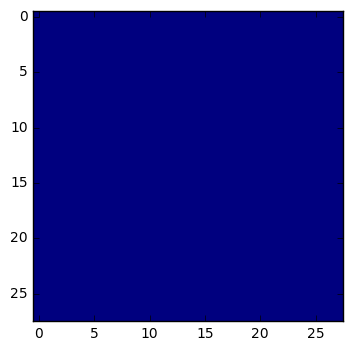

8 223 745 392.0


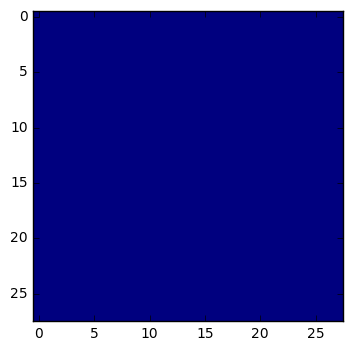

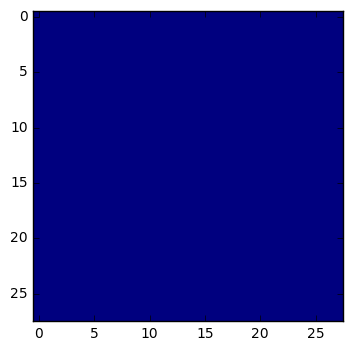

8 223 780 392.0


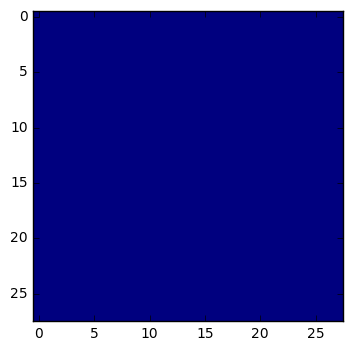

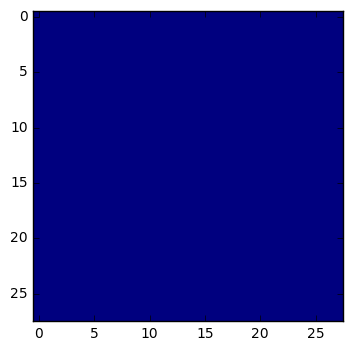

8 223 914 392.0


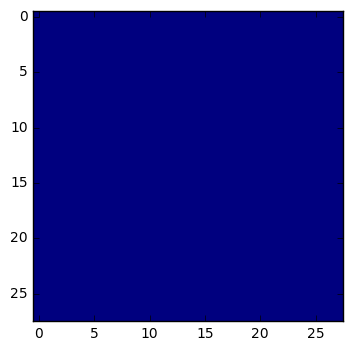

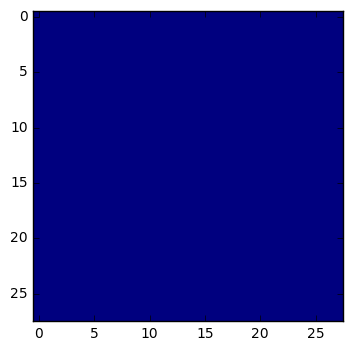

8 223 965 392.0


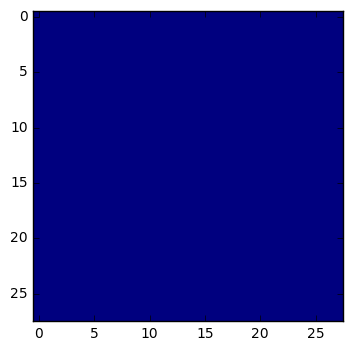

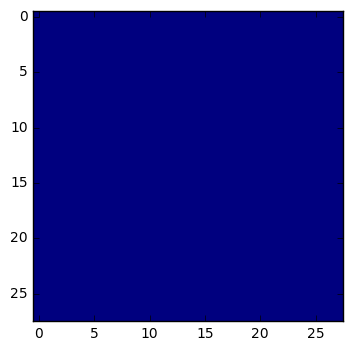

8 223 1048 392.0


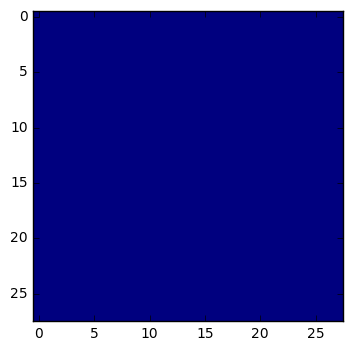

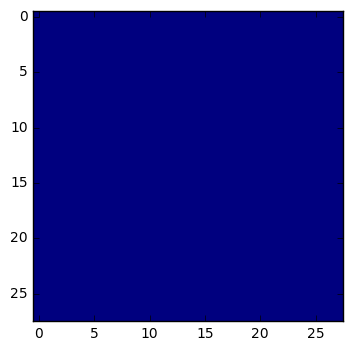

8 223 1127 392.0


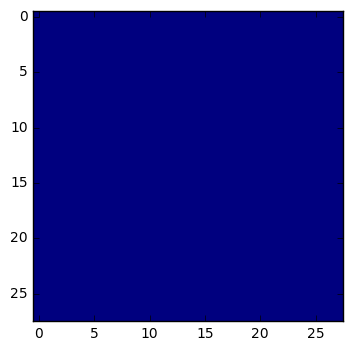

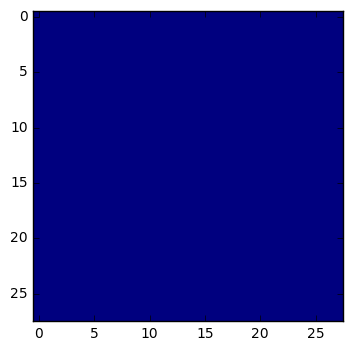

8 223 1182 392.0


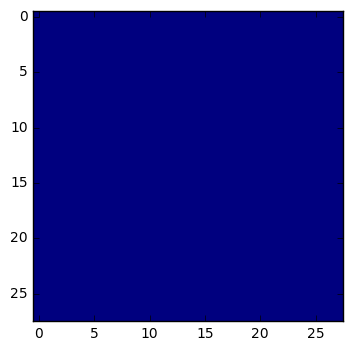

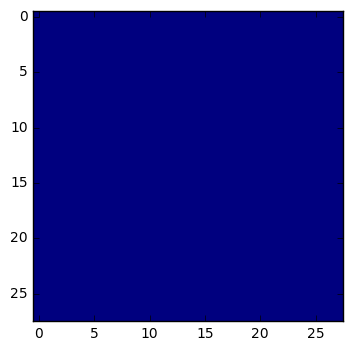

8 223 1209 392.0


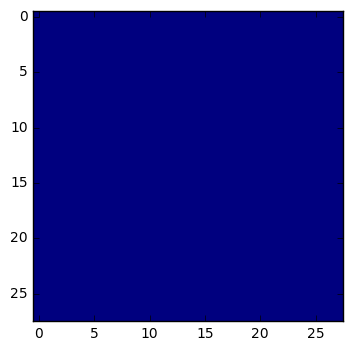

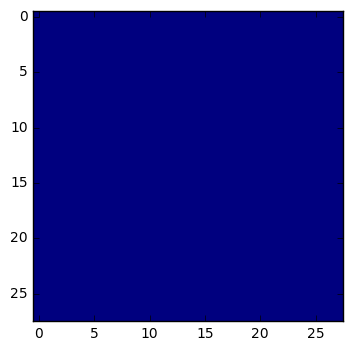

8 223 1251 392.0


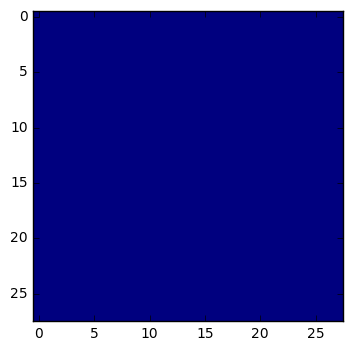

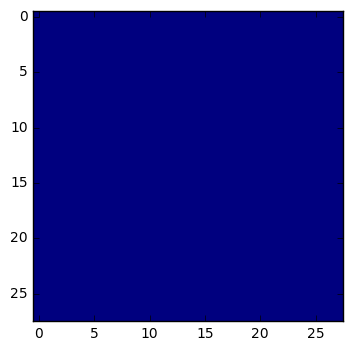

8 223 1348 392.0


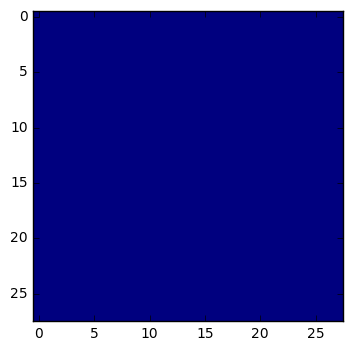

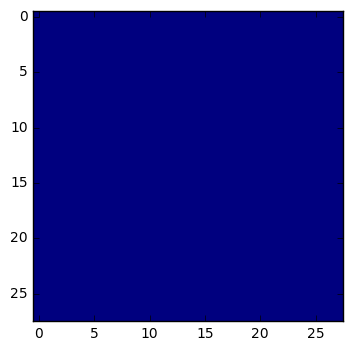

8 223 1387 392.0


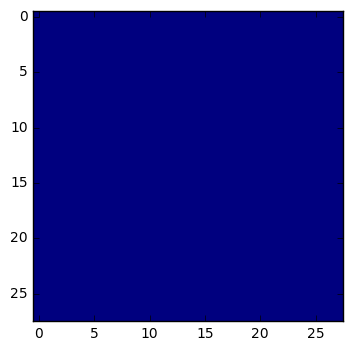

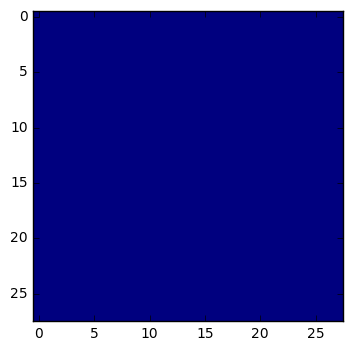

8 223 1390 392.0


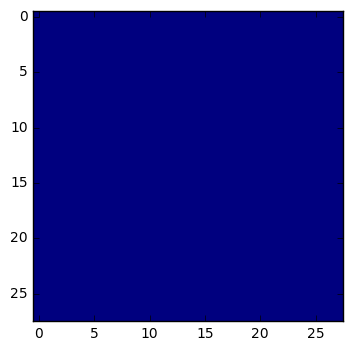

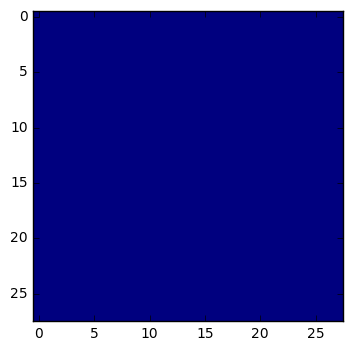

8 223 1437 392.0


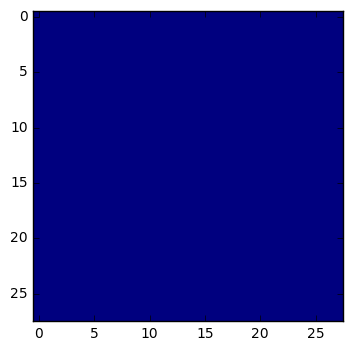

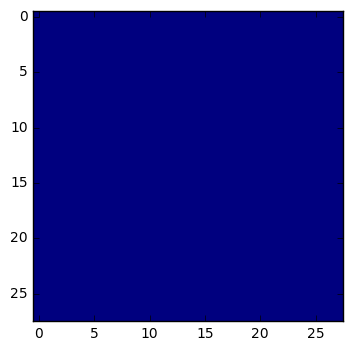

8 223 1513 392.0


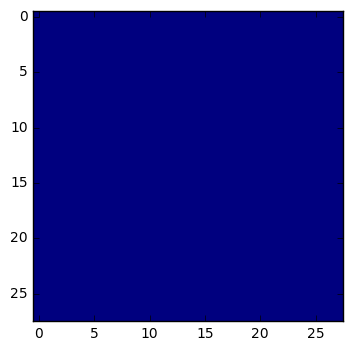

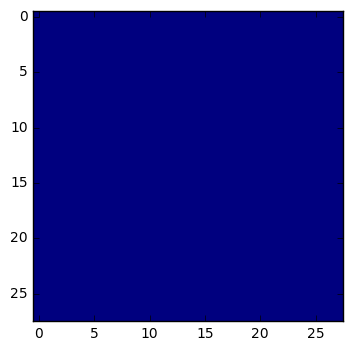

8 223 1547 392.0


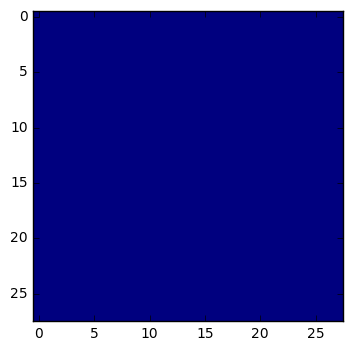

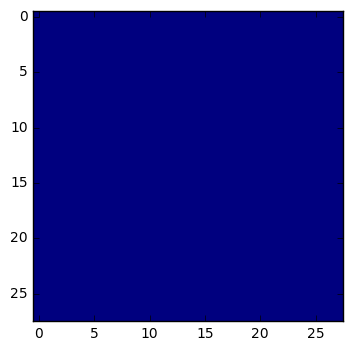

8 223 1585 392.0


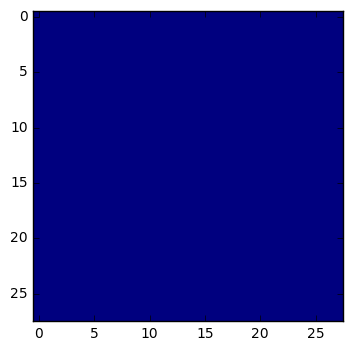

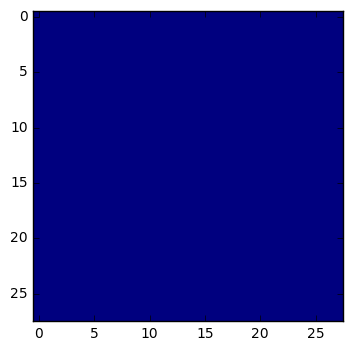

8 223 1693 392.0


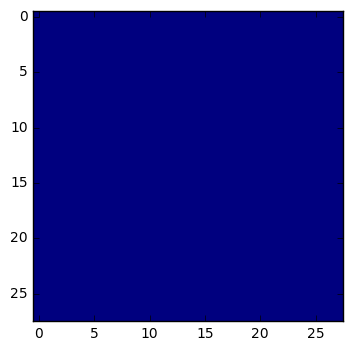

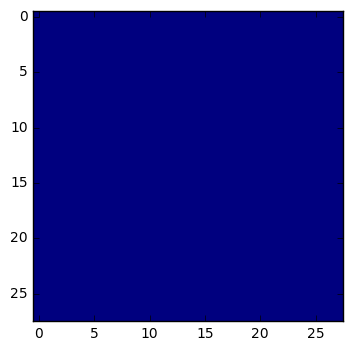

8 223 1791 392.0


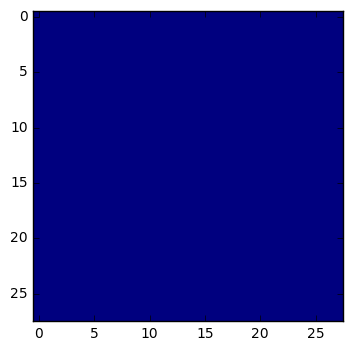

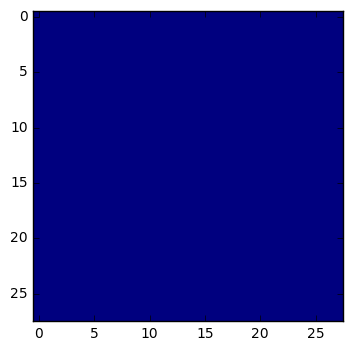

8 223 1867 392.0


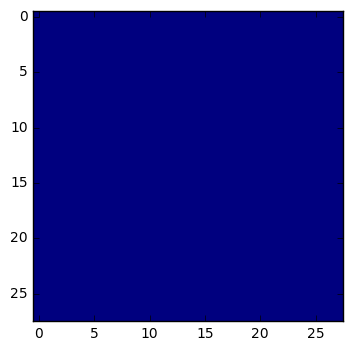

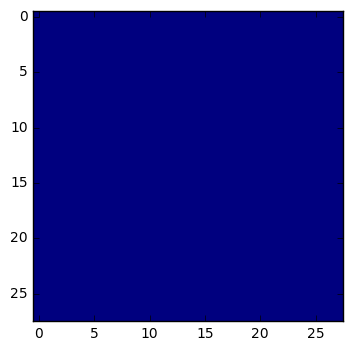

8 223 1941 392.0


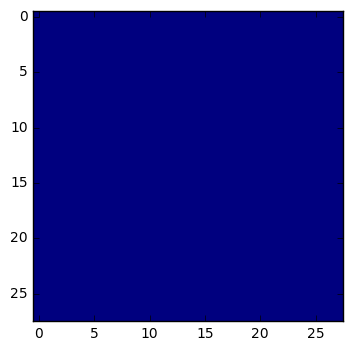

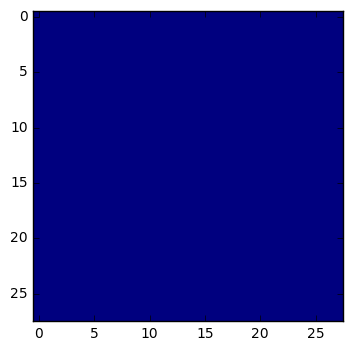

8 223 2003 392.0


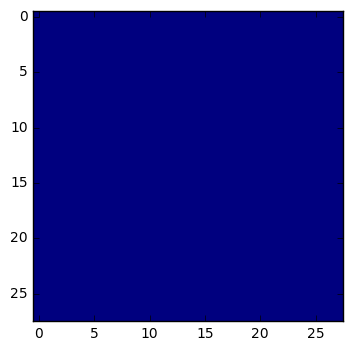

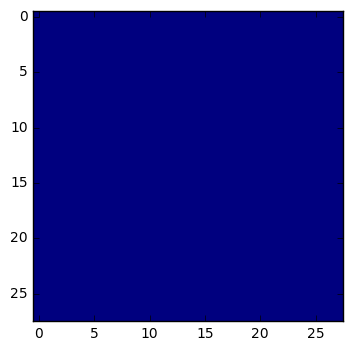

8 223 2042 392.0


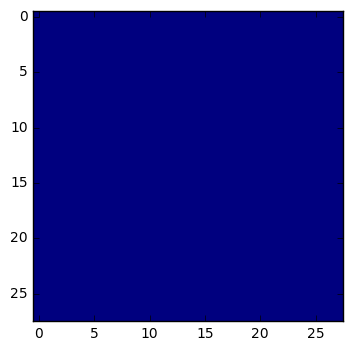

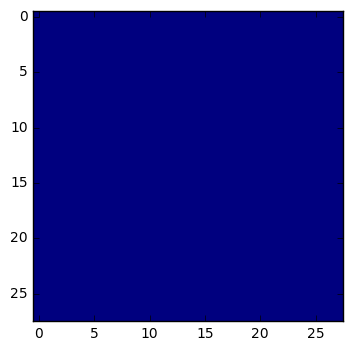

8 223 2090 392.0


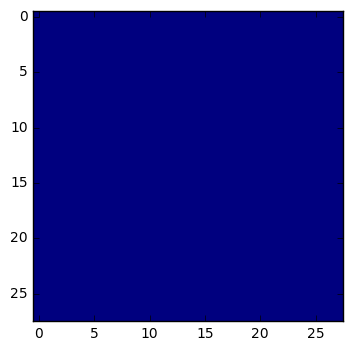

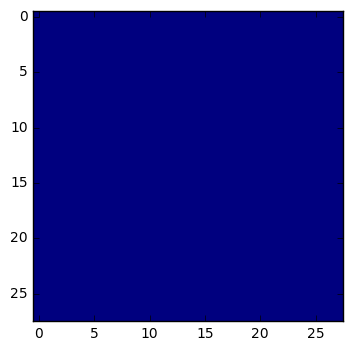

8 223 2118 392.0


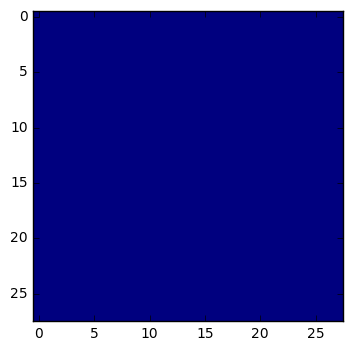

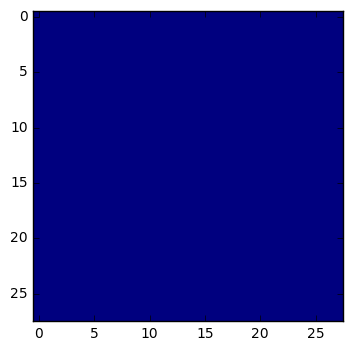

8 223 2168 392.0


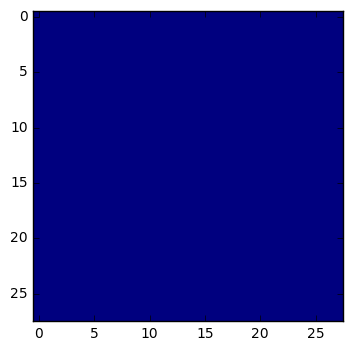

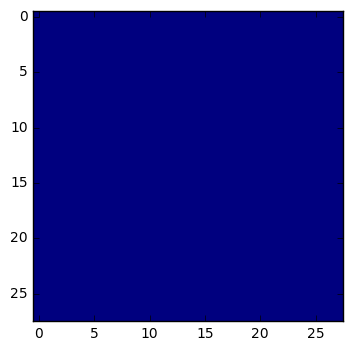

8 223 2248 392.0


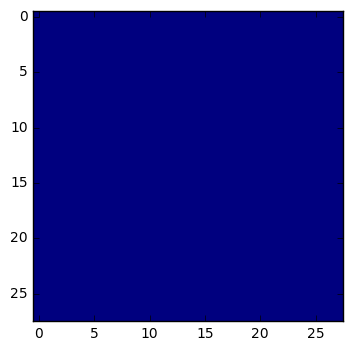

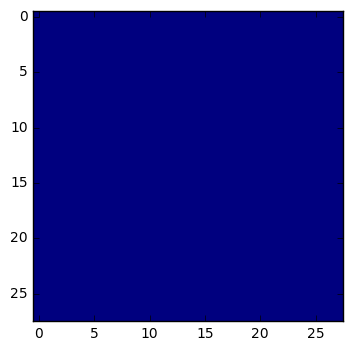

8 223 2312 392.0


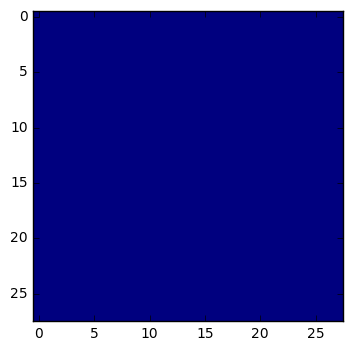

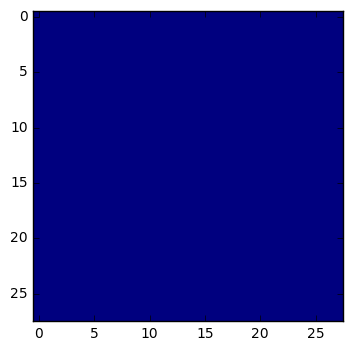

8 223 2449 392.0


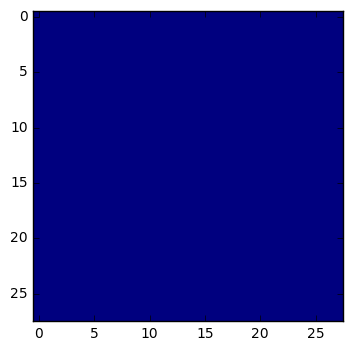

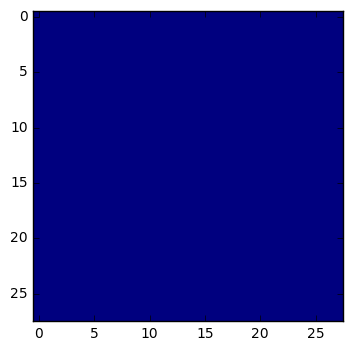

8 223 2753 392.0


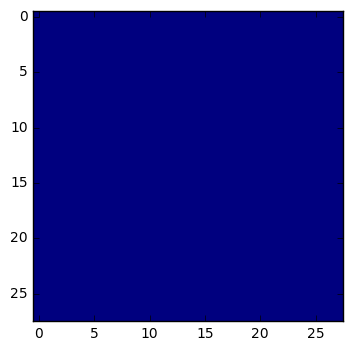

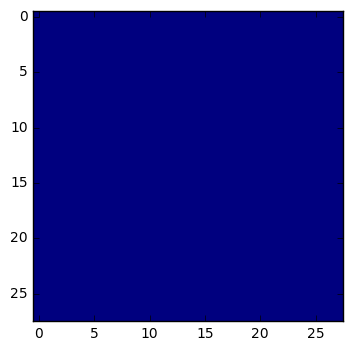

8 223 2777 392.0


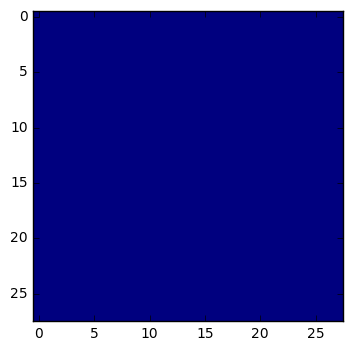

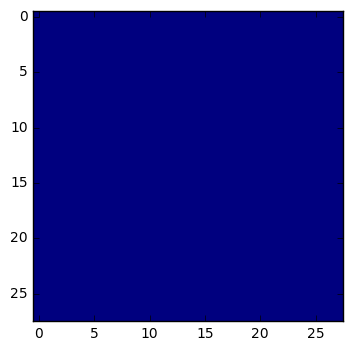

8 223 2808 392.0


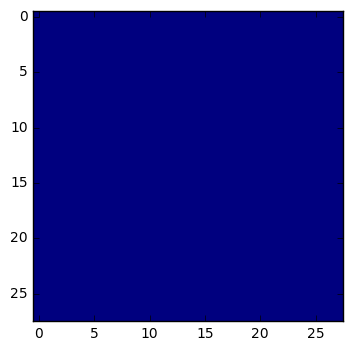

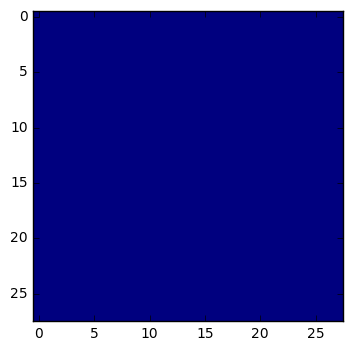

8 223 2830 392.0


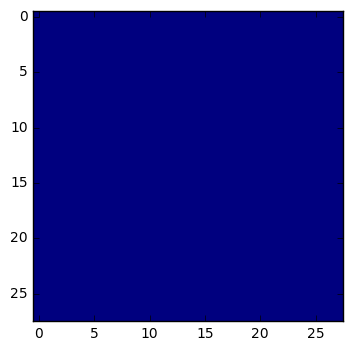

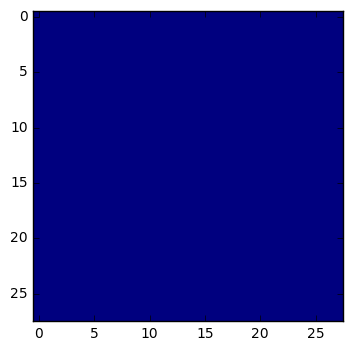

8 223 2884 392.0


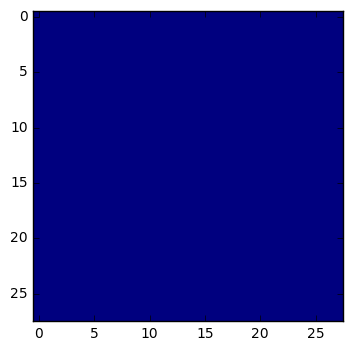

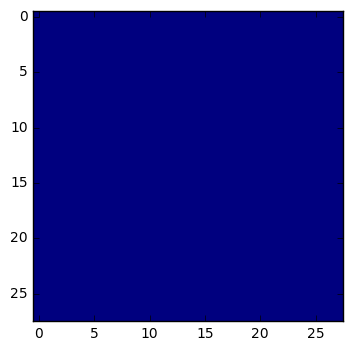

8 223 2922 392.0


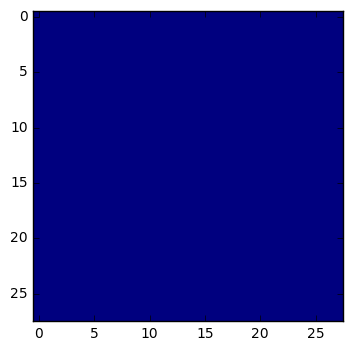

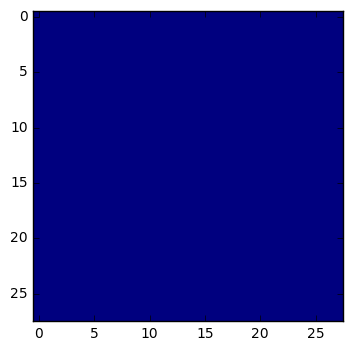

8 223 2949 392.0


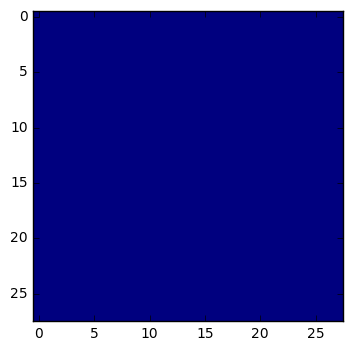

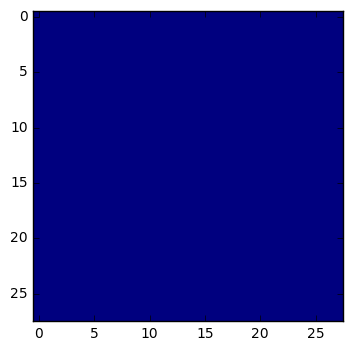

8 223 2960 392.0


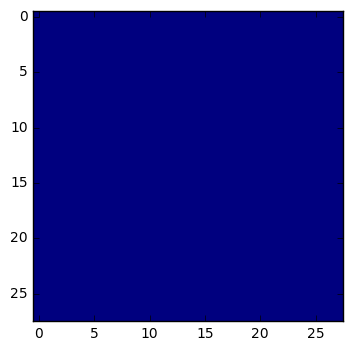

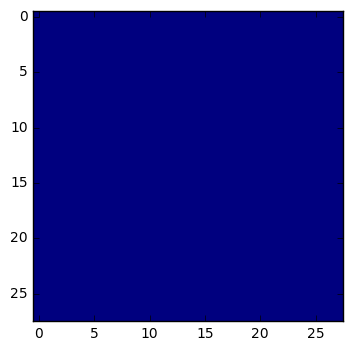

8 223 3039 392.0


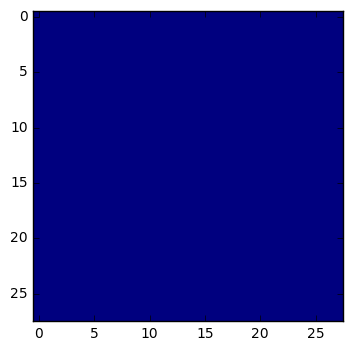

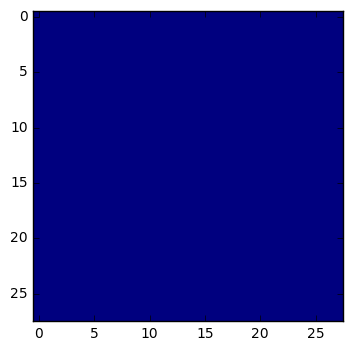

8 223 3086 392.0


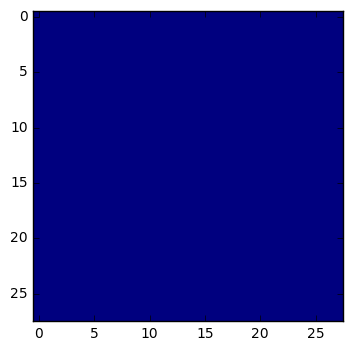

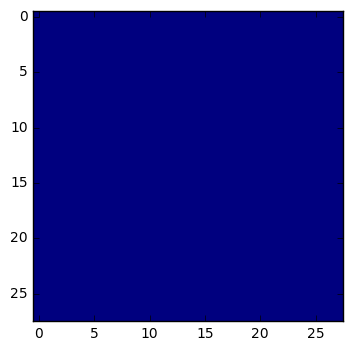

8 223 3128 392.0


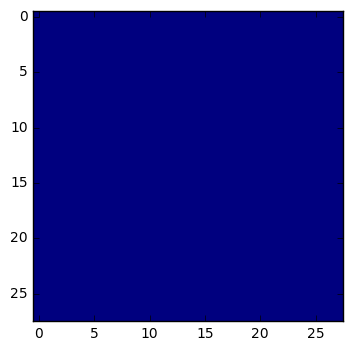

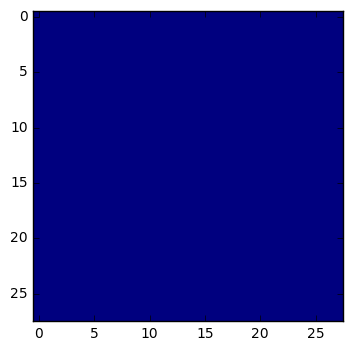

8 223 3160 392.0


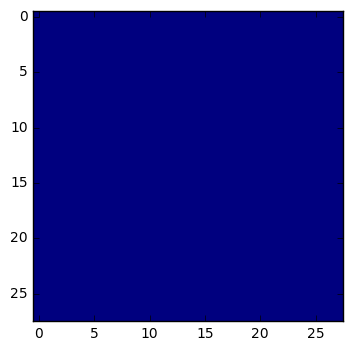

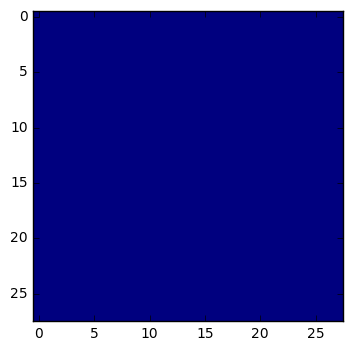

8 223 3163 392.0


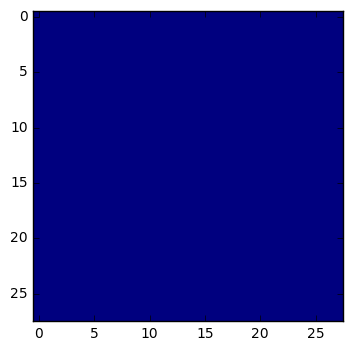

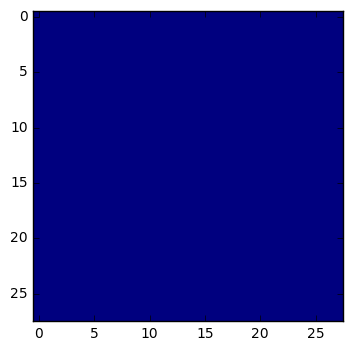

8 223 3250 392.0


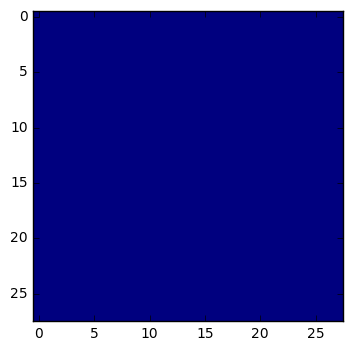

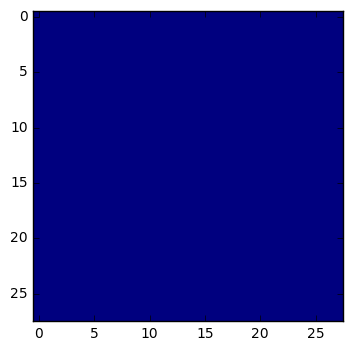

8 223 3258 392.0


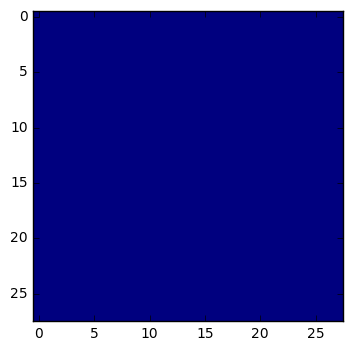

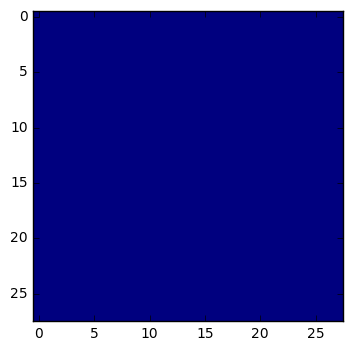

8 223 3299 392.0


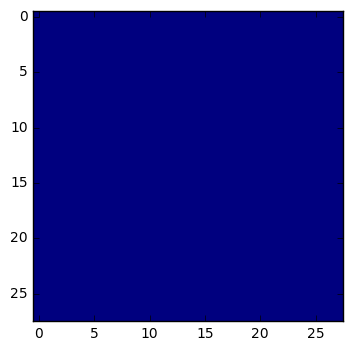

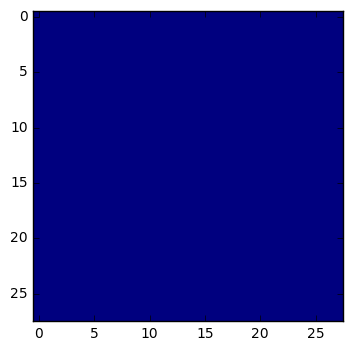

8 223 3335 392.0


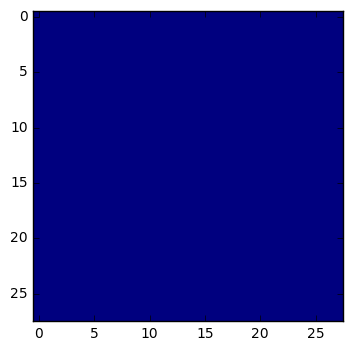

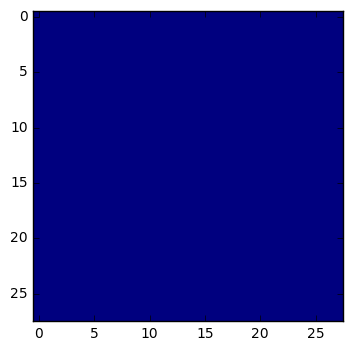

8 223 3407 392.0


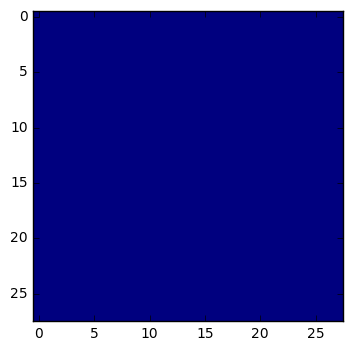

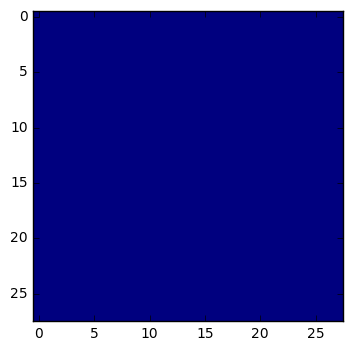

8 223 3474 392.0


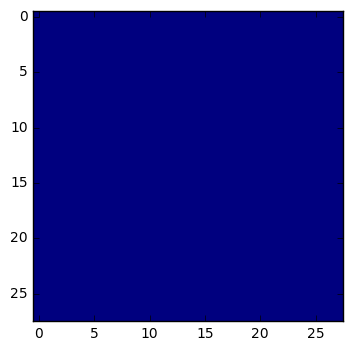

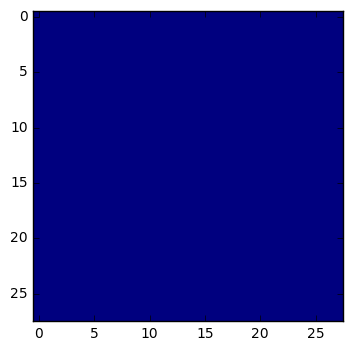

8 223 3548 392.0


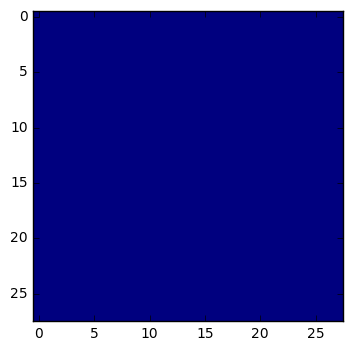

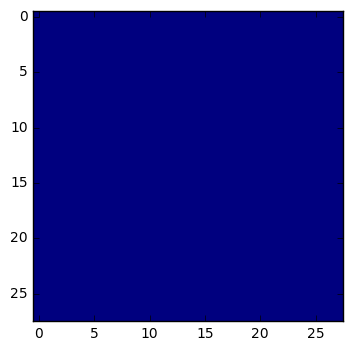

8 223 3626 392.0


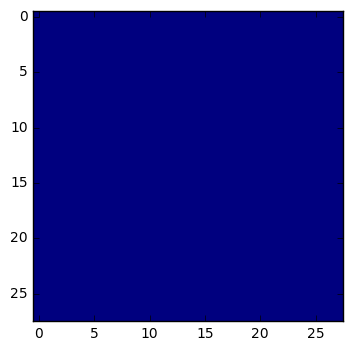

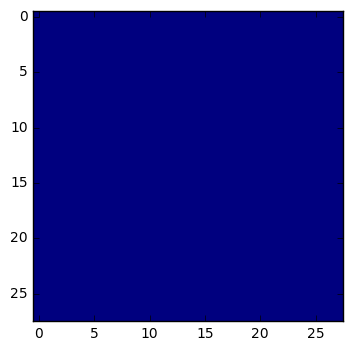

8 223 3685 392.0


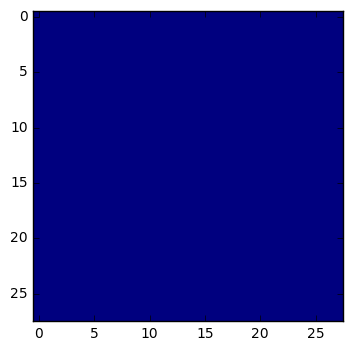

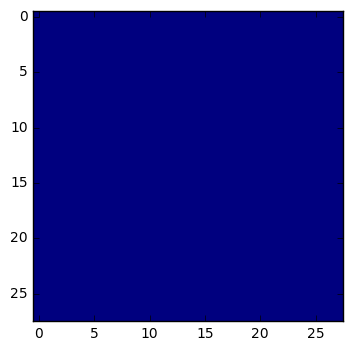

8 223 3740 392.0


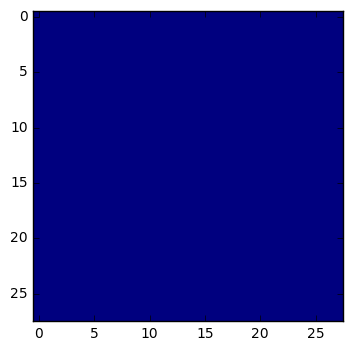

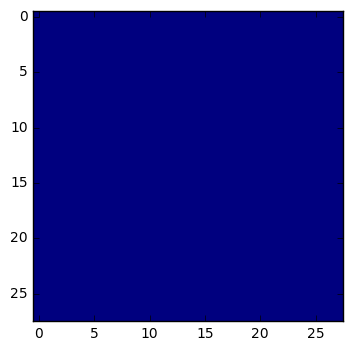

8 223 3819 392.0


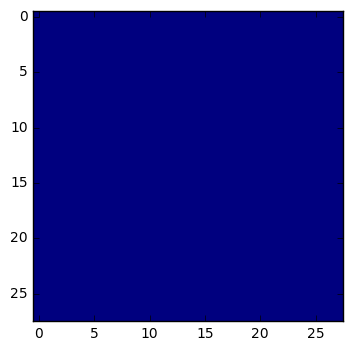

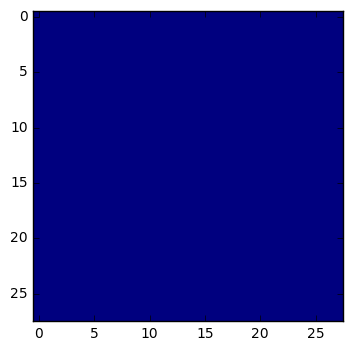

8 223 3832 392.0


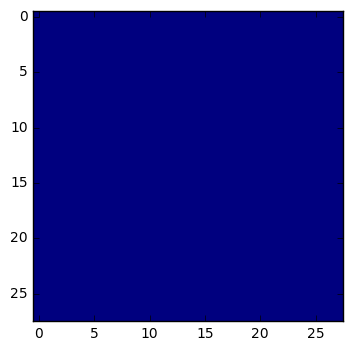

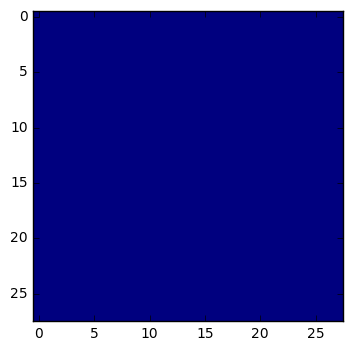

8 223 3840 392.0


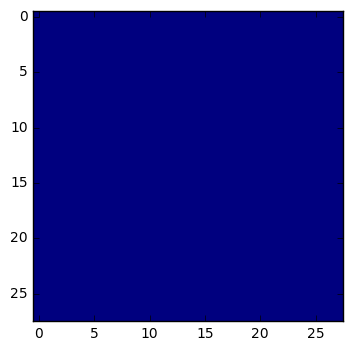

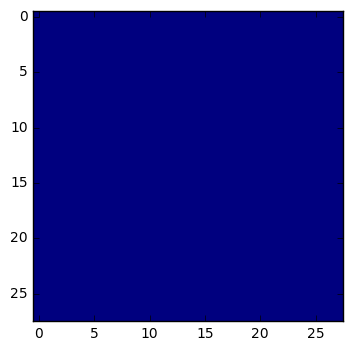

8 223 3902 392.0


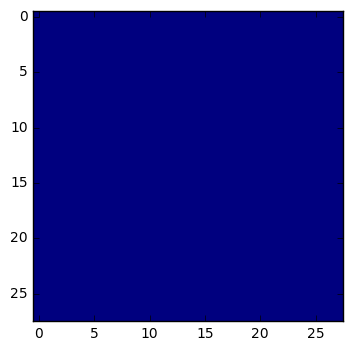

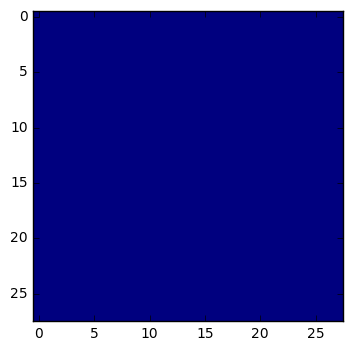

8 223 3954 392.0


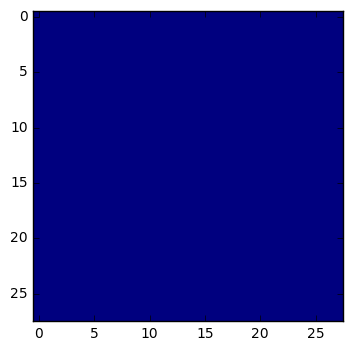

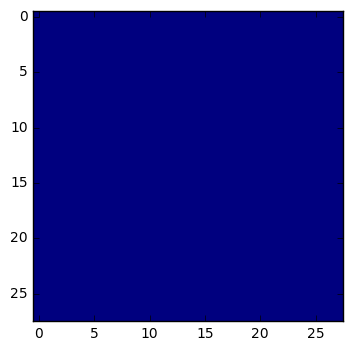

8 223 3984 392.0


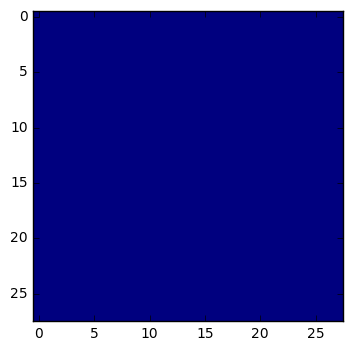

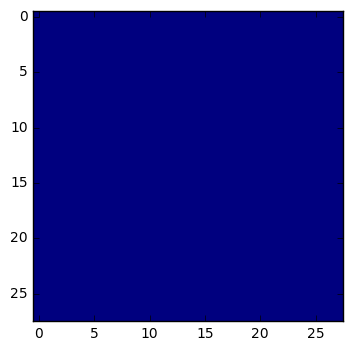

8 223 4244 392.0


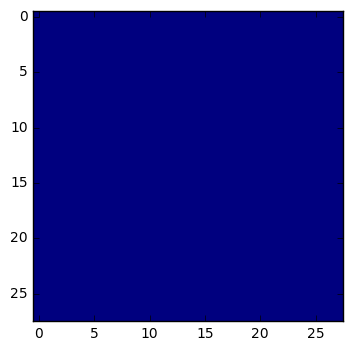

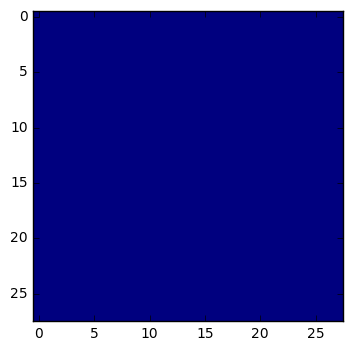

8 223 4298 392.0


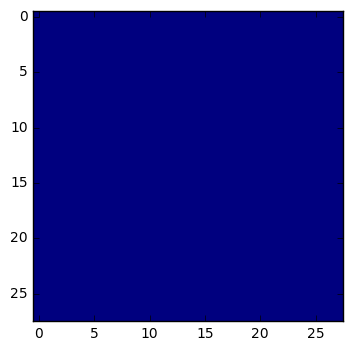

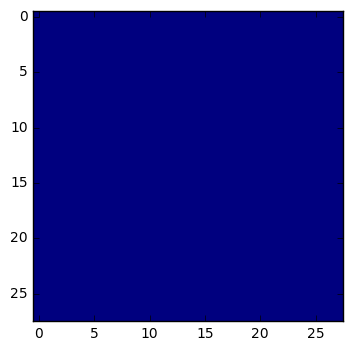

8 223 4331 392.0


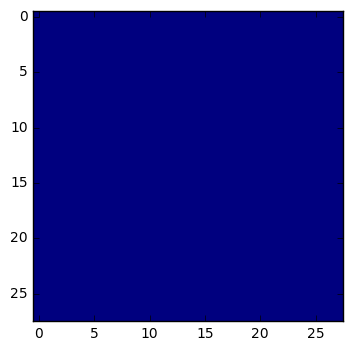

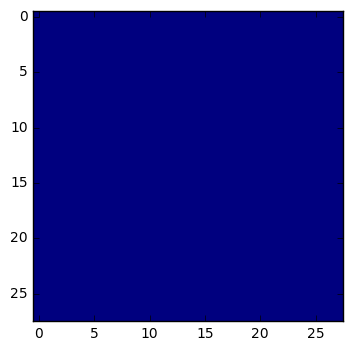

8 223 4526 392.0


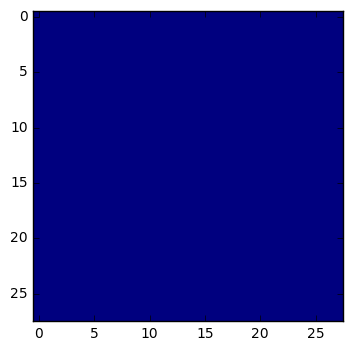

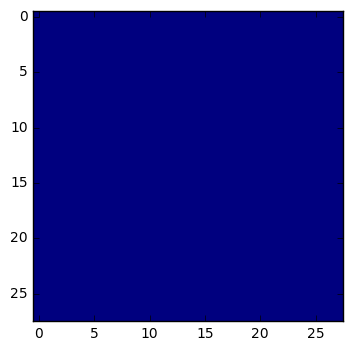

8 223 4558 392.0


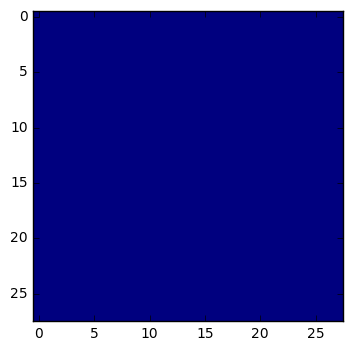

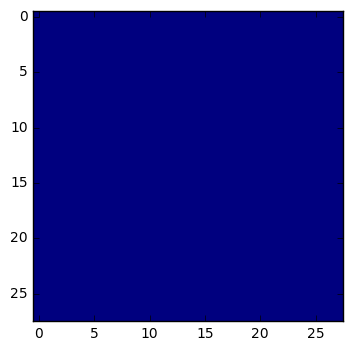

8 223 4717 392.0


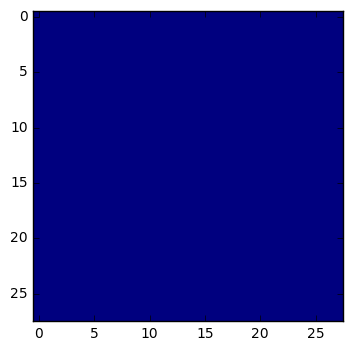

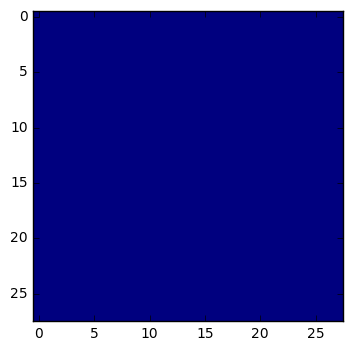

8 223 4720 392.0


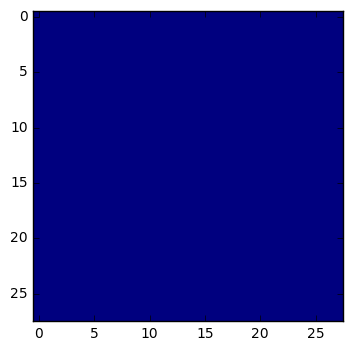

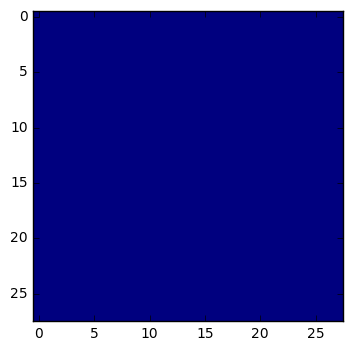

8 223 4735 392.0


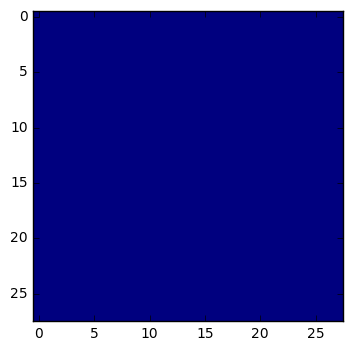

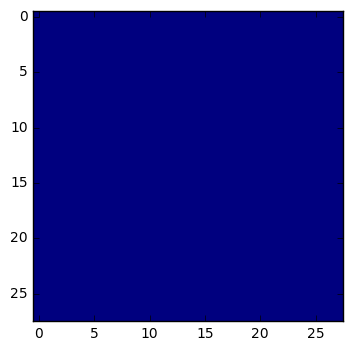

8 223 4789 392.0


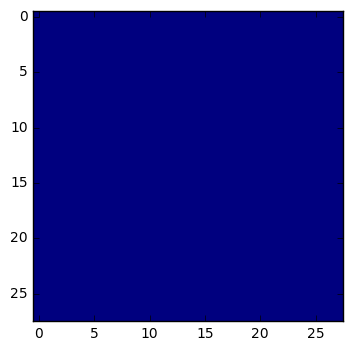

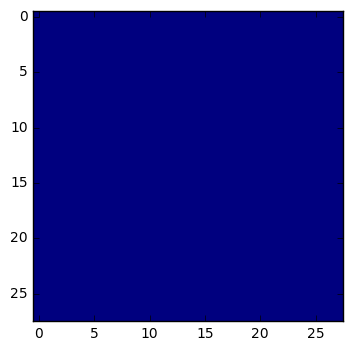

8 223 4879 392.0


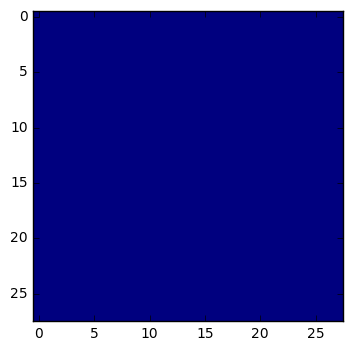

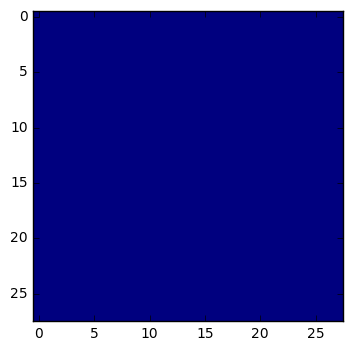

8 223 4942 392.0


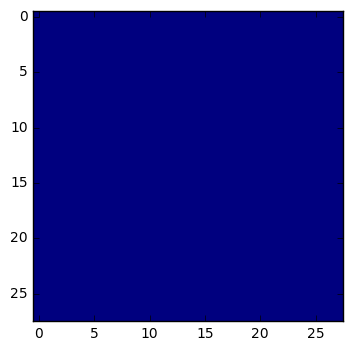

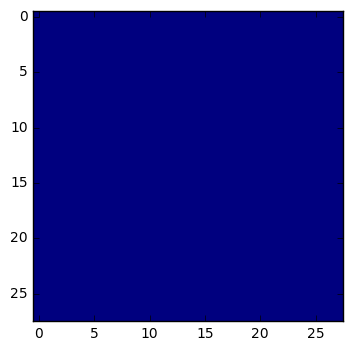

8 223 5041 392.0


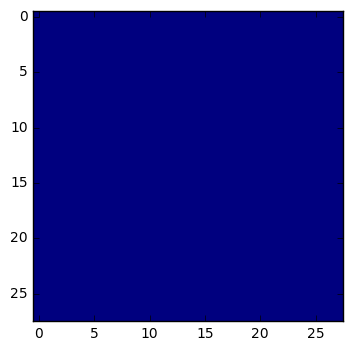

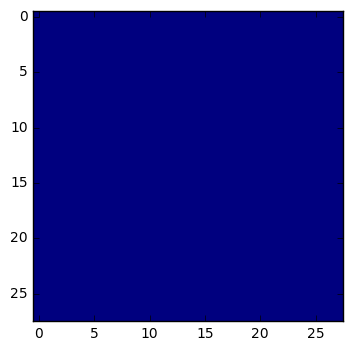

8 223 5157 392.0


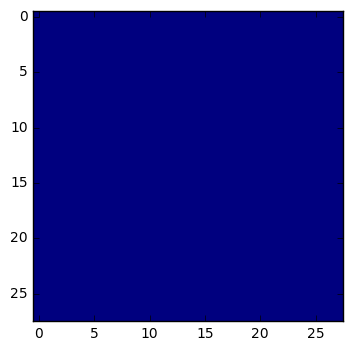

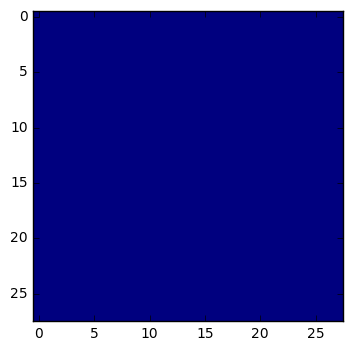

8 223 5167 392.0


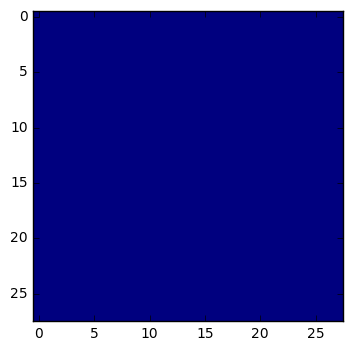

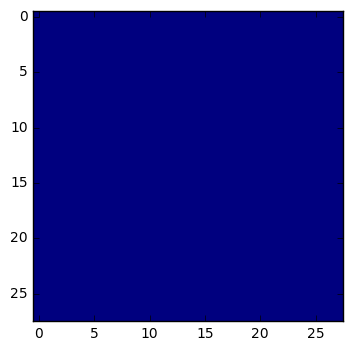

8 223 5173 392.0


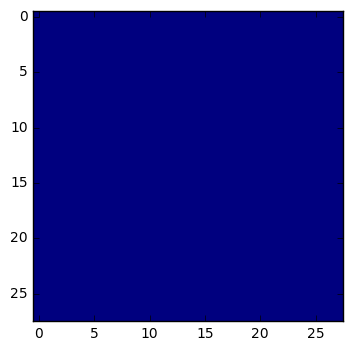

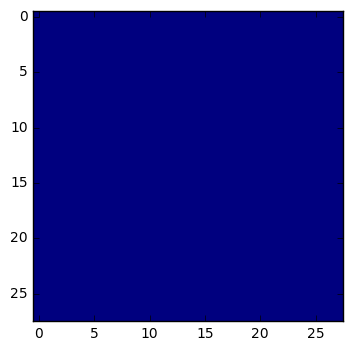

8 223 5398 392.0


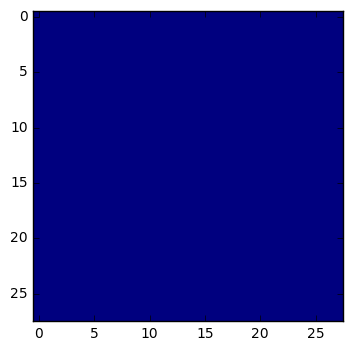

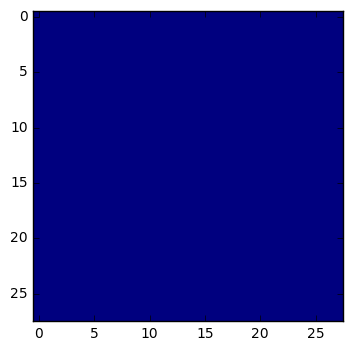

8 223 5548 392.0


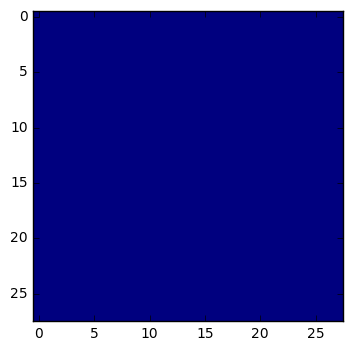

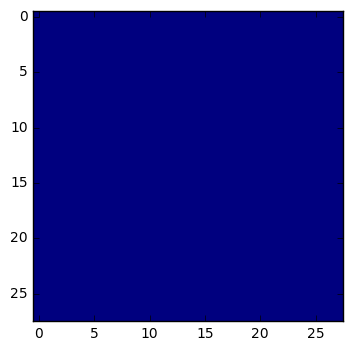

8 223 5580 392.0


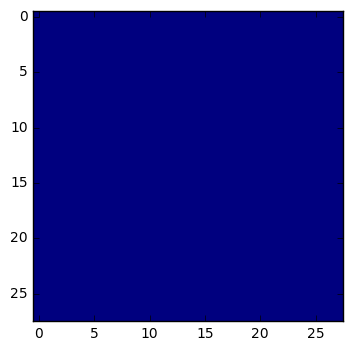

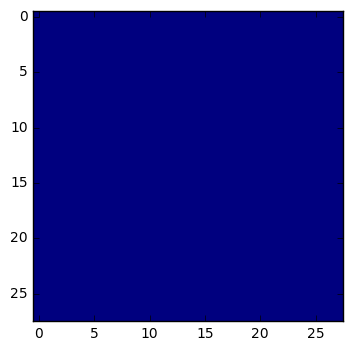

8 223 5604 392.0


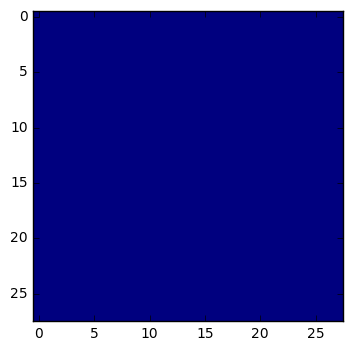

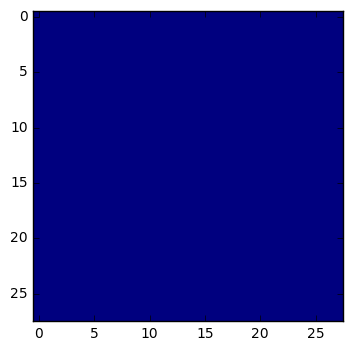

8 223 5618 392.0


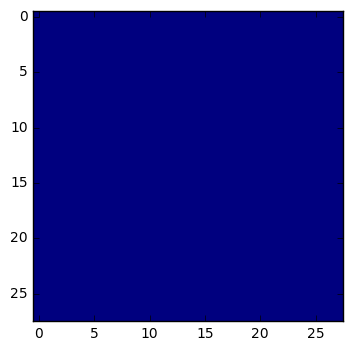

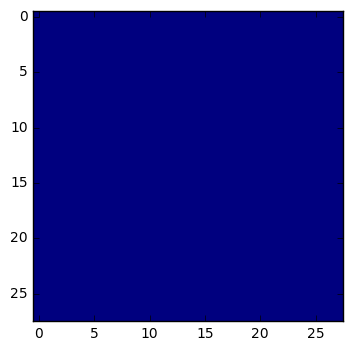

8 223 5787 392.0


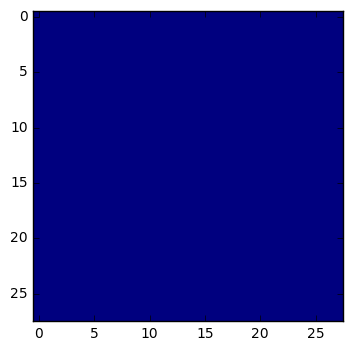

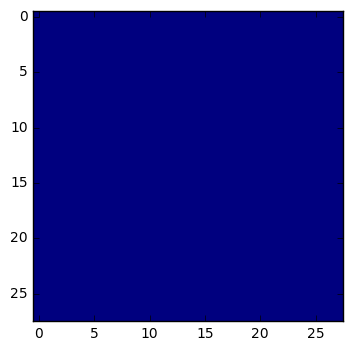

8 223 5803 392.0


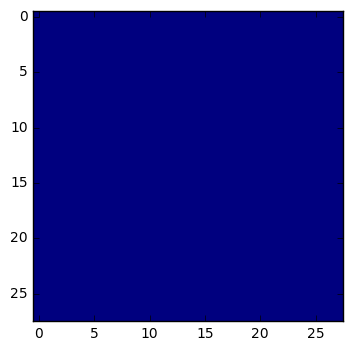

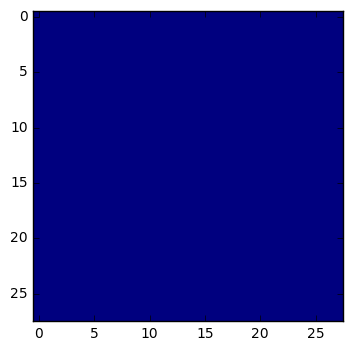

8 223 5837 392.0


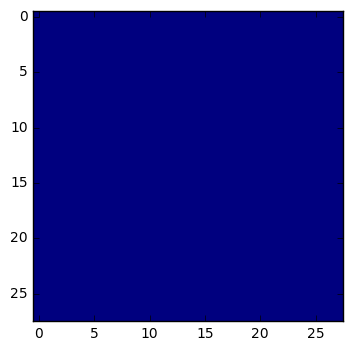

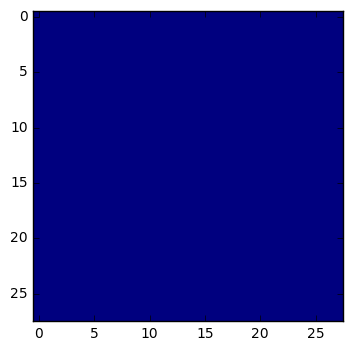

8 223 5882 392.0


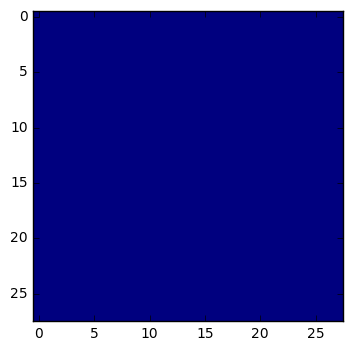

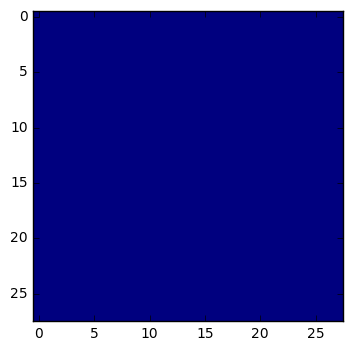

8 223 5940 392.0


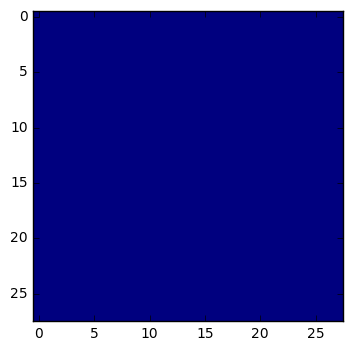

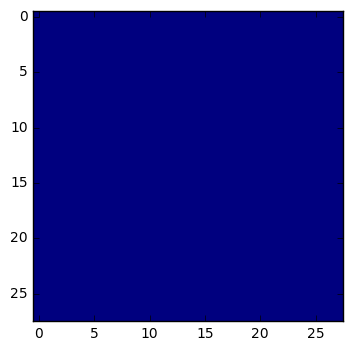

8 223 5992 392.0


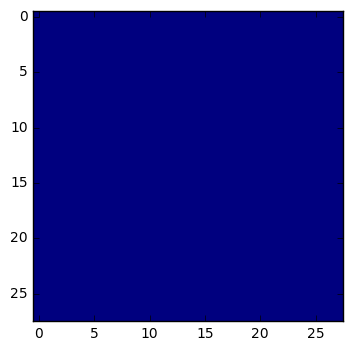

KeyboardInterrupt: 

In [20]:
def count_equal_data2(labelsA, datasetA, labelsB, datasetB):
    count = 0
    for idxA, lblA in enumerate(labelsA):
        for idxB, lblB in enumerate(labelsB):
            if lblA == lblB:
                figureA = datasetA[idxA]
                figureB = datasetB[idxB]
                if figureA.mean() != 0.5 and np.array_equal(figureA, figureB):
                    count += 1
                    print(lblA, idxA, idxB, figureA.sum())
                    plt.imshow(figureA)
                    plt.show()
                    plt.imshow(figureB)
                    plt.show()
    return count

# print('Overlapping train with validation datasets: ', count_equal_data(train_dataset, valid_dataset))
# print('Overlapping train with test datasets: ', count_equal_data(train_dataset, test_dataset))
print('Overlapping validation with test datasets: ', count_equal_data2(valid_labels, valid_dataset, test_labels, test_dataset))

In [11]:
%%timeit
test_dataset[407].mean() == 0.5

The slowest run took 9.19 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 17 µs per loop


In [31]:
%%timeit
np.array_equal(valid_dataset[100], test_dataset[407])

The slowest run took 10.69 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 9.1 µs per loop


In [12]:
test_dataset[407].mean()

0.5

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---